<a href="https://colab.research.google.com/github/AshilPrasad/Financial-forecasting-using-Prophet-and-Budgecting-/blob/main/Financial_forcasting_and_Budjecting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install prophet
!pip install cmdstanpy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error





warning = "ignore"

# Data Understanding and Cleaning

In [ ]:
df=pd.read_excel("/content/Forecasting data.xlsx")

#df/content/AUD INCOME & EXPENSE DATA.xlsx  <-- This line appears to be an error and has been left as is.
#If you intend to read another file, use pd.read_excel again. For example:
#df2 = pd.read_excel("/content/AUD INCOME & EXPENSE DATA.xlsx")

In [ ]:
start_date = "2019-01-01"
end_date = "2024-12-01"

df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
df['Date'] = pd.to_datetime(df['Date'])
# df['Date'] = df['Date'].dt.to_period('M').dt.to_timestamp('M')
df.set_index('Date', inplace=True)

df.tail()


Income & Expenses Category      Sub_category   Amount
Date                                                            
2023-03-01            INCOME  REVENUE  Professional fee  2001883
2023-12-01            INCOME  REVENUE  Professional fee  2079948
2021-03-01            INCOME  REVENUE  Professional fee  2294450
2022-03-01            INCOME  REVENUE  Professional fee  2344306
2020-03-01            INCOME  REVENUE  Professional fee  2402463

In [ ]:
df["Category"]=df["Category"].str.lower()
df["Sub_category"]=df["Sub_category"].str.lower()
df["Income & Expenses"]=df["Income & Expenses"].str.lower()


df["Income & Expenses"]=df["Income & Expenses"].astype("str")
df["Category"]=df["Category"].astype("str")
df["Sub_category"]=df["Sub_category"].astype("str")
df["Amount"]=df["Amount"].astype("float")



df.dtypes


Income & Expenses     object
Category              object
Sub_category          object
Amount               float64
dtype: object

In [ ]:
df.drop_duplicates()
df = df.loc[df['Amount'] != 0]
df

Income & Expenses Category      Sub_category     Amount
Date                                                              
2023-11-01            income  revenue  professional fee  -292212.0
2024-03-01            income  revenue  professional fee  -193876.0
2024-11-01            income  revenue  professional fee  -157700.0
2024-10-01            income  revenue  professional fee  -119013.0
2024-07-01            income  revenue  professional fee   -56500.0
...                      ...      ...               ...        ...
2023-03-01            income  revenue  professional fee  2001883.0
2023-12-01            income  revenue  professional fee  2079948.0
2021-03-01            income  revenue  professional fee  2294450.0
2022-03-01            income  revenue  professional fee  2344306.0
2020-03-01            income  revenue  professional fee  2402463.0

[3440 rows x 4 columns]

In [ ]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3440 entries, 2023-11-01 to 2020-03-01
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Income & Expenses  3440 non-null   object 
 1   Category           3440 non-null   object 
 2   Sub_category       3440 non-null   object 
 3   Amount             3440 non-null   float64
dtypes: float64(1), object(3)
memory usage: 134.4+ KB






# Exploratory Data Analysis (EDA)

In [ ]:
df['Income'] = df.apply(lambda row: row['Amount'] if row['Income & Expenses'] == 'income' else 0, axis=1)
df['Expense'] = df.apply(lambda row: row['Amount'] if row['Income & Expenses'] == 'expense' else 0, axis=1)
df

Income & Expenses Category      Sub_category     Amount     Income  \
Date                                                                            
2023-11-01            income  revenue  professional fee  -292212.0  -292212.0   
2024-03-01            income  revenue  professional fee  -193876.0  -193876.0   
2024-11-01            income  revenue  professional fee  -157700.0  -157700.0   
2024-10-01            income  revenue  professional fee  -119013.0  -119013.0   
2024-07-01            income  revenue  professional fee   -56500.0   -56500.0   
...                      ...      ...               ...        ...        ...   
2023-03-01            income  revenue  professional fee  2001883.0  2001883.0   
2023-12-01            income  revenue  professional fee  2079948.0  2079948.0   
2021-03-01            income  revenue  professional fee  2294450.0  2294450.0   
2022-03-01            income  revenue  professional fee  2344306.0  2344306.0   
2020-03-01            income  revenue  professional fee  2402463.0  2402463.0   

            Expense  
Date                 
2023-11-01      0.0  
2024-03-01      0.0  
2024-11-01      0.0  
2024-10-01      0.0  
2024-07-01      0.0  
...             ...  
2023-03-01      0.0  
2023-12-01      0.0  
2021-03-01      0.0  
2022-03-01      0.0  
2020-03-01      0.0  

[3440 rows x 6 columns]

In [ ]:

df["Year"] = df.index.year
In_Ex=df.groupby(["Year","Income & Expenses"])["Amount"].sum().reset_index()

fig=px.bar(In_Ex,x="Year",y="Amount",
           title="Toal Income and expanses",
           color="Income & Expenses",
           text="Amount",
           template='plotly')

fig.update_layout(title_font_size=16,width=800, height=500, xaxis_title='Category', yaxis_title='Income')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()


In [ ]:
unique_values = df['Sub_category'].unique()
unique_values

array(['professional fee', 'other income', 'outsourced services',
       'rent & tenure', 'license & professional charges',
       'staff benefetexpenses', 'local travel', 'bad debts', 'commission',
       'depreciation', 'communication', 'marketing', 'bank charge',
       'repair & maintanance', 'salary', 'staff cost',
       'marketing cost allocation', 'admin cost allocation',
       'printing & stationary', 'general expense', 'promotions',
       'other direct expenses'], dtype=object)

In [ ]:
category_amount= df.groupby(["Sub_category"])["Expense"].sum().reset_index()
category_amount=category_amount.sort_values(by='Expense', ascending=False)

fig = px.bar(category_amount, x='Sub_category', y='Expense',
             title="Expense by Sub_category",
             color='Expense',
             text='Expense',
             template='plotly')

fig.update_layout(title_font_size=16,width=800, height=500, xaxis_title='Sub_category', yaxis_title='Expense')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()


In [ ]:
yearly_expense = df.groupby(["Year", "Category"])["Expense"].sum().reset_index()

fig = px.bar(
    yearly_expense,
    x="Year",
    y="Expense",
    color="Category",
    title="Yearly Expenses by Category",
    labels={"Expense": "Total Expense", "Year": "Year", "Category": "Category"},
    barmode="group"
)


fig.show()

In [ ]:
yearly_expense = df.groupby(["Year", "Sub_category"])["Expense"].sum().reset_index()

fig = px.bar(
    yearly_expense,
    x="Year",
    y="Expense",
    color="Sub_category",
    title="Yearly Expenses by Sub_category",
    labels={"Expense": "Total Expense", "Year": "Year", "Sub_category": "Sub_category"},
    barmode="group"
)


fig.show()

In [ ]:
grouped_data = df.groupby(['Sub_category', 'Category'])['Amount'].sum().reset_index()
grouped_data = grouped_data.sort_values('Amount', ascending=False)


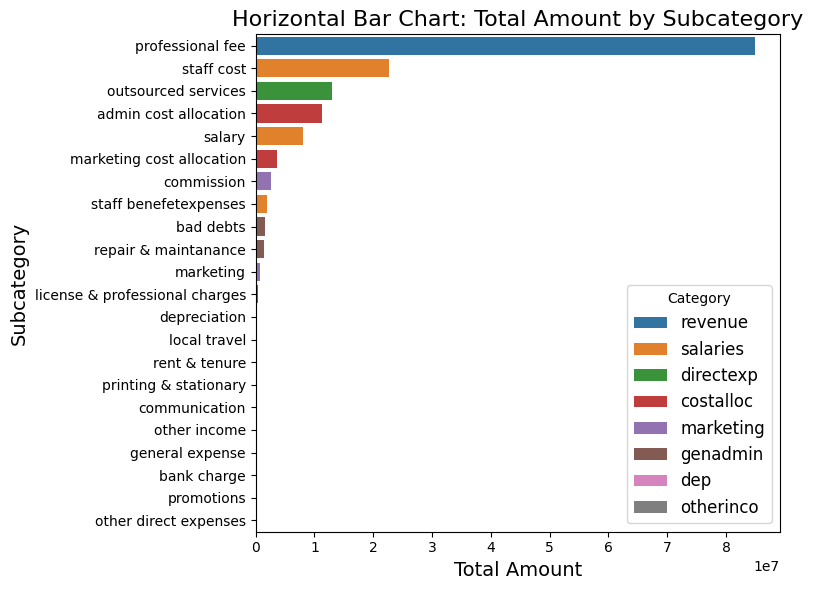

In [ ]:
# Sort the data for better visualization
grouped_data = grouped_data.sort_values('Amount', ascending=False)

# Plot a horizontal bar chart
plt.figure(figsize=(8, 6))
sns.barplot(
    data=grouped_data,
    x='Amount',
    y='Sub_category',
    hue='Category',
    dodge=False
)

# Set plot title and labels
plt.title('Horizontal Bar Chart: Total Amount by Subcategory', fontsize=16)
plt.xlabel('Total Amount', fontsize=14)
plt.ylabel('Subcategory', fontsize=14)
plt.legend(title='Category', fontsize=12, loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
income_expanse =df.groupby('Date')[['Income','Expense']].sum()
income_expanse['Profit']=income_expanse['Income']-income_expanse['Expense']
income_expanse.tail(12)

Income    Expense    Profit
Date                                      
2024-01-01  1160335.0  1190465.0  -30130.0
2024-02-01  1923737.0  1353894.0  569843.0
2024-03-01  2008474.0  1269232.0  739242.0
2024-04-01  1570761.0  1328849.0  241912.0
2024-05-01  1871670.0  1682984.0  188686.0
2024-06-01  1720202.0  1433588.0  286614.0
2024-07-01  1837180.0  1377737.0  459443.0
2024-08-01  1519958.0  1491367.0   28591.0
2024-09-01  1573198.0  1353097.0  220101.0
2024-10-01  1312045.0  1375335.0  -63290.0
2024-11-01  1602993.0  1647936.0  -44943.0
2024-12-01  2353545.0  1424353.0  929192.0

In [ ]:
fig = go.Figure()


fig.add_trace(go.Scatter(
    x=income_expanse.index,
    y=income_expanse['Income'],
    mode='lines+markers',
    name='Monthly Income',
    line=dict(color='green'),
    marker=dict(size=2, color='green', symbol='circle', line=dict(color='darkgreen', width=1))
))


fig.add_trace(go.Scatter(
    x=income_expanse.index,
    y=income_expanse['Expense'],
    mode='lines+markers',
    name='Monthly Expenses',
    line=dict(color='red'),
    marker=dict(size=2, color='red', symbol='circle', line=dict(color='darkred', width=1))
))



fig.update_layout(
    title="Monthly Income vs Expenses",
    xaxis_title="Date",
    yaxis_title="Amount",
    width=800,
    height=500,
    title_font_size=16,
    legend=dict(title="Legend", x=4, y=4),
)


fig.show()

In [ ]:
Q1 = income_expanse['Income'].quantile(0.25)
Q3 = income_expanse['Income'].quantile(0.75)
IQR = Q3 - Q1
lower_b = Q1 - 1.5 * IQR
upper_b = Q3 + 1.5 * IQR

print(lower_b)
print(upper_b)

-253131.125
2579469.875


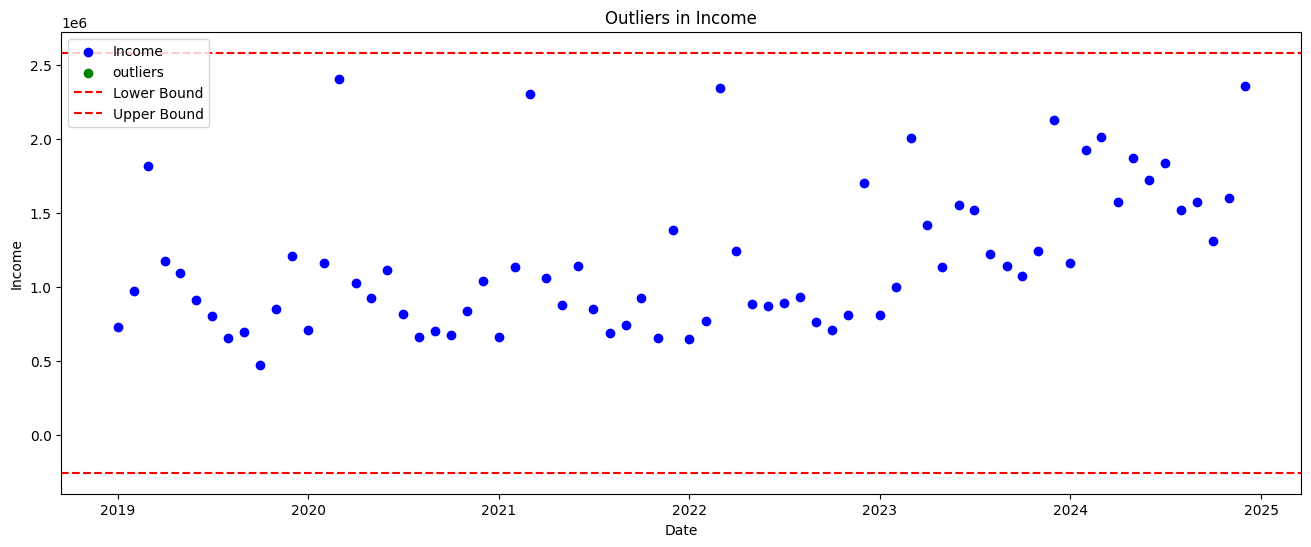

In [ ]:
outliers = income_expanse[(income_expanse['Income'] < lower_b) | (income_expanse['Income'] > upper_b)]


plt.figure(figsize=(16, 6))
plt.scatter(income_expanse.index, income_expanse['Income'], color='blue', label='Income')
plt.scatter(outliers.index, outliers['Income'], color='green',label="outliers")
plt.axhline(y=lower_b, color='red', linestyle='--', label='Lower Bound')
plt.axhline(y=upper_b, color='red', linestyle='--', label='Upper Bound')
plt.xlabel('Date')
plt.ylabel('Income')
plt.title('Outliers in Income')
plt.legend(loc="upper left")
plt.show()

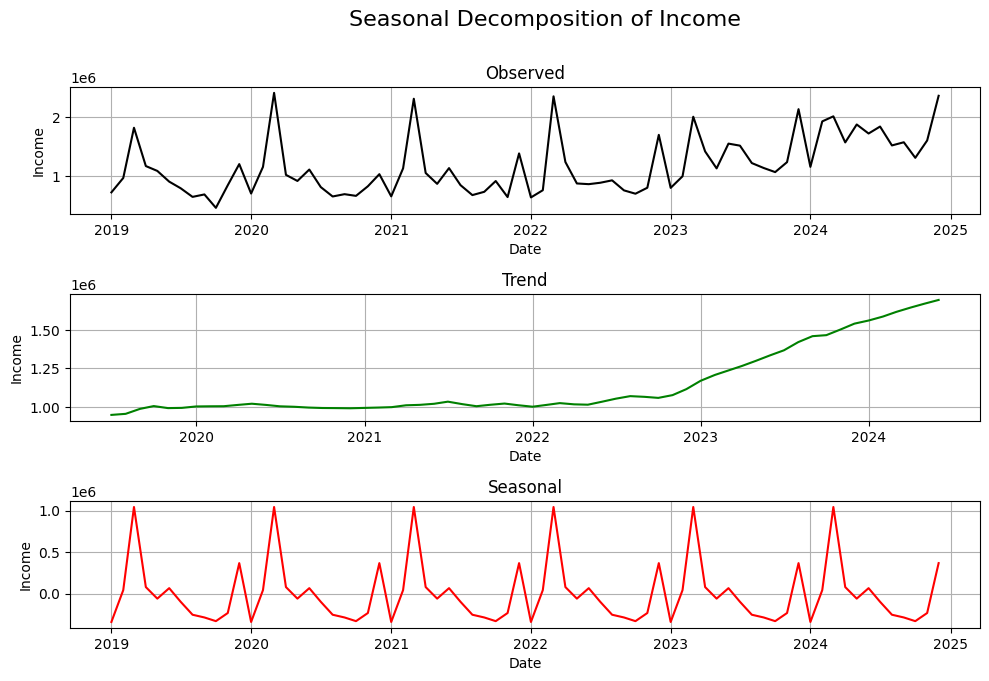

In [ ]:
decomposition = seasonal_decompose(income_expanse['Income'], model='additive',period=12)

plt.figure(figsize=(10, 8))

# Plot observed data
plt.subplot(411)
plt.plot(decomposition.observed, color='black')
plt.title('Observed')
plt.xlabel('Date')
plt.ylabel('Income')
plt.grid(True)

# Plot trend component
plt.subplot(412)
plt.plot(decomposition.trend, color='green')
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Income')
plt.grid(True)

# Plot seasonal component
plt.subplot(413)
plt.plot(decomposition.seasonal, color='red')
plt.title('Seasonal')
plt.xlabel('Date')
plt.ylabel('Income')
plt.grid(True)

# plt.subplot(414)
# plt.plot(decomposition.resid, color='purple')
# plt.title('Residual')
# plt.xlabel('Date')
# plt.ylabel('Income')
# plt.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.suptitle('Seasonal Decomposition of Income', fontsize=16, y=1.05,x=0.55)
plt.show()

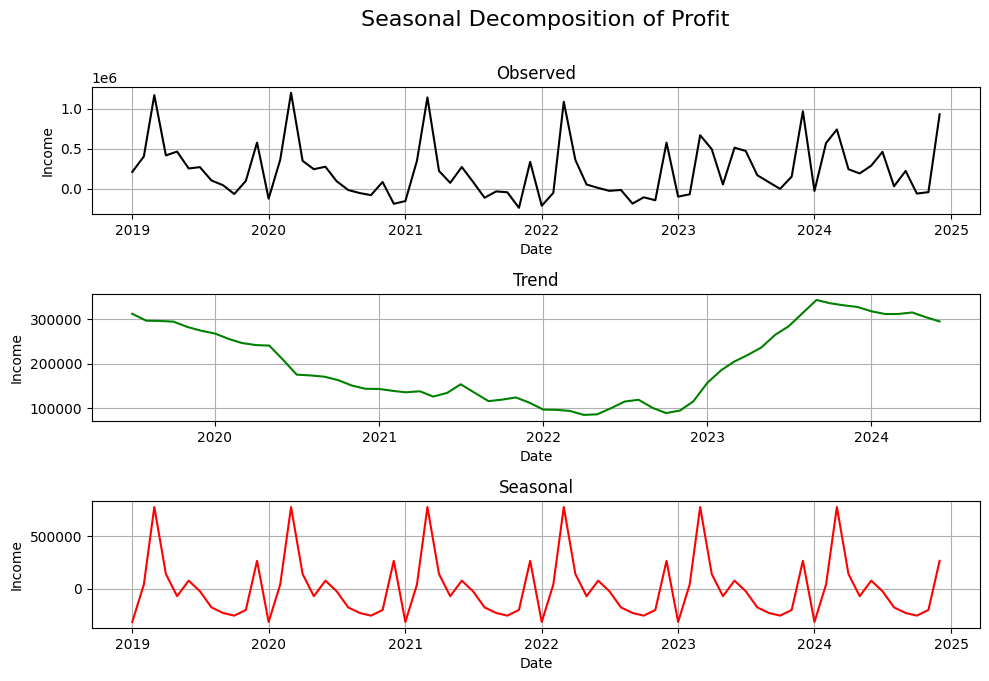

In [ ]:
decomposition = seasonal_decompose(income_expanse['Profit'], model='additive',period=12)

plt.figure(figsize=(10, 8))

# Plot observed data
plt.subplot(411)
plt.plot(decomposition.observed, color='black')
plt.title('Observed')
plt.xlabel('Date')
plt.ylabel('Income')
plt.grid(True)

# Plot trend component
plt.subplot(412)
plt.plot(decomposition.trend, color='green')
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Income')
plt.grid(True)

# Plot seasonal component
plt.subplot(413)
plt.plot(decomposition.seasonal, color='red')
plt.title('Seasonal')
plt.xlabel('Date')
plt.ylabel('Income')
plt.grid(True)

# plt.subplot(414)
# plt.plot(decomposition.resid, color='purple')
# plt.title('Residual')
# plt.xlabel('Date')
# plt.ylabel('Income')
# plt.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.suptitle('Seasonal Decomposition of Profit', fontsize=16, y=1.05,x=0.55)
plt.show()

In [ ]:
# Q1 = income_expanse['Expense'].quantile(0.25)
# Q3 = income_expanse['Expense'].quantile(0.75)
# IQR = Q3 - Q1
# lower_b = Q1 - 1.5 * IQR
# upper_b = Q3 + 1.5 * IQR

# print(lower_b)
# print(upper_b)

In [ ]:
# outliers = income_expanse[(income_expanse['Expense'] < lower_b) | (income_expanse['Expense'] > upper_b)]


# plt.figure(figsize=(16, 6))
# plt.scatter(income_expanse.index, income_expanse['Expense'], color='blue', label='Expense')
# plt.scatter(outliers.index, outliers['Expense'], color='green',label="outliers")
# plt.axhline(y=lower_b, color='red', linestyle='--', label='Lower Bound')
# plt.axhline(y=upper_b, color='red', linestyle='--', label='Upper Bound')
# plt.xlabel('Date')
# plt.ylabel('Expense')
# plt.title('Outliers in Expense')
# plt.legend(loc="upper left")
# plt.show()

In [ ]:

# income_expanse["Expense"] = income_expanse["Expense"].apply(lambda x: upper_b if x > upper_b else lower_b if x < lower_b else x)


# outliers = income_expanse[(income_expanse['Expense'] < lower_b) | (income_expanse['Expense'] > upper_b)]

# plt.figure(figsize=(16, 6))
# plt.scatter(income_expanse.index, income_expanse['Expense'], color='blue', label='Expense')
# plt.scatter(outliers.index, outliers['Expense'], color='green', label="Outliers")
# plt.axhline(y=lower_b, color='red', linestyle='--', label='Lower Bound')
# plt.axhline(y=upper_b, color='red', linestyle='--', label='Upper Bound')
# plt.xlabel('Date')
# plt.ylabel('Expense')
# plt.title('After Capping Expense')
# plt.legend(loc="upper left")
# plt.show()


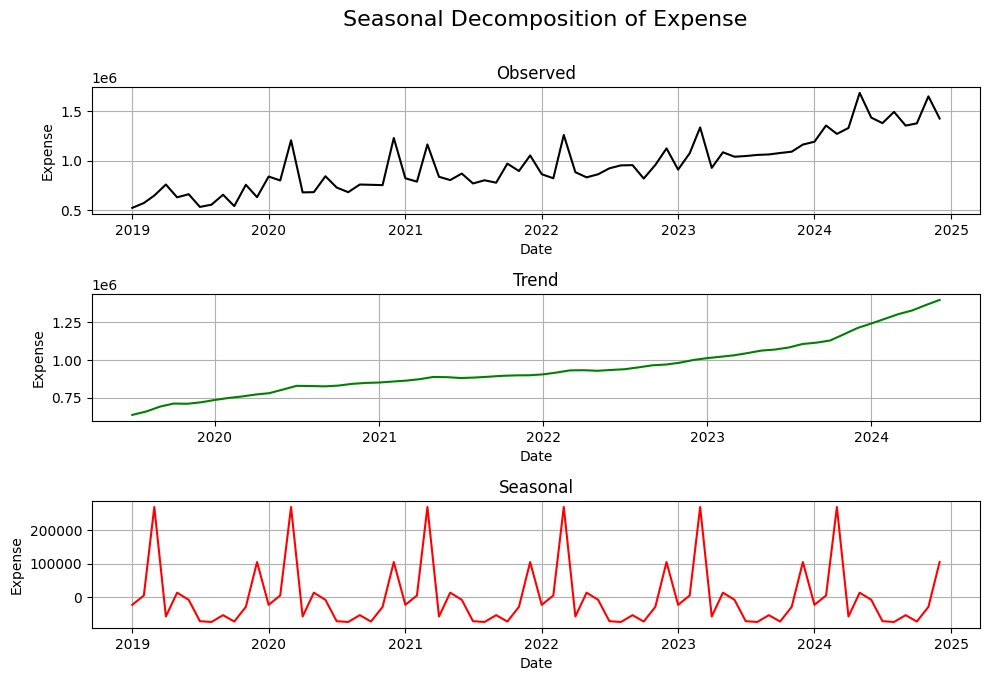

In [ ]:
decomposition = seasonal_decompose(income_expanse['Expense'], model='additive',period=12)

plt.figure(figsize=(10, 8))

# Plot observed data
plt.subplot(411)
plt.plot(decomposition.observed, color='black')
plt.title('Observed')
plt.xlabel('Date')
plt.ylabel('Expense')
plt.grid(True)

# Plot trend component
plt.subplot(412)
plt.plot(decomposition.trend, color='green')
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Expense')
plt.grid(True)

# Plot seasonal component
plt.subplot(413)
plt.plot(decomposition.seasonal, color='red')
plt.title('Seasonal')
plt.xlabel('Date')
plt.ylabel('Expense')
plt.grid(True)


# plt.subplot(414)
# plt.plot(decomposition.resid, color='purple')
# plt.title('Residual')
# plt.xlabel('Date')
# plt.ylabel('Expense')
# plt.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.suptitle('Seasonal Decomposition of Expense', fontsize=16,y=1.05,x=0.55)
plt.show()

In [ ]:
yearly=income_expanse.resample('YE').sum()
yearly

Income     Expense     Profit
Date                                         
2019-12-31  11385105.0   7464809.0  3920296.0
2020-12-31  12069601.0   9952168.0  2117433.0
2021-12-31  12417470.0  10546368.0  1871102.0
2022-12-31  12561695.0  11245536.0  1316159.0
2023-12-31  16238433.0  12860242.0  3378191.0
2024-12-31  20454098.0  16928837.0  3525261.0

In [ ]:
fig = go.Figure()


fig.add_trace(go.Scatter(
    x=yearly.index,
    y=yearly['Income'],
    mode='lines+markers',  #
    name='Yearly Income',
    line=dict(color='green'),
    marker=dict(size=8, color='green', symbol='circle', line=dict(color='darkgreen', width=2))
))


fig.add_trace(go.Scatter(
    x=yearly.index,
    y=yearly['Expense'],
    mode='lines+markers',
    name='Yearly Expenses',
    line=dict(color='red'),
    marker=dict(size=8, color='red', symbol='circle', line=dict(color='darkred', width=2))
))


fig.update_layout(
    title="Yearly Income vs Expenses",
    xaxis_title="Year",
    yaxis_title="Amount",
    width=800,
    height=500,
    title_font_size=16,
    legend=dict(title="Legend", x=4, y=4),
)


fig.show()

# Data Preparation & Feature Engineering

In [ ]:
df = df.groupby(['Date', 'Income & Expenses', 'Category','Sub_category']).agg({'Amount': 'sum'}).reset_index()
df

Date Income & Expenses   Category           Sub_category     Amount
0    2019-01-01           expense        dep           depreciation     1388.0
1    2019-01-01           expense  directexp    outsourced services    26878.0
2    2019-01-01           expense   genadmin              bad debts    19637.0
3    2019-01-01           expense   genadmin            bank charge      761.0
4    2019-01-01           expense   genadmin          communication     3799.0
...         ...               ...        ...                    ...        ...
1410 2024-12-01           expense   salaries                 salary   560118.0
1411 2024-12-01           expense   salaries  staff benefetexpenses    13506.0
1412 2024-12-01           expense   salaries             staff cost    37794.0
1413 2024-12-01            income  otherinco           other income     6735.0
1414 2024-12-01            income    revenue       professional fee  2346810.0

[1415 rows x 5 columns]

In [ ]:
new = df.pivot_table(index='Date', columns='Category', values='Amount', aggfunc='sum')
new.columns.name = None
df=pd.concat([new,income_expanse],axis=1)

original=df.copy()
df


costalloc      dep  directexp  genadmin  marketing  otherinco  \
Date                                                                        
2019-01-01        NaN   1388.0    26878.0   37785.0    10959.0      119.0   
2019-02-01        NaN   1274.0    38531.0  103496.0    14055.0        NaN   
2019-03-01        NaN   1780.0   116953.0   97181.0    24668.0        NaN   
2019-04-01        NaN   1938.0   251199.0   55616.0    10087.0       -1.0   
2019-05-01        NaN   2142.0   125882.0   46732.0    44688.0        1.0   
...               ...      ...        ...       ...        ...        ...   
2024-08-01   431713.0   5185.0   244815.0   81046.0   118821.0    -3868.0   
2024-09-01   295625.0   5004.0   220501.0   81970.0   167816.0    12989.0   
2024-10-01   337300.0   5099.0   253219.0   85905.0    64322.0     8527.0   
2024-11-01   340753.0  41416.0   431107.0  120648.0    68155.0     7834.0   
2024-12-01   223276.0  45719.0   391259.0  -91777.0   244458.0     6735.0   

              revenue  salaries     Income    Expense     Profit  
Date                                                              
2019-01-01   731589.0  446600.0   731708.0   523610.0   208098.0  
2019-02-01   973686.0  414826.0   973686.0   572182.0   401504.0  
2019-03-01  1816719.0  406980.0  1816719.0   647562.0  1169157.0  
2019-04-01  1173694.0  439792.0  1173693.0   758632.0   415061.0  
2019-05-01  1092070.0  410287.0  1092071.0   629731.0   462340.0  
...               ...       ...        ...        ...        ...  
2024-08-01  1523826.0  609787.0  1519958.0  1491367.0    28591.0  
2024-09-01  1560209.0  582181.0  1573198.0  1353097.0   220101.0  
2024-10-01  1303518.0  629490.0  1312045.0  1375335.0   -63290.0  
2024-11-01  1595159.0  645857.0  1602993.0  1647936.0   -44943.0  
2024-12-01  2346810.0  611418.0  2353545.0  1424353.0   929192.0  

[72 rows x 11 columns]

In [ ]:
original.fillna(0,inplace=True)
original.reset_index(inplace=True)
original

columns_to_convert = ['costalloc', 'dep', 'directexp', 'genadmin', 'marketing',
                      'otherinco', 'revenue', 'salaries', 'Income', 'Expense', 'Profit']
for col in columns_to_convert:
   original[col] = original[col].astype(int)

In [ ]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       72 non-null     datetime64[ns]
 1   costalloc  72 non-null     int64         
 2   dep        72 non-null     int64         
 3   directexp  72 non-null     int64         
 4   genadmin   72 non-null     int64         
 5   marketing  72 non-null     int64         
 6   otherinco  72 non-null     int64         
 7   revenue    72 non-null     int64         
 8   salaries   72 non-null     int64         
 9   Income     72 non-null     int64         
 10  Expense    72 non-null     int64         
 11  Profit     72 non-null     int64         
dtypes: datetime64[ns](1), int64(11)
memory usage: 6.9 KB


In [ ]:
df['profit'] = df['Income'] - df['Expense']

df['Year'] = df.index.year


df[['genadmin', 'marketing']] = df[['genadmin', 'marketing']].mask(df[['genadmin', 'marketing']] < 0, pd.NA)
df[['genadmin', 'marketing','costalloc']] = df[['genadmin', 'marketing','costalloc']].interpolate(method='linear', limit_direction='both')

df['rolling_genadmin'] = df['genadmin'].rolling(window=3).mean()
df['rolling_marketing'] = df['marketing'].rolling(window=6).mean()
df['rolling_costalloc'] = df['costalloc'].rolling(window=3).mean()
df['rolling_directexp'] = df['directexp'].rolling(window=3).mean()



df['rolling_genadmin'] = df['rolling_genadmin'].interpolate(method='linear', limit_direction='both').astype(int)
df['rolling_marketing'] = df['rolling_marketing'].interpolate(method='linear', limit_direction='both').astype(int)
df['rolling_costalloc'] = df['rolling_costalloc'].interpolate(method='linear', limit_direction='both').astype(int)
df['rolling_directexp'] = df['rolling_directexp'].interpolate(method='linear', limit_direction='both').astype(int)



df.tail(20)

costalloc      dep  directexp  genadmin  marketing  otherinco  \
Date                                                                        
2023-05-01   276130.0   3344.0   238226.0   78347.0    30666.0    28562.0   
2023-06-01   261486.0   3358.0   172946.0   81870.0    37488.0      -81.0   
2023-07-01   259932.0   3738.0   168958.0   88003.0    50874.0    11500.0   
2023-08-01   239428.0   4043.0   203705.0   67261.0    45799.0     5750.0   
2023-09-01   260683.0   3959.0   175566.0   83673.0    53692.0     5750.0   
2023-10-01   317116.0   4122.0   183750.0   68506.0    35963.0        NaN   
2023-11-01   308835.0   4307.0   166100.0   65227.0    36708.0        NaN   
2023-12-01   169814.0   4417.0   276942.0  134271.0   160525.0    19523.0   
2024-01-01   309107.0   4412.0   170497.0   95891.0    31549.0      846.0   
2024-02-01   278350.0   4415.0   210131.0  116380.0    45359.0    -3469.0   
2024-03-01   292040.0   5350.0   204706.0  101166.0    62603.0     1488.0   
2024-04-01   303792.0   4627.0   217583.0   92660.0    44478.0     -538.0   
2024-05-01   317972.0   4982.0   579904.0  118383.0    41866.0    13894.0   
2024-06-01   452248.0   5017.0   248412.0   89247.0    38908.0       99.0   
2024-07-01   356225.0   5185.0   238966.0  114606.0    37424.0    18093.0   
2024-08-01   431713.0   5185.0   244815.0   81046.0   118821.0    -3868.0   
2024-09-01   295625.0   5004.0   220501.0   81970.0   167816.0    12989.0   
2024-10-01   337300.0   5099.0   253219.0   85905.0    64322.0     8527.0   
2024-11-01   340753.0  41416.0   431107.0  120648.0    68155.0     7834.0   
2024-12-01   223276.0  45719.0   391259.0  120648.0   244458.0     6735.0   

              revenue  salaries     Income    Expense    Profit    profit  \
Date                                                                        
2023-05-01  1106079.0  457057.0  1134641.0  1083770.0   50871.0   50871.0   
2023-06-01  1550593.0  481861.0  1550512.0  1039009.0  511503.0  511503.0   
2023-07-01  1504840.0  474530.0  1516340.0  1046035.0  470305.0  470305.0   
2023-08-01  1218127.0  496962.0  1223877.0  1057198.0  166679.0  166679.0   
2023-09-01  1135528.0  484584.0  1141278.0  1062157.0   79121.0   79121.0   
2023-10-01  1072270.0  467124.0  1072270.0  1076581.0   -4311.0   -4311.0   
2023-11-01  1239509.0  508638.0  1239509.0  1089815.0  149694.0  149694.0   
2023-12-01  2109525.0  415703.0  2129048.0  1161672.0  967376.0  967376.0   
2024-01-01  1159489.0  579009.0  1160335.0  1190465.0  -30130.0  -30130.0   
2024-02-01  1927206.0  699259.0  1923737.0  1353894.0  569843.0  569843.0   
2024-03-01  2006986.0  603367.0  2008474.0  1269232.0  739242.0  739242.0   
2024-04-01  1571299.0  665709.0  1570761.0  1328849.0  241912.0  241912.0   
2024-05-01  1857776.0  619877.0  1871670.0  1682984.0  188686.0  188686.0   
2024-06-01  1720103.0  599756.0  1720202.0  1433588.0  286614.0  286614.0   
2024-07-01  1819087.0  625331.0  1837180.0  1377737.0  459443.0  459443.0   
2024-08-01  1523826.0  609787.0  1519958.0  1491367.0   28591.0   28591.0   
2024-09-01  1560209.0  582181.0  1573198.0  1353097.0  220101.0  220101.0   
2024-10-01  1303518.0  629490.0  1312045.0  1375335.0  -63290.0  -63290.0   
2024-11-01  1595159.0  645857.0  1602993.0  1647936.0  -44943.0  -44943.0   
2024-12-01  2346810.0  611418.0  2353545.0  1424353.0  929192.0  929192.0   

            Year  rolling_genadmin  rolling_marketing  rolling_costalloc  \
Date                                                                       
2023-05-01  2023             83854              35843             254680   
2023-06-01  2023             83192              36825             259767   
2023-07-01  2023             82740              40541             265849   
2023-08-01  2023             79044              43229             253615   
2023-09-01  2023             79645              41372             253347   
2023-10-01  2023             73146              42413             272409   
2023-11-01  20

In [ ]:
df.isna().sum()

costalloc             0
dep                   0
directexp             0
genadmin              0
marketing             0
otherinco            17
revenue               0
salaries              0
Income                0
Expense               0
Profit                0
profit                0
Year                  0
rolling_genadmin      0
rolling_marketing     0
rolling_costalloc     0
rolling_directexp     0
dtype: int64

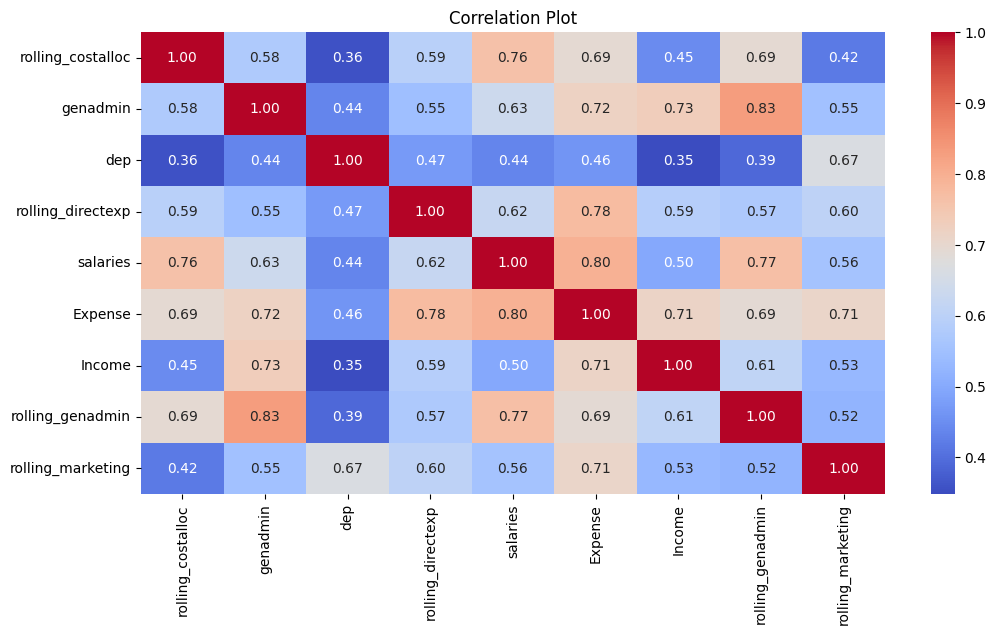

In [ ]:
only_corr=df[['rolling_costalloc','genadmin','dep','rolling_directexp','salaries','Expense','Income','rolling_genadmin','rolling_marketing']]

correlation_matrix = only_corr.corr()


plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot')
plt.show()

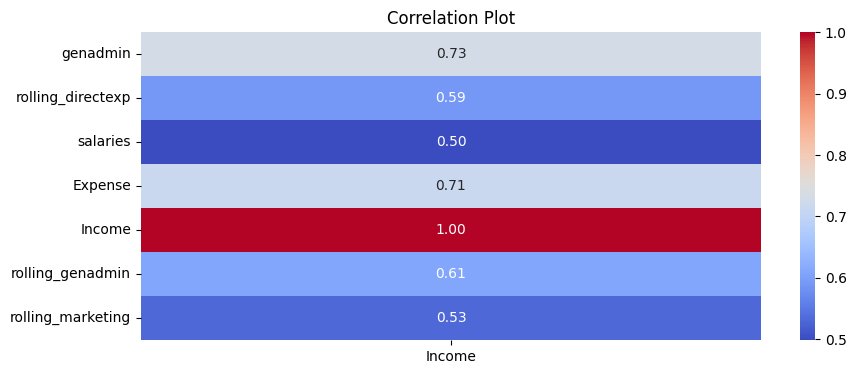

In [ ]:
filtered_correlations = correlation_matrix['Income'][(correlation_matrix['Income'] >= 0.49) | (correlation_matrix['Income'] <= -0.49)]

filtered_correlations = filtered_correlations.to_frame()
plt.figure(figsize=(10, 4))
sns.heatmap(filtered_correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot')
plt.show()

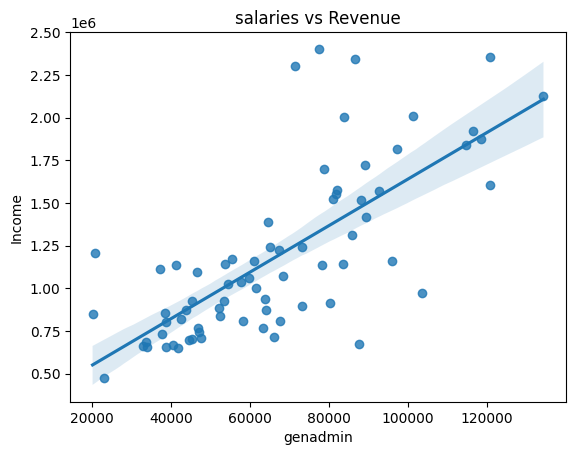

In [ ]:
sns.regplot(x=df['genadmin'], y=df['Income'])
plt.title("salaries vs Revenue")
plt.show()


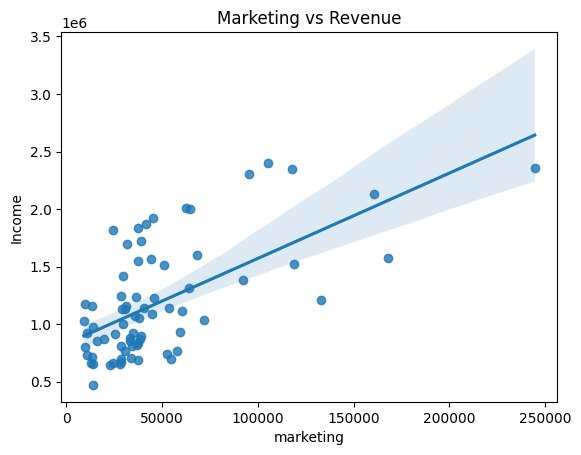

In [ ]:
sns.regplot(x=df['marketing'], y=df['Income'])
plt.title("Marketing vs Revenue")
plt.show()

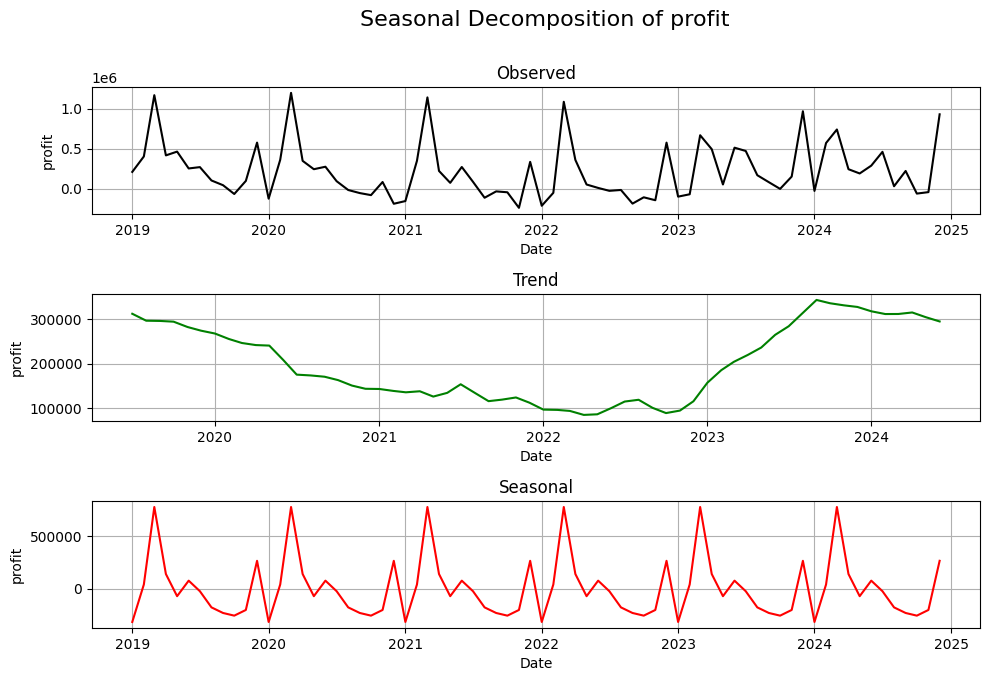

In [ ]:
decomposition = seasonal_decompose(df['profit'], model='additive',period=12,e )

plt.figure(figsize=(10,8))

# Plot observed data
plt.subplot(411)
plt.plot(decomposition.observed, color='black')
plt.title('Observed')
plt.xlabel('Date')
plt.ylabel('profit')
plt.grid(True)
print()
# Plot trend component
plt.subplot(412)
plt.plot(decomposition.trend, color='green')
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('profit')
plt.grid(True)

# Plot seasonal component
plt.subplot(413)
plt.plot(decomposition.seasonal, color='red')
plt.title('Seasonal')
plt.xlabel('Date')
plt.ylabel('profit')
plt.grid(True)

# Plot residual component
# plt.subplot(414)
# plt.plot(decomposition.resid, color='purple')
# plt.title('Residual')
# plt.xlabel('Date')
# plt.ylabel('Expense')
# plt.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.suptitle('Seasonal Decomposition of profit', fontsize=16,y=1.05,x=0.55)
plt.show()


In [ ]:
df.columns

Index(['costalloc', 'dep', 'directexp', 'genadmin', 'marketing', 'otherinco',
       'revenue', 'salaries', 'Income', 'Expense', 'Profit', 'profit', 'Year',
       'rolling_genadmin', 'rolling_marketing', 'rolling_costalloc',
       'rolling_directexp'],
      dtype='object')

In [ ]:
# from plotly.subplots import make_subplots

# # Create a 2x1 subplot grid
# fig = make_subplots(rows=len(df1.columns) // 2 + (len(df1.columns) % 2), cols=2,  # Adjust rows and columns as needed
#                     subplot_titles=[f"Time Series Data for {column}" for column in df1.columns])  # Set subplot titles

# # Counter for iterating through subplots
# subplot_index = 1

# for column in df1.columns:
#     # Add trace to the appropriate subplot
#     row = (subplot_index - 1) // 2 + 1
#     col = (subplot_index - 1) % 2 + 1

#     fig.add_trace(go.Scatter(
#         x=df1.index,
#         y=df1[column],
#         mode='lines',
#         name=column,
#         line=dict(color='blue')
#     ), row=row, col=col)

#     # Increment subplot index
#     subplot_index += 1

# # Update layout for the entire figure
# fig.update_layout(
#     template="plotly_white",
#     title_font=dict(size=18),
#     xaxis=dict(showgrid=True),
#     yaxis=dict(showgrid=True),
#     height=400 * (len(df1.columns) // 2 + (len(df1.columns) % 2)),  # Adjust height based on number of rows
#     width=1200,   # Adjust width for two columns
#     showlegend=True  # Show legend if needed
# )

# # Show the plot
# fig.show()

In [ ]:
# year_income = df.groupby(['Year']).agg({'Income': 'sum','costalloc':'sum','dep':'sum', 'directexp':'sum', 'genadmin':'sum', 'marketing':'sum', 'salaries':'sum', 'Expense':'sum','profit':'sum'}).reset_index()
# year_income

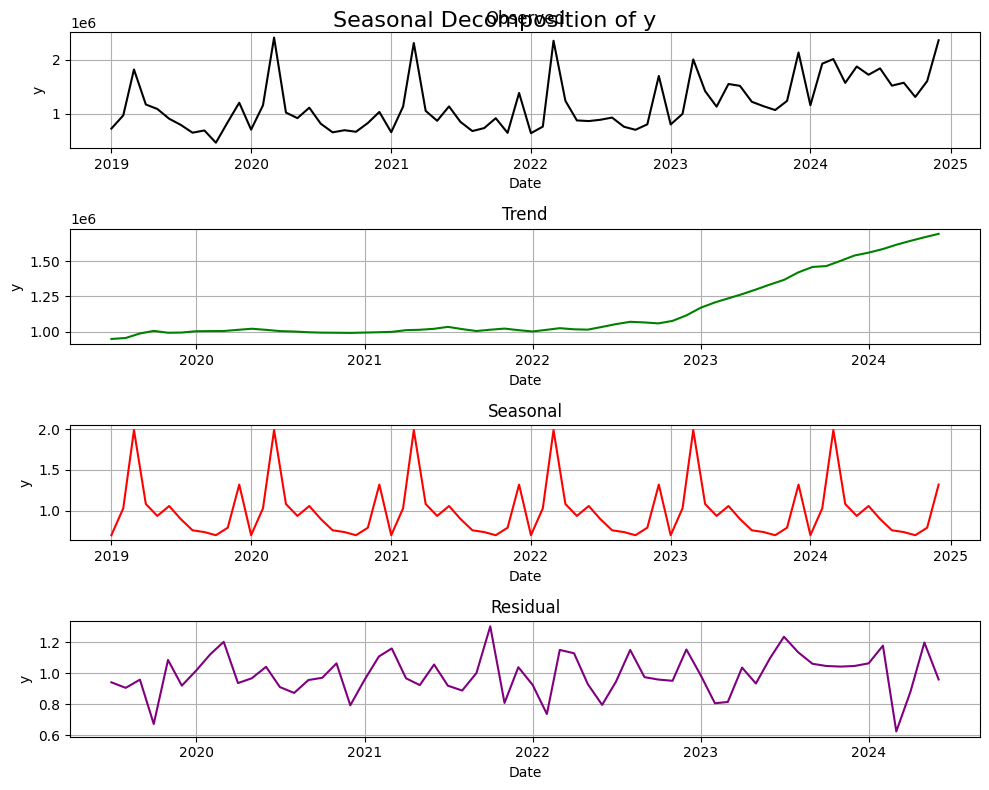

In [ ]:
decom=df.copy()
# decom.set_index('ds',inplace=True)
# decom
decomposition = seasonal_decompose(decom['Income'], model='multiplicative', period=12)

plt.figure(figsize=(10, 8))

# Plot observed data
plt.subplot(411)
plt.plot(decomposition.observed, color='black')
plt.title('Observed')
plt.xlabel('Date')
plt.ylabel('y')
plt.grid(True)

# Plot trend component
plt.subplot(412)
plt.plot(decomposition.trend, color='green')
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('y')
plt.grid(True)

# Plot seasonal component
plt.subplot(413)
plt.plot(decomposition.seasonal, color='red')
plt.title('Seasonal')
plt.xlabel('Date')
plt.ylabel('y')
plt.grid(True)

# Plot residual component
plt.subplot(414)
plt.plot(decomposition.resid, color='purple')
plt.title('Residual')
plt.xlabel('Date')
plt.ylabel('y')
plt.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.suptitle('Seasonal Decomposition of y', fontsize=16)
plt.show()

In [ ]:
df = df[['Income','Expense','costalloc','dep', 'directexp', 'genadmin', 'marketing', 'salaries', 'profit','rolling_costalloc','rolling_directexp','rolling_genadmin','rolling_marketing','Year']]

df

Income    Expense  costalloc      dep  directexp  genadmin  \
Date                                                                        
2019-01-01   731708.0   523610.0   236490.0   1388.0    26878.0   37785.0   
2019-02-01   973686.0   572182.0   236490.0   1274.0    38531.0  103496.0   
2019-03-01  1816719.0   647562.0   236490.0   1780.0   116953.0   97181.0   
2019-04-01  1173693.0   758632.0   236490.0   1938.0   251199.0   55616.0   
2019-05-01  1092071.0   629731.0   236490.0   2142.0   125882.0   46732.0   
...               ...        ...        ...      ...        ...       ...   
2024-08-01  1519958.0  1491367.0   431713.0   5185.0   244815.0   81046.0   
2024-09-01  1573198.0  1353097.0   295625.0   5004.0   220501.0   81970.0   
2024-10-01  1312045.0  1375335.0   337300.0   5099.0   253219.0   85905.0   
2024-11-01  1602993.0  1647936.0   340753.0  41416.0   431107.0  120648.0   
2024-12-01  2353545.0  1424353.0   223276.0  45719.0   391259.0  120648.0   

            marketing  salaries     profit  rolling_costalloc  \
Date                                                            
2019-01-01    10959.0  446600.0   208098.0             236490   
2019-02-01    14055.0  414826.0   401504.0             236490   
2019-03-01    24668.0  406980.0  1169157.0             236490   
2019-04-01    10087.0  439792.0   415061.0             236490   
2019-05-01    44688.0  410287.0   462340.0             236490   
...               ...       ...        ...                ...   
2024-08-01   118821.0  609787.0    28591.0             413395   
2024-09-01   167816.0  582181.0   220101.0             361187   
2024-10-01    64322.0  629490.0   -63290.0             354879   
2024-11-01    68155.0  645857.0   -44943.0             324559   
2024-12-01   244458.0  611418.0   929192.0             300443   

            rolling_directexp  rolling_genadmin  rolling_marketing  Year  
Date                                                                      
2019-01-01              60787             79487              21654  2019  
2019-02-01              60787             79487              21654  2019  
2019-03-01              60787             79487              21654  2019  
2019-04-01             135561             85431              21654  2019  
2019-05-01             164678             66509              21654  2019  
...                       ...               ...                ...   ...  
2024-08-01             244064             94966              57350  2024  
2024-09-01             234760             92540              74885  2024  
2024-10-01             239511             82973              78192  2024  
2024-11-01             301609             96174              82574  2024  
2024-12-01             358528            109067             116832  2024  

[72 rows x 14 columns]

In [ ]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds','Income':'y'},inplace=True)
main=df.copy()
df

<ipython-input-44-d28f30092060>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ds          y    Expense  costalloc      dep  directexp  genadmin  \
0  2019-01-01   731708.0   523610.0   236490.0   1388.0    26878.0   37785.0   
1  2019-02-01   973686.0   572182.0   236490.0   1274.0    38531.0  103496.0   
2  2019-03-01  1816719.0   647562.0   236490.0   1780.0   116953.0   97181.0   
3  2019-04-01  1173693.0   758632.0   236490.0   1938.0   251199.0   55616.0   
4  2019-05-01  1092071.0   629731.0   236490.0   2142.0   125882.0   46732.0   
..        ...        ...        ...        ...      ...        ...       ...   
67 2024-08-01  1519958.0  1491367.0   431713.0   5185.0   244815.0   81046.0   
68 2024-09-01  1573198.0  1353097.0   295625.0   5004.0   220501.0   81970.0   
69 2024-10-01  1312045.0  1375335.0   337300.0   5099.0   253219.0   85905.0   
70 2024-11-01  1602993.0  1647936.0   340753.0  41416.0   431107.0  120648.0   
71 2024-12-01  2353545.0  1424353.0   223276.0  45719.0   391259.0  120648.0   

    marketing  salaries     profit  rolling_costalloc  rolling_directexp  \
0     10959.0  446600.0   208098.0             236490              60787   
1     14055.0  414826.0   401504.0             236490              60787   
2     24668.0  406980.0  1169157.0             236490              60787   
3     10087.0  439792.0   415061.0             236490             135561   
4     44688.0  410287.0   462340.0             236490             164678   
..        ...       ...        ...                ...                ...   
67   118821.0  609787.0    28591.0             413395             244064   
68   167816.0  582181.0   220101.0             361187             234760   
69    64322.0  629490.0   -63290.0             354879             239511   
70    68155.0  645857.0   -44943.0             324559             301609   
71   244458.0  611418.0   929192.0             300443             358528   

    rolling_genadmin  rolling_marketing  Year  
0              79487              21654  2019  
1              79487              21654  2019  
2              79487              21654  2019  
3              85431              21654  2019  
4              66509              21654  2019  
..               ...                ...   ...  
67             94966              57350  2024  
68             92540              74885  2024  
69             82973              78192  2024  
70             96174              82574  2024  
71            109067             116832  2024  

[72 rows x 15 columns]

In [ ]:
df.isna().sum()

ds                   0
y                    0
Expense              0
costalloc            0
dep                  0
directexp            0
genadmin             0
marketing            0
salaries             0
profit               0
rolling_costalloc    0
rolling_directexp    0
rolling_genadmin     0
rolling_marketing    0
Year                 0
dtype: int64

In [ ]:
numeric_df = df.select_dtypes(include=['number'])
negative_counts = (numeric_df < 0).sum()
negative_counts

y                     0
Expense               0
costalloc             0
dep                   0
directexp             0
genadmin              0
marketing             0
salaries              0
profit               24
rolling_costalloc     0
rolling_directexp     0
rolling_genadmin      0
rolling_marketing     0
Year                  0
dtype: int64

In [ ]:
df['march_effect'] = df['ds'].apply(lambda x:
                                     -1 if (x.year == 2025 and x.month == 3) else
                                    -1 if (x.year == 2024 and x.month == 3) else
                                    -1 if (x.year == 2023 and x.month == 3) else 0)#


df['dec_effect'] = df['ds'].apply(lambda x:
                                   1 if (x.year in [2024, 2025] and x.month == 12) else
                                  (0.50 if (x.year == 2023 and x.month == 12) else 0 ))




df.tail(20)

<ipython-input-47-443eb6d22473>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ds          y    Expense  costalloc      dep  directexp  genadmin  \
52 2023-05-01  1134641.0  1083770.0   276130.0   3344.0   238226.0   78347.0   
53 2023-06-01  1550512.0  1039009.0   261486.0   3358.0   172946.0   81870.0   
54 2023-07-01  1516340.0  1046035.0   259932.0   3738.0   168958.0   88003.0   
55 2023-08-01  1223877.0  1057198.0   239428.0   4043.0   203705.0   67261.0   
56 2023-09-01  1141278.0  1062157.0   260683.0   3959.0   175566.0   83673.0   
57 2023-10-01  1072270.0  1076581.0   317116.0   4122.0   183750.0   68506.0   
58 2023-11-01  1239509.0  1089815.0   308835.0   4307.0   166100.0   65227.0   
59 2023-12-01  2129048.0  1161672.0   169814.0   4417.0   276942.0  134271.0   
60 2024-01-01  1160335.0  1190465.0   309107.0   4412.0   170497.0   95891.0   
61 2024-02-01  1923737.0  1353894.0   278350.0   4415.0   210131.0  116380.0   
62 2024-03-01  2008474.0  1269232.0   292040.0   5350.0   204706.0  101166.0   
63 2024-04-01  1570761.0  1328849.0   303792.0   4627.0   217583.0   92660.0   
64 2024-05-01  1871670.0  1682984.0   317972.0   4982.0   579904.0  118383.0   
65 2024-06-01  1720202.0  1433588.0   452248.0   5017.0   248412.0   89247.0   
66 2024-07-01  1837180.0  1377737.0   356225.0   5185.0   238966.0  114606.0   
67 2024-08-01  1519958.0  1491367.0   431713.0   5185.0   244815.0   81046.0   
68 2024-09-01  1573198.0  1353097.0   295625.0   5004.0   220501.0   81970.0   
69 2024-10-01  1312045.0  1375335.0   337300.0   5099.0   253219.0   85905.0   
70 2024-11-01  1602993.0  1647936.0   340753.0  41416.0   431107.0  120648.0   
71 2024-12-01  2353545.0  1424353.0   223276.0  45719.0   391259.0  120648.0   

    marketing  salaries    profit  rolling_costalloc  rolling_directexp  \
52    30666.0  457057.0   50871.0             254680             282994   
53    37488.0  481861.0  511503.0             259767             175978   
54    50874.0  474530.0  470305.0             265849             193376   
55    45799.0  496962.0  166679.0             253615             181869   
56    53692.0  484584.0   79121.0             253347             182743   
57    35963.0  467124.0   -4311.0             272409             187673   
58    36708.0  508638.0  149694.0             295544             175138   
59   160525.0  415703.0  967376.0             265255             208930   
60    31549.0  579009.0  -30130.0             262585             204513   
61    45359.0  699259.0  569843.0             252423             219190   
62    62603.0  603367.0  739242.0             293165             195111   
63    44478.0  665709.0  241912.0             291394             210806   
64    41866.0  619877.0  188686.0             304601             334064   
65    38908.0  599756.0  286614.0             358004             348633   
66    37424.0  625331.0  459443.0             375481             355760   
67   118821.0  609787.0   28591.0             413395             244064   
68   167816.0  582181.0  220101.0             361187             234760   
69    64322.0  629490.0  -63290.0             354879             239511   
70    68155.0  645857.0  -44943.0             324559             301609   
71   244458.0  611418.0  929192.0             300443             358528   

    rolling_genadmin  rolling_marketing  Year  march_effect  dec_effect  
52             83854              35843  2023             0         0.0  
53             83192              36825  2023             0         0.0  
54             82740              40541  2023             0         0.0  
55             79044              43229  2023             0         0.0  
56             79645              41372  2023             0         0.0  
57             73146              42413  2023             0         0.0  
58             72468              43420  2023             0         0.0  
59             89334              63926  2023             0         0.5  
60             98463              60706  2024             0         0.0  
61            

In [ ]:
train_cutoff_date = "2024-03-01"

df_train = df[df['ds'] <= train_cutoff_date]
df_test = df[df['ds'] > train_cutoff_date]



In [ ]:
train = df_train
test = df_test

columns = [
     'dep', 'directexp', 'genadmin',
    'salaries','y'
     ]

for i in columns:
  train[i]=np.log1p(train[i])
  test[i]=np.log1p(test[i])


train.tail(20)

<ipython-input-49-b5d0b9ba623c>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-49-b5d0b9ba623c>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ds          y    Expense  costalloc       dep  directexp  \
43 2022-08-01  13.747171   951761.0   240219.0  8.129175  11.915526   
44 2022-09-01  13.548224   954266.0   255381.0  8.137103  12.119507   
45 2022-10-01  13.472141   819162.0   253965.0  8.246696  11.167360   
46 2022-11-01  13.604326   955989.0   264446.0  8.214194  12.027107   
47 2022-12-01  14.344835  1122919.0   308171.0  8.239065  12.481687   
48 2023-01-01  13.601706   908951.0   262969.0  8.188133  11.676650   
49 2023-02-01  13.817539  1073915.0   281899.0  7.936660  12.169269   
50 2023-03-01  14.509596  1334643.0   246225.0  8.026497  13.110279   
51 2023-04-01  14.165848   926496.0   241687.0  8.033009  11.667910   
52 2023-05-01  13.941828  1083770.0   276130.0  8.115222  12.380979   
53 2023-06-01  14.254096  1039009.0   261486.0  8.119399  12.060740   
54 2023-07-01  14.231811  1046035.0   259932.0  8.226573  12.037411   
55 2023-08-01  14.017535  1057198.0   239428.0  8.304990  12.224433   
56 2023-09-01  13.947660  1062157.0   260683.0  8.283999  12.075776   
57 2023-10-01  13.885289  1076581.0   317116.0  8.324336  12.121337   
58 2023-11-01  14.030227  1089815.0   308835.0  8.368229  12.020351   
59 2023-12-01  14.571186  1161672.0   169814.0  8.393442  12.531567   
60 2024-01-01  13.964220  1190465.0   309107.0  8.392310  12.046479   
61 2024-02-01  14.469781  1353894.0   278350.0  8.392990  12.255491   
62 2024-03-01  14.512886  1269232.0   292040.0  8.585039  12.229335   

     genadmin  marketing   salaries    profit  rolling_costalloc  \
43  11.062222    59253.0  12.984507  -17819.0             241507   
44  11.056651    30618.0  12.943411 -188813.0             246683   
45  10.772708    34065.0  12.921074 -109787.0             249855   
46  11.123152    34621.0  12.943918 -146365.0             257930   
47  11.275759    31599.5  13.103415  574865.0             275527   
48  10.974283    28578.0  12.989214 -101446.0             278528   
49  11.027361    29673.0  13.132791  -71885.0             284346   
50  11.336892    64834.0  13.000589  667234.0             263697   
51  11.400428    29713.0  13.007839  493050.0             256603   
52  11.268916    30666.0  13.032566   50871.0             254680   
53  11.312900    37488.0  13.085413  511503.0             259767   
54  11.385138    50874.0  13.070082  470305.0             265849   
55  11.116351    45799.0  13.116271  166679.0             253615   
56  11.334684    53692.0  13.091048   79121.0             253347   
57  11.134691    35963.0  13.054352   -4311.0             272409   
58  11.085644    36708.0  13.139494  149694.0             295544   
59  11.807623   160525.0  12.937729  967376.0             265255   
60  11.470978    31549.0  13.269075  -30130.0             262585   
61  11.664625    45359.0  13.457778  569843.0             252423   
62  11.524528    62603.0  13.310283  739242.0             293165   

    rolling_directexp  rolling_genadmin  rolling_marketing  Year  \
43             143451             66967              49733  2022   
44             159684             66724              35157  2022   
45             134588             58260              36037  2022   
46             140473             59594              36252  2022   
47             167158             64768              38249  2022   
48             182827             68319              36455  2023   
49             191342             66257              31525  2023   
50             268184             67915              37228  2023   
51             267842             78250              36503  2023   
52             282994             83854              35843  2023   
53             175978             83192              36825  2023   
54             193376             82740              40541  2023   
55             181869             79044              43229  2023   
56             182743             79645              41372  2023   
57             187673             73146              42413  2023   
58

In [ ]:
test.tail(10)

ds          y    Expense  costalloc        dep  directexp  \
63 2024-04-01  14.267071  1328849.0   303792.0   8.439880  12.290340   
64 2024-05-01  14.442342  1682984.0   317972.0   8.513787  13.270620   
65 2024-06-01  14.357953  1433588.0   452248.0   8.520787  12.422848   
66 2024-07-01  14.423743  1377737.0   356225.0   8.553718  12.384081   
67 2024-08-01  14.234194  1491367.0   431713.0   8.553718  12.408262   
68 2024-09-01  14.268622  1353097.0   295625.0   8.518193  12.303662   
69 2024-10-01  14.087098  1375335.0   337300.0   8.536996  12.442014   
70 2024-11-01  14.287384  1647936.0   340753.0  10.631447  12.974114   
71 2024-12-01  14.671434  1424353.0   223276.0  10.730291  12.877128   

     genadmin  marketing   salaries    profit  rolling_costalloc  \
63  11.436703    44478.0  13.408609  241912.0             291394   
64  11.681689    41866.0  13.337278  188686.0             304601   
65  11.399174    38908.0  13.304280  286614.0             358004   
66  11.649264    37424.0  13.346038  459443.0             375481   
67  11.302785   118821.0  13.320867   28591.0             413395   
68  11.314121   167816.0  13.274538  220101.0             361187   
69  11.361009    64322.0  13.352667  -63290.0             354879   
70  11.700641    68155.0  13.378335  -44943.0             324559   
71  11.700641   244458.0  13.323538  929192.0             300443   

    rolling_directexp  rolling_genadmin  rolling_marketing  Year  \
63             210806            103402              63537  2024   
64             334064            104069              64396  2024   
65             348633            100096              44127  2024   
66             355760            107412              45106  2024   
67             244064             94966              57350  2024   
68             234760             92540              74885  2024   
69             239511             82973              78192  2024   
70             301609             96174              82574  2024   
71             358528            109067             116832  2024   

    march_effect  dec_effect  
63             0         0.0  
64             0         0.0  
65             0         0.0  
66             0         0.0  
67             0         0.0  
68             0         0.0  
69             0         0.0  
70             0         0.0  
71             0         1.0

In [ ]:
# from sklearn.preprocessing import StandardScaler
# test =[
#      'dep', 'directexp', 'genadmin', 'marketing',
#     'salaries', 'Expense'
# ]
# scaler = StandardScaler()
# df_test[test] = scaler.fit_transform(df_test[test])
# df_test

In [ ]:
# scaler = StandardScaler()
# for col in df_train.columns[1:]:
#   df_train[col] = scaler.fit_transform(df_train[[col]])
# df_train



In [ ]:
# param_grid = {
#     'changepoint_prior_scale': [0.02, 0.05,0.08,0.1,0.2],
#     'seasonality_prior_scale': [0.5, 1.0, 1.5,2.0,2.5],
#     'seasonality_mode': ['additive', 'multiplicative'],
#     'yearly_seasonality': [True, False],



# }

# # Define your regressor columns
# regressor_columns = [
#     'dep', 'directexp', 'genadmin', 'marketing',
#     'salaries'
# ]

# # Function to train Prophet model and perform cross-validation
# def tune_prophet(params):
#     # Initialize Prophet model with the current set of hyperparameters
#     model = Prophet(
#         yearly_seasonality=params['yearly_seasonality'],
#         changepoint_prior_scale=params['changepoint_prior_scale'],
#         seasonality_prior_scale=params['seasonality_prior_scale'],
#         seasonality_mode=params['seasonality_mode'],

#     )

#     # Add each regressor to the Prophet model
#     for regressor in regressor_columns:
#         model.add_regressor(regressor)

#     # Fit the model on the training data
#     model.fit(df_train)

#     # Perform cross-validation with a specific horizon and period
#     df_cv = cross_validation(
#         model,
#         initial='1440 days',    # Initial training period (e.g., 60 months = 1800 days)
#         period='30 days',       # Period of 1 month (30 days)
#         horizon='180 days',     # Forecast horizon (e.g., 6 months = 180 days)
#         parallel="processes"    # This allows parallelization to speed up the process
#     )

#     # Evaluate performance using MAPE, RMSE, MAE, etc.
#     df_performance = performance_metrics(df_cv)

#     # Get the MAPE score (you can use other metrics if needed)
#     return df_performance['mape'].mean()

# # Initialize variables for tracking the best results
# best_mape = float('inf')
# best_params = {}

# # Grid search for hyperparameters
# for yearly_seasonality in param_grid['yearly_seasonality']:
#   for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
#     for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
#       for seasonality_mode in param_grid['seasonality_mode']:


#                     params = {
#                         'yearly_seasonality': yearly_seasonality,
#                         'changepoint_prior_scale': changepoint_prior_scale,
#                         'seasonality_prior_scale': seasonality_prior_scale,
#                         'seasonality_mode': seasonality_mode

#                     }

#                     # Train and evaluate Prophet with the current hyperparameters
#                     mape = tune_prophet(params)

#                     # Track the best parameters based on MAPE
#                     if mape < best_mape:
#                         best_mape = mape
#                         best_params = params

# # Print the best hyperparameters and performance
# print("Best hyperparameters found: ", best_params)
# print("Best MAPE: ", best_mape)

In [ ]:
# # Best hyperparameters found:  {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'growth': 'linear', 'interval_width': 0.8}
# # Best MAPE:  0.2428871225451203065

# regressor_columns = [
#      'dep', 'directexp', 'genadmin', 'marketing',
#     'salaries']


# prophet = Prophet(
#     yearly_seasonality=True,
#     weekly_seasonality=False,
#     daily_seasonality=False,
#     growth='linear',
#     seasonality_mode='additive',
#     seasonality_prior_scale= 0.1,
#     changepoint_prior_scale=0.1,
#     interval_width=0.8
# )
# #prophet.add_seasonality(name='custom_yearly', period=365.25, fourier_order=2)
# # changepoints = ['2023-01-01', '2023-06-01', '2023-12-01']
# # prophet.changepoints = pd.to_datetime(changepoints)


# for regressor in regressor_columns:
#   # if regressor == "profit_margin" :
#   #   prophet.add_regressor(regressor,prior_scale=5)
#   # else:
#       prophet.add_regressor(regressor)


# prophet.fit(df_train)

# future = prophet.make_future_dataframe(periods=len(df_test), freq='MS')

# for regressor in regressor_columns:
#     # Assuming df_test contains future regressor values
#     future[regressor] = pd.concat([df_train[regressor], df_test[regressor]]).reset_index(drop=True)

# forecast = prophet.predict(future)
# future


In [ ]:
# Best hyperparameters found:  {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'growth': 'linear', 'interval_width': 0.8}
# Best MAPE:  0.2428871225451203065

regressor_columns = ['directexp','genadmin','salaries','march_effect']

# changepoints = ['2024-03-01'', '2024-12-01']
prophet = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    growth='linear',
    seasonality_mode='additive',
    seasonality_prior_scale= 0.01,
    changepoint_prior_scale=0.01,
    interval_width=0.8,

    # changepoints=changepoints
)
prophet.add_seasonality(name='custom_yearly', period=365.25, fourier_order=4,prior_scale=0.5)


for regressor in regressor_columns:
  if regressor == "march_effect" :
    prophet.add_regressor(regressor,prior_scale=0.5)
  # elif regressor == "dec_effect" :
  #   prophet.add_regressor(regressor,prior_scale=0.05)
  else:
    prophet.add_regressor(regressor)


prophet.fit(train)
future = prophet.make_future_dataframe(periods=len(test), freq='MS')


for regressor in regressor_columns:
    future[regressor] = pd.concat([train[regressor], test[regressor]]).reset_index(drop=True)


forecast = prophet.predict(future)

for i in forecast.columns[1:]:
  if i not in ['march_effect']:  # Exclude these columns
    forecast[i] = np.expm1(forecast[i])
# forecast[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]

# Convert back to original scale
# forecast['yhat'] = np.expm1(forecast['yhat'])
# forecast['yhat_lower'] = np.expm1(forecast['yhat_lower'])
# forecast['yhat_upper'] = np.expm1(forecast['yhat_upper'])

# Display forecast results

forecast



DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/84eez9q4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/wakicpsn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34410', 'data', 'file=/tmp/tmp9lov577b/84eez9q4.json', 'init=/tmp/tmp9lov577b/wakicpsn.json', 'output', 'file=/tmp/tmp9lov577b/prophet_modelr0pz_n7f/prophet_model-20250305035458.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:54:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds         trend    yhat_lower    yhat_upper   trend_lower  \
0  2019-01-01  9.513935e+05  5.068279e+05  7.290776e+05  9.513935e+05   
1  2019-02-01  9.519896e+05  8.350641e+05  1.185239e+06  9.519896e+05   
2  2019-03-01  9.525284e+05  1.595630e+06  2.242965e+06  9.525284e+05   
3  2019-04-01  9.531252e+05  1.091841e+06  1.554658e+06  9.531252e+05   
4  2019-05-01  9.537032e+05  7.016793e+05  9.907680e+05  9.537032e+05   
..        ...           ...           ...           ...           ...   
67 2024-08-01  1.398051e+06  1.150466e+06  1.638132e+06  1.392812e+06   
68 2024-09-01  1.417688e+06  1.153568e+06  1.593982e+06  1.410739e+06   
69 2024-10-01  1.436954e+06  9.814760e+05  1.376242e+06  1.427969e+06   
70 2024-11-01  1.457137e+06  1.557860e+06  2.172455e+06  1.446184e+06   
71 2024-12-01  1.476939e+06  2.001552e+06  2.816914e+06  1.463655e+06   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   9.513935e+05       -0.356019             -0.356019             -0.356019   
1   9.519896e+05        0.036462              0.036462              0.036462   
2   9.525284e+05        0.982434              0.982434              0.982434   
3   9.531252e+05        0.364141              0.364141              0.364141   
4   9.537032e+05       -0.118843             -0.118843             -0.118843   
..           ...             ...                   ...                   ...   
67  1.403052e+06       -0.033266             -0.033266             -0.033266   
68  1.424463e+06       -0.039283             -0.039283             -0.039283   
69  1.445763e+06       -0.188750             -0.188750             -0.188750   
70  1.467984e+06        0.254478              0.254478              0.254478   
71  1.490386e+06        0.604010              0.604010              0.604010   

    custom_yearly  ...  march_effect  march_effect_lower  march_effect_upper  \
0       -0.182139  ...      0.009355            0.009399            0.009399   
1        0.069246  ...      0.009355            0.009399            0.009399   
2        0.833579  ...      0.009355            0.009399            0.009399   
3        0.269870  ...      0.009355            0.009399            0.009399   
4       -0.082851  ...      0.009355            0.009399            0.009399   
..            ...  ...           ...                 ...                 ...   
67      -0.177178  ...      0.009355            0.009399            0.009399   
68      -0.171308  ...      0.009355            0.009399            0.009399   
69      -0.320767  ...      0.009355            0.009399            0.009399   
70      -0.067773  ...      0.009355            0.009399            0.009399   
71       0.210210  ...      0.009355            0.009399            0.009399   

    salaries  salaries_lower  salaries_upper  multiplicative_terms  \
0   0.003815        0.003815        0.003815                   0.0   
1  -0.002325       -0.002325       -0.002325                   0.0   
2  -0.003908       -0.003908       -0.003908                   0.0   
3   0.002533        0.002533        0.002533                   0.0   
4  -0.003237       -0.003237       -0.003237                   0.0   
..       ...             ...             ...                   ...   
67  0.030142        0.030142        0.030142                   0.0   
68  0.026183        0.026183        0.026183                   0.0   
69  0.032869        0.032869        0.032869                   0.0   
70  0.035075        0.035075        0.035075                   0.0   
71  0.030371        0.030371        0.030371                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                          0.0                         0.0  6.126790e+05  
1                          0.0                         0.0  9.867007e+05  
2                          0.0                         0.0  1.888326e+06  
3                          0.0                         0.0  1.300198e+0

In [ ]:
# for col in forecast.columns[1:]:
# forecast[col] = scaler.inverse_transform(forecast[[col]])



# #forecast=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
# forecast


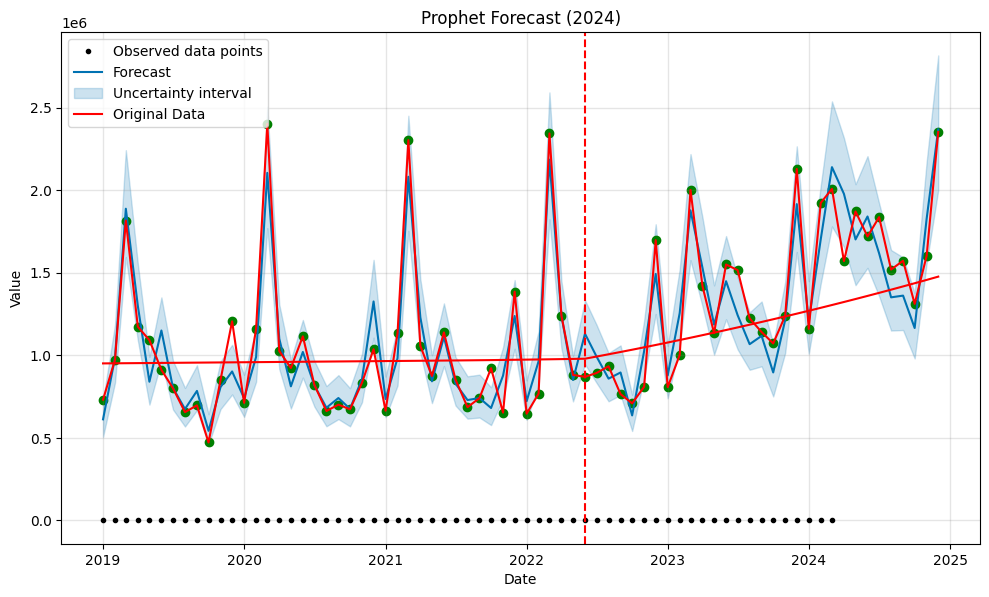

In [ ]:


fig = prophet.plot(forecast)
ax = fig.gca()
add_changepoints_to_plot(ax, prophet, forecast)

# Plot original data in RED with label
ax.plot(df['ds'], df['y'], 'r-', label='Original Data')

# # Add observed data points (black dots) with label
ax.scatter(df['ds'], df['y'], color='green')

ax.set_title("Prophet Forecast (2024)")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend(loc='upper left')

# Show plot
plt.show()



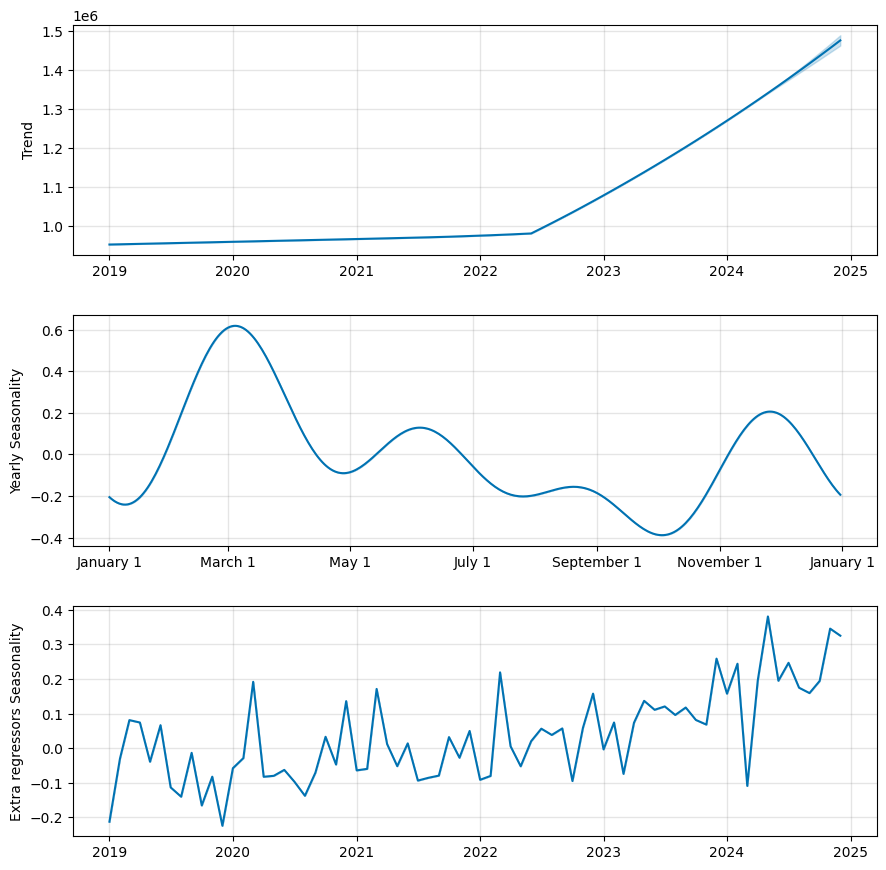

In [ ]:

fig = prophet.plot_components(forecast)

# Rename components
ax_list = fig.get_axes()
ax_list[0].set_ylabel("Trend")  # Trend component
ax_list[1].set_ylabel("Yearly Seasonality")  # Weekly seasonality
ax_list[2].set_ylabel("Extra regressors Seasonality")  # Yearly seasonality (if available)

# Remove x-axis names for each plot
for ax in ax_list:
    ax.set_xlabel("")

plt.show()

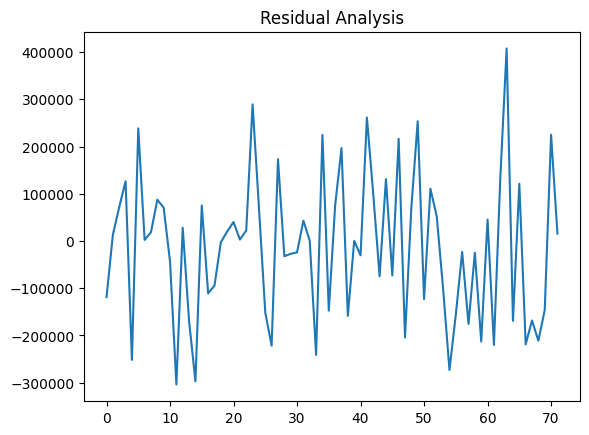

In [ ]:
residuals = forecast['yhat'] - df['y']
plt.plot(residuals) # Changed plot to pltc
plt.title("Residual Analysis") # Changed plot to plt
plt.show()

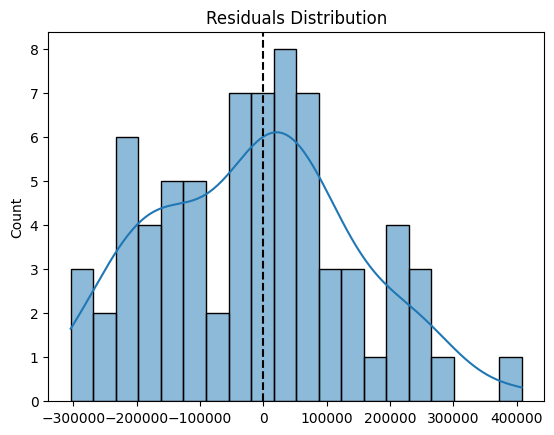

In [ ]:
sns.histplot(residuals, kde=True, bins=20)
plt.axvline(0, color='black', linestyle='--')  # Zero line
plt.title("Residuals Distribution")
plt.show()


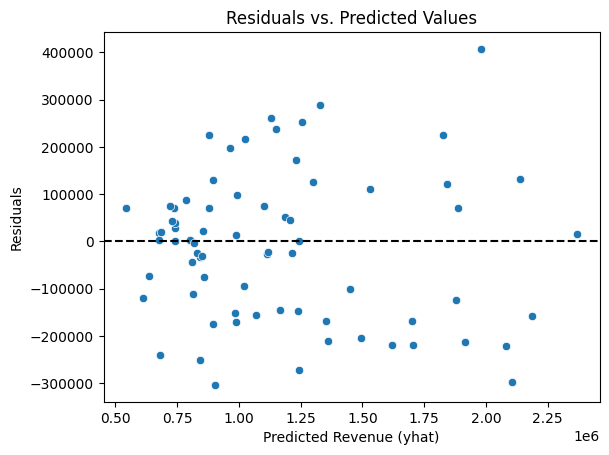

In [ ]:
sns.scatterplot(x=forecast['yhat'], y=residuals)
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Revenue (yhat)")
plt.ylabel("Residuals")
plt.show()


In [ ]:
# forecast.to_csv('forecast_results.csv', index=False)

In [ ]:
month=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
month=pd.concat([month,df[['y',"Expense"]]],axis=1)
month=month.rename(columns={'ds':"Date","yhat":"Forcasted","yhat_lower":"Lower","yhat_upper":"Upper",'y':"Revenue"})
month['Error']=month['Forcasted']-month['Revenue']
for col in month.columns[1:]:
  month[col]=month[col].astype('int')
total_year= month.resample('YE',on='Date').sum()
month=month.tail(10)
month



Date  Forcasted    Lower    Upper  Revenue  Expense   Error
62 2024-03-01    2140093  1780845  2538418  2008474  1269232  131619
63 2024-04-01    1978322  1657655  2317127  1570761  1328849  407561
64 2024-05-01    1702394  1425393  2036845  1871670  1682984 -169275
65 2024-06-01    1841281  1530245  2206809  1720202  1433588  121079
66 2024-07-01    1618251  1359084  1921565  1837180  1377737 -218928
67 2024-08-01    1351543  1150465  1638132  1519958  1491367 -168414
68 2024-09-01    1361996  1153567  1593982  1573198  1353097 -211201
69 2024-10-01    1165728   981476  1376242  1312045  1375335 -146316
70 2024-11-01    1827946  1557860  2172455  1602993  1647936  224953
71 2024-12-01    2369026  2001552  2816914  2353545  1424353   15481

In [ ]:
total_year["orginal_profit"]=total_year["Revenue"]-total_year["Expense"]
total_year["forecasted_profit"]=total_year["Forcasted"]-total_year["Expense"]

total_year

Forcasted     Lower     Upper   Revenue   Expense   Error  \
Date                                                                    
2019-12-31   11295226   9503155  13435635  11385105   7464809  -89875   
2020-12-31   11871688   9965433  14094389  12069601   9952168 -197908   
2021-12-31   12082683  10151142  14326268  12417470  10546368 -334780   
2022-12-31   13000279  10930332  15395038  12561695  11245536  438589   
2023-12-31   15634735  13170834  18621877  16238433  12860242 -603690   
2024-12-31   20265623  17043591  24095691  20454098  16928837 -188469   

            orginal_profit  forecasted_profit  
Date                                           
2019-12-31         3920296            3830417  
2020-12-31         2117433            1919520  
2021-12-31         1871102            1536315  
2022-12-31         1316159            1754743  
2023-12-31         3378191            2774493  
2024-12-31         3525261            3336786

In [ ]:
# month.describe()

In [ ]:
year = month.resample('Y',on='Date').sum()
year

<ipython-input-66-96942355ce19>:1: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



Forcasted     Lower     Upper   Revenue   Expense  Error
Date                                                                
2024-12-31   17356580  14598142  20618489  17370026  14384478 -13441

In [ ]:
year.describe()

Forcasted       Lower       Upper     Revenue     Expense    Error
count         1.0         1.0         1.0         1.0         1.0      1.0
mean   17356580.0  14598142.0  20618489.0  17370026.0  14384478.0 -13441.0
std           NaN         NaN         NaN         NaN         NaN      NaN
min    17356580.0  14598142.0  20618489.0  17370026.0  14384478.0 -13441.0
25%    17356580.0  14598142.0  20618489.0  17370026.0  14384478.0 -13441.0
50%    17356580.0  14598142.0  20618489.0  17370026.0  14384478.0 -13441.0
75%    17356580.0  14598142.0  20618489.0  17370026.0  14384478.0 -13441.0
max    17356580.0  14598142.0  20618489.0  17370026.0  14384478.0 -13441.0

In [ ]:
MAE = mean_absolute_error(month['Revenue'], month['Forcasted'])
print("mae:",MAE)
MSE = mean_squared_error(month['Revenue'], month['Forcasted'])
print("mse:",MSE)
MAPE = mean_absolute_percentage_error(month['Revenue'], month['Forcasted'])
print("mape:",MAPE)


mae: 181483.2
mse: 41989600042.8
mape: 0.11084741535565121


In [ ]:
MAE = mean_absolute_error(year['Revenue'], year['Forcasted'])
print("mae:",MAE)
MSE = mean_squared_error(year['Revenue'], year['Forcasted'])
print("mse:",MSE)
MAPE = mean_absolute_percentage_error(year['Revenue'], year['Forcasted'])
print("mape:",MAPE)


mae: 13446.0
mse: 180794916.0
mape: 0.0007740921055616152


In [ ]:
print("forecasted:",year['Forcasted'].sum())
print("Revenue:",year['Revenue'].sum())
print('Lower:',year['Lower'].sum())
print('Upper:',year['Upper'].sum())

forecasted: 17356580
Revenue: 17370026
Lower: 14598142
Upper: 20618489


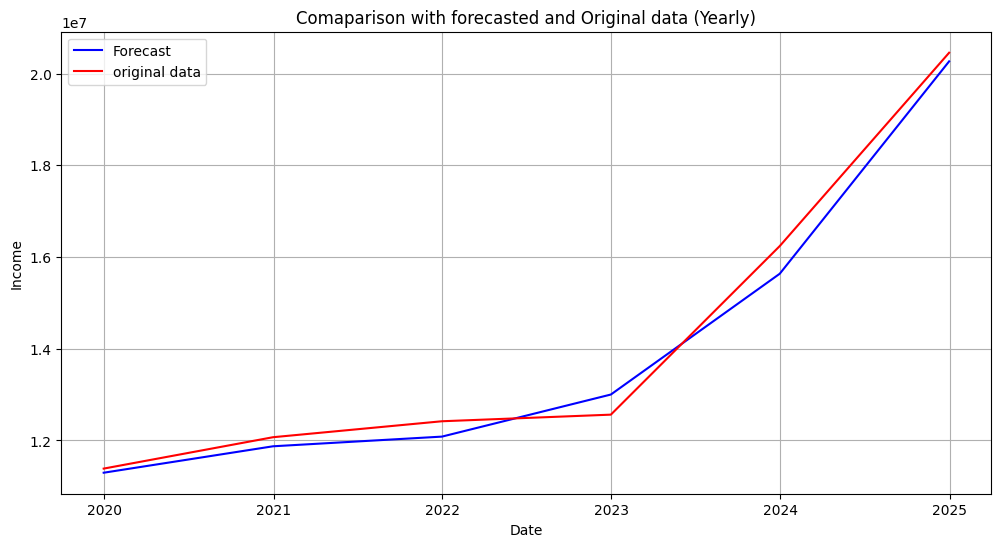

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(total_year.index, total_year['Forcasted'], label='Forecast', color='blue')
plt.plot(total_year.index, total_year['Revenue'], label='original data', color='red')

plt.xlabel('Date')
plt.ylabel('Income')
plt.title('Comaparison with forecasted and Original data (Yearly)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# df_cv = cross_validation(prophet, initial='1460 days', period='120 days', horizon='180 days')

In [ ]:
# data_performance=performance_metrics(df_cv)
# data_performance


# Expense Forecasting

In [ ]:
year = df.resample('Y',on="ds").sum()
year

<ipython-input-74-6367d6d2b900>:1: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



y     Expense  costalloc       dep  directexp   genadmin  \
ds                                                                              
2019-12-31  11385105.0   7464809.0  2837880.0   25248.0  1499697.0   607524.0   
2020-12-31  12069601.0   9952168.0  2393706.0   23792.0  1670410.0   669006.0   
2021-12-31  12417470.0  10546368.0  2489457.0   29164.0  2095355.0   573858.0   
2022-12-31  12561695.0  11245536.0  2986721.0   41292.0  1887194.0   759539.0   
2023-12-31  16238433.0  12860242.0  3126204.0   43822.0  2507509.0   960262.0   
2024-12-31  20454098.0  16928837.0  3938401.0  136411.0  3411100.0  1218550.0   

            marketing   salaries     profit  rolling_costalloc  \
ds                                                               
2019-12-31   345179.0  4987161.0  3920296.0            2837880   
2020-12-31   455434.0  4739820.0  2117433.0            2440757   
2021-12-31   545365.0  4813169.0  1871102.0            2461791   
2022-12-31   510144.5  5114248.0  1316159.0            2910217   
2023-12-31   604513.0  5617932.0  3378191.0            3203640   
2024-12-31   965759.0  7471041.0  3525261.0            3892116   

            rolling_directexp  rolling_genadmin  rolling_marketing   Year  \
ds                                                                          
2019-12-31            1442720            686205             271447  24228   
2020-12-31            1575662            633581             476255  24240   
2021-12-31            2162401            575507             527857  24252   
2022-12-31            1831285            738741             560639  24264   
2023-12-31            2498896            924164             489280  24276   
2024-12-31            3246549           1209155             810454  24288   

            march_effect  dec_effect  
ds                                    
2019-12-31             0         0.0  
2020-12-31             0         0.0  
2021-12-31             0         0.0  
2022-12-31             0         0.0  
2023-12-31            -1         0.5  
2024-12-31            -1         1.0

In [ ]:
df.set_index('ds', inplace=True)
df

y    Expense  costalloc      dep  directexp  genadmin  \
ds                                                                          
2019-01-01   731708.0   523610.0   236490.0   1388.0    26878.0   37785.0   
2019-02-01   973686.0   572182.0   236490.0   1274.0    38531.0  103496.0   
2019-03-01  1816719.0   647562.0   236490.0   1780.0   116953.0   97181.0   
2019-04-01  1173693.0   758632.0   236490.0   1938.0   251199.0   55616.0   
2019-05-01  1092071.0   629731.0   236490.0   2142.0   125882.0   46732.0   
...               ...        ...        ...      ...        ...       ...   
2024-08-01  1519958.0  1491367.0   431713.0   5185.0   244815.0   81046.0   
2024-09-01  1573198.0  1353097.0   295625.0   5004.0   220501.0   81970.0   
2024-10-01  1312045.0  1375335.0   337300.0   5099.0   253219.0   85905.0   
2024-11-01  1602993.0  1647936.0   340753.0  41416.0   431107.0  120648.0   
2024-12-01  2353545.0  1424353.0   223276.0  45719.0   391259.0  120648.0   

            marketing  salaries     profit  rolling_costalloc  \
ds                                                              
2019-01-01    10959.0  446600.0   208098.0             236490   
2019-02-01    14055.0  414826.0   401504.0             236490   
2019-03-01    24668.0  406980.0  1169157.0             236490   
2019-04-01    10087.0  439792.0   415061.0             236490   
2019-05-01    44688.0  410287.0   462340.0             236490   
...               ...       ...        ...                ...   
2024-08-01   118821.0  609787.0    28591.0             413395   
2024-09-01   167816.0  582181.0   220101.0             361187   
2024-10-01    64322.0  629490.0   -63290.0             354879   
2024-11-01    68155.0  645857.0   -44943.0             324559   
2024-12-01   244458.0  611418.0   929192.0             300443   

            rolling_directexp  rolling_genadmin  rolling_marketing  Year  \
ds                                                                         
2019-01-01              60787             79487              21654  2019   
2019-02-01              60787             79487              21654  2019   
2019-03-01              60787             79487              21654  2019   
2019-04-01             135561             85431              21654  2019   
2019-05-01             164678             66509              21654  2019   
...                       ...               ...                ...   ...   
2024-08-01             244064             94966              57350  2024   
2024-09-01             234760             92540              74885  2024   
2024-10-01             239511             82973              78192  2024   
2024-11-01             301609             96174              82574  2024   
2024-12-01             358528            109067             116832  2024   

            march_effect  dec_effect  
ds                                    
2019-01-01             0         0.0  
2019-02-01             0         0.0  
2019-03-01             0         0.0  
2019-04-01             0         0.0  
2019-05-01             0         0.0  
...                  ...         ...  
2024-08-01             0         0.0  
2024-09-01             0         0.0  
2024-10-01             0         0.0  
2024-11-01             0         0.0  
2024-12-01             0         1.0  

[72 rows x 16 columns]

In [ ]:
fig = go.Figure()


fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Expense'],
    mode='lines+markers',  #
    name='Expanse',
    line=dict(color='#FF6F61'),
    marker=dict(size=4, color='green', symbol='circle', line=dict(color='darkgreen', width=1))
))


fig.update_layout(
    title="Yearly Expenses",
    xaxis_title="Year",
    yaxis_title="Amount",
    width=800,
    height=500,
    title_font_size=16,
    legend=dict(title="Legend", x=4, y=4),
)


fig.show()

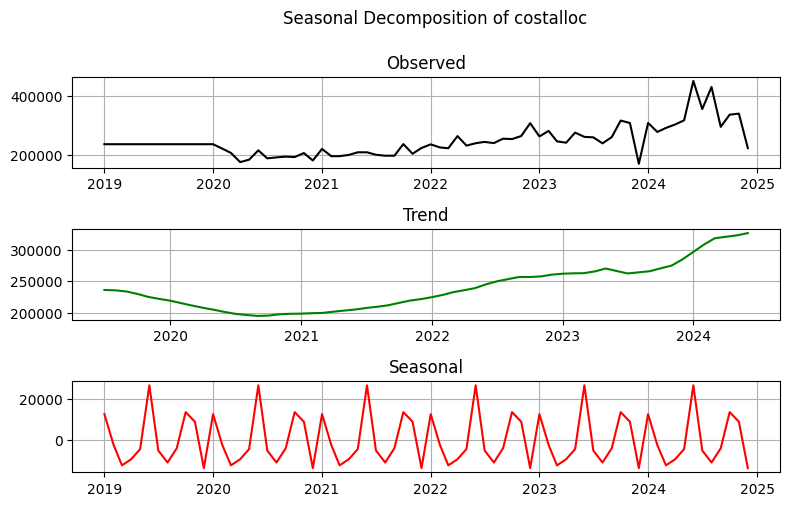

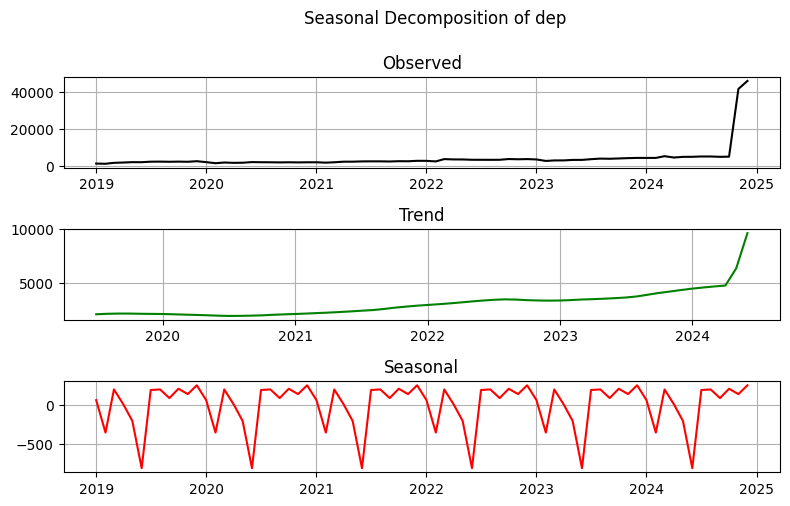

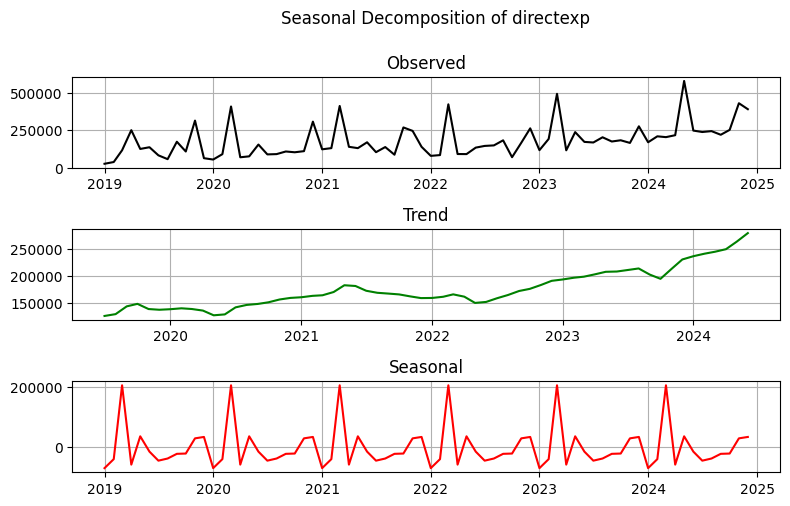

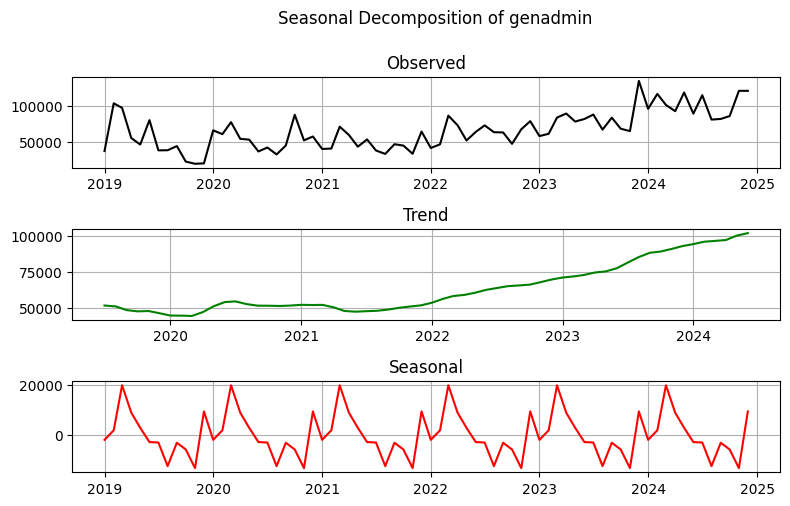

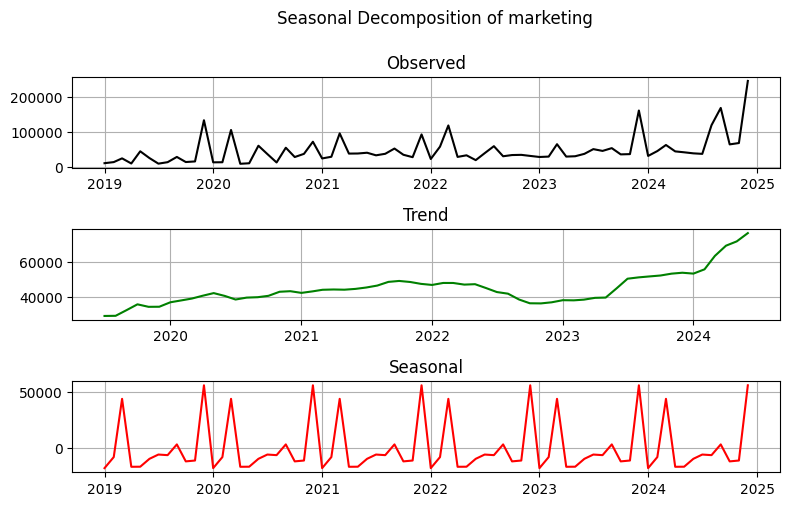

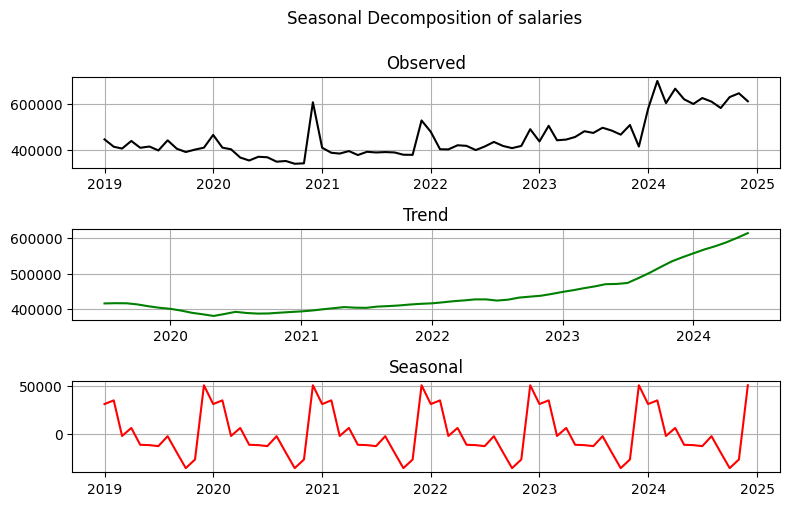

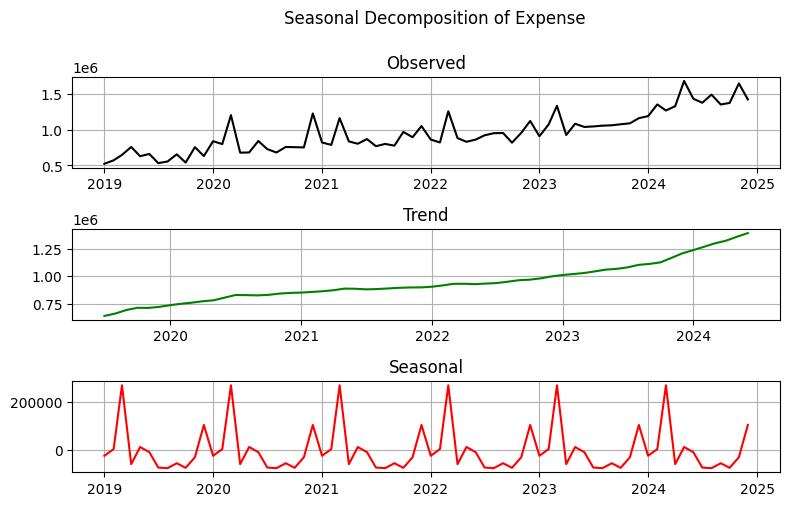

In [ ]:
new = [
     'Costalloc','depreciation', 'DirectExp', 'GenAdmin', 'Marketing',
    'Salaries','Expense'
]
regressors = ['costalloc', 'dep', 'directexp', 'genadmin', 'marketing', 'salaries', 'Expense']

for col in regressors:
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(df[col], model='additive', period=12)

    # Plotting the decomposition
    plt.figure(figsize=(8, 6))

    # Plot observed data
    plt.subplot(411)
    plt.plot(decomposition.observed, color='black')
    plt.title('Observed')  # Reduced title font size
   # Reduced label font size
    plt.grid(True)

    # Plot trend component
    plt.subplot(412)
    plt.plot(decomposition.trend, color='green')
    plt.title('Trend')  # Reduced title font size
 # Reduced label font size
    plt.grid(True)

    # Plot seasonal component
    plt.subplot(413)
    plt.plot(decomposition.seasonal, color='red')
    plt.title('Seasonal')  # Reduced title font size
    # Reduced label font size
    plt.grid(True)

    # # Plot residuals
    # plt.subplot(414)
    # plt.plot(decomposition.resid, color='blue')
    # plt.title(f'Residuals: {col}', fontsize=8)  # Reduced title font size

    plt.tight_layout()
    plt.suptitle(f'Seasonal Decomposition of {col}', fontsize=12, y=1.05,x=0.55)
    plt.show()


    print()




In [ ]:
from plotly.subplots import make_subplots

categories = ["costalloc",'dep', 'directexp', 'genadmin', 'marketing', 'salaries']
yearly_totals = df.groupby('Year')[categories].sum()

# Calculate percentage change for each category
yearly_percentage_change = yearly_totals.pct_change() * 100


# Calculate the number of rows and columns for the subplots
num_categories = len(yearly_percentage_change.columns)
num_rows = (num_categories + 1) // 2  # Round up to the nearest integer
num_cols = 2

# Create subplots figure
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=[f"Yearly Percentage Change for {column}" for column in yearly_percentage_change.columns])

# Counter for iterating through subplots
subplot_index = 1

# Iterate through categories and add traces to subplots
for column in yearly_percentage_change.columns:
    # Calculate row and column index for the current subplot
    row = (subplot_index - 1) // num_cols + 1
    col = (subplot_index - 1) % num_cols + 1

    # Add bar chart trace
    fig.add_trace(go.Bar(
        x=yearly_percentage_change.index,
        y=yearly_percentage_change[column],
        name=f"% Change in {column}",
        marker=dict(color='#FF6F61'),
    ), row=row, col=col)

    # Add horizontal line at 0%
    fig.add_shape(
        type="line",
        x0=yearly_percentage_change.index.min(),
        x1=yearly_percentage_change.index.max(),
        y0=0, y1=0,
        line=dict(color="gray", dash="dash"),
        row=row, col=col  # Add the shape to the correct subplot
    )

    # Update subplot layout
    fig.update_xaxes(title_text="Year", row=row, col=col)
    fig.update_yaxes(title_text="Percentage Change (%)", row=row, col=col)

    subplot_index += 1

# Update overall layout
fig.update_layout(
    template="plotly_white",
    height=400 * num_rows,  # Adjust height based on the number of rows
    width=600 * num_cols,    # Adjust width based on the number of columns
    showlegend=True,        # Show legend if needed
    title_text="</b>Yearly Percentage Change for Categories</b>"  # Add an overall title if desired
)

# Show the plot
fig.show()

# Model Fine-Tuning

In [ ]:
# from itertools import product
# from tqdm import tqdm  # Import tqdm for progress bar
# import numpy as np
# from sklearn.metrics import mean_absolute_percentage_error
# from prophet import Prophet

# # Define hyperparameter ranges
# changepoint_prior_scale_values = np.arange(1.0, 8.0, 1.0)  # Avoid zero
# seasonality_prior_scale_values = np.arange(1.0, 8.0, 1.0)
# yearly_seasonality_values = [True, False]

# # Ensure regressors list is defined

# # Store results of tuning
# tuning_results = {}

# # Total combinations for the progress bar
# total_combinations = (
#     len(regressors)
#     * len(changepoint_prior_scale_values)
#     * len(seasonality_prior_scale_values)
#     * len(yearly_seasonality_values)
# )

# # Initialize tqdm for progress tracking
# pbar = tqdm(total=total_combinations, desc="Tuning Progress", unit="combination")

# for regressor in regressors:
#     # Create training data for the specific regressor
#     # Reset the index before selecting columns to include 'ds'
#     regressor_data = df_train.reset_index()[['ds', regressor]].rename(columns={regressor: 'y'})

#     # Remove duplicate dates in 'ds'
#     if regressor_data['ds'].duplicated().any():
#         print(f"Warning: Duplicate dates found in 'ds' for regressor {regressor}. Removing duplicates.")
#         regressor_data = regressor_data.drop_duplicates(subset='ds')

#     best_params = None
#     best_score = float('inf')  # Lower score is better (e.g., MAPE)

#     # Iterate over all combinations of hyperparameters
#     for changepoint_prior_scale, seasonality_prior_scale, yearly_seasonality in product(
#         changepoint_prior_scale_values, seasonality_prior_scale_values, yearly_seasonality_values
#     ):
#         try:
#             # Initialize Prophet with hyperparameters
#             model = Prophet(
#                 changepoint_prior_scale=changepoint_prior_scale,
#                 seasonality_prior_scale=seasonality_prior_scale,
#                 yearly_seasonality=yearly_seasonality,
#                 interval_width=0.80,
#                 weekly_seasonality=False,
#                 daily_seasonality=False,
#                 seasonality_mode='additive',
#                 growth='linear'
#             )

#             # Fit the model
#             model.fit(regressor_data)

#             # Create future dataframe for prediction
#             future_data = model.make_future_dataframe(periods=len(df_test), freq='MS')

#             # Generate forecast
#             forecast = model.predict(future_data)

#             # Evaluate forecast
#             y_true = df_test[regressor].values
#             y_pred = forecast['yhat'][:len(df_test)].values

#             # df NaN values in predictions
#             if np.any(np.isnan(y_pred)):
#                 print(f"Warning: NaN values encountered in predictions for regressor {regressor}.")
#                 continue

#             # Calculate MAPE
#             mape = mean_absolute_percentage_error(y_true, y_pred)

#             # Update best parameters if current score is better
#             if mape < best_score:
#                 best_score = mape
#                 best_params = {
#                     "changepoint_prior_scale": changepoint_prior_scale,
#                     "seasonality_prior_scale": seasonality_prior_scale,
#                     "yearly_seasonality": yearly_seasonality,
#                 }

#         except Exception as e:
#             print(f"Error encountered for regressor {regressor} with params: "
#                   f"changepoint_prior_scale={changepoint_prior_scale}, "
#                   f"seasonality_prior_scale={seasonality_prior_scale}, "
#                   f"yearly_seasonality={yearly_seasonality}. Error: {e}")

#         # Update the progress bar
#         pbar.update(1)

#     # Store the best parameters and corresponding score for the regressor
#     tuning_results[regressor] = {
#         "best_params": best_params,
#         "best_mape": best_score,
#     }

# # Close the progress bar
# pbar.close()

# # Print the tuning results
# for regressor, result in tuning_results.items():
#     print(f"Regressor: {regressor}")
#     print(f"Best Parameters: {result['best_params']}")
#     print(f"Best MAPE: {result['best_mape']:.4f}")
#     print()


In [ ]:
df.tail(15)

y    Expense  costalloc      dep  directexp  genadmin  \
ds                                                                          
2023-10-01  1072270.0  1076581.0   317116.0   4122.0   183750.0   68506.0   
2023-11-01  1239509.0  1089815.0   308835.0   4307.0   166100.0   65227.0   
2023-12-01  2129048.0  1161672.0   169814.0   4417.0   276942.0  134271.0   
2024-01-01  1160335.0  1190465.0   309107.0   4412.0   170497.0   95891.0   
2024-02-01  1923737.0  1353894.0   278350.0   4415.0   210131.0  116380.0   
2024-03-01  2008474.0  1269232.0   292040.0   5350.0   204706.0  101166.0   
2024-04-01  1570761.0  1328849.0   303792.0   4627.0   217583.0   92660.0   
2024-05-01  1871670.0  1682984.0   317972.0   4982.0   579904.0  118383.0   
2024-06-01  1720202.0  1433588.0   452248.0   5017.0   248412.0   89247.0   
2024-07-01  1837180.0  1377737.0   356225.0   5185.0   238966.0  114606.0   
2024-08-01  1519958.0  1491367.0   431713.0   5185.0   244815.0   81046.0   
2024-09-01  1573198.0  1353097.0   295625.0   5004.0   220501.0   81970.0   
2024-10-01  1312045.0  1375335.0   337300.0   5099.0   253219.0   85905.0   
2024-11-01  1602993.0  1647936.0   340753.0  41416.0   431107.0  120648.0   
2024-12-01  2353545.0  1424353.0   223276.0  45719.0   391259.0  120648.0   

            marketing  salaries    profit  rolling_costalloc  \
ds                                                             
2023-10-01    35963.0  467124.0   -4311.0             272409   
2023-11-01    36708.0  508638.0  149694.0             295544   
2023-12-01   160525.0  415703.0  967376.0             265255   
2024-01-01    31549.0  579009.0  -30130.0             262585   
2024-02-01    45359.0  699259.0  569843.0             252423   
2024-03-01    62603.0  603367.0  739242.0             293165   
2024-04-01    44478.0  665709.0  241912.0             291394   
2024-05-01    41866.0  619877.0  188686.0             304601   
2024-06-01    38908.0  599756.0  286614.0             358004   
2024-07-01    37424.0  625331.0  459443.0             375481   
2024-08-01   118821.0  609787.0   28591.0             413395   
2024-09-01   167816.0  582181.0  220101.0             361187   
2024-10-01    64322.0  629490.0  -63290.0             354879   
2024-11-01    68155.0  645857.0  -44943.0             324559   
2024-12-01   244458.0  611418.0  929192.0             300443   

            rolling_directexp  rolling_genadmin  rolling_marketing  Year  \
ds                                                                         
2023-10-01             187673             73146              42413  2023   
2023-11-01             175138             72468              43420  2023   
2023-12-01             208930             89334              63926  2023   
2024-01-01             204513             98463              60706  2024   
2024-02-01             219190            115514              60632  2024   
2024-03-01             195111            104479              62117  2024   
2024-04-01             210806            103402              63537  2024   
2024-05-01             334064            104069              64396  2024   
2024-06-01             348633            100096              44127  2024   
2024-07-01             355760            107412              45106  2024   
2024-08-01             244064             94966              57350  2024   
2024-09-01             234760             92540              74885  2024   
2024-10-01             239511             82973              78192  2024   
2024-11-01             301609             96174              82574  2024   
2024-12-01             358528            109067             116832  2024   

            march_effect  dec_effect  
ds                                    
2023-10-01             0         0.0  
2023-11-01             0         0.0  
2023-12-01             0         0.5  
2024-01-01             0         0.0  
2024-02-01             0         0.0  
2024-03-01            -1         0.0  
2024-04-01      

In [ ]:
df = df.reset_index()
df['effect'] = df['ds'].apply(lambda x: 1 if (x.year in [2023, 2024] and x.month in [11, 12]) else 0)
df['effect1'] = df['ds'].apply(lambda x: 1 if (x.year in [2023, 2024]and x.month == 12 ) else 0)




In [ ]:
 # Reset the index to bring 'ds' back as a column

train_cutoff_date='2024-05-01'
df_train = df[df['ds'] <= train_cutoff_date]
df_test = df[df['ds'] > train_cutoff_date]



train = df[df['ds'] <= train_cutoff_date].reset_index(drop=True)
test = df[df['ds'] > train_cutoff_date].reset_index(drop=True)


columns = [
     'dep', 'rolling_directexp', 'rolling_genadmin', 'rolling_marketing',
    'salaries','rolling_costalloc','Expense','costalloc','directexp','genadmin','marketing']

for i in columns:
  train[i]=np.log1p(train[i])
  test[i]=np.log1p(test[i])



In [ ]:
df_train.tail(10)

ds          y    Expense  costalloc     dep  directexp  genadmin  \
55 2023-08-01  1223877.0  1057198.0   239428.0  4043.0   203705.0   67261.0   
56 2023-09-01  1141278.0  1062157.0   260683.0  3959.0   175566.0   83673.0   
57 2023-10-01  1072270.0  1076581.0   317116.0  4122.0   183750.0   68506.0   
58 2023-11-01  1239509.0  1089815.0   308835.0  4307.0   166100.0   65227.0   
59 2023-12-01  2129048.0  1161672.0   169814.0  4417.0   276942.0  134271.0   
60 2024-01-01  1160335.0  1190465.0   309107.0  4412.0   170497.0   95891.0   
61 2024-02-01  1923737.0  1353894.0   278350.0  4415.0   210131.0  116380.0   
62 2024-03-01  2008474.0  1269232.0   292040.0  5350.0   204706.0  101166.0   
63 2024-04-01  1570761.0  1328849.0   303792.0  4627.0   217583.0   92660.0   
64 2024-05-01  1871670.0  1682984.0   317972.0  4982.0   579904.0  118383.0   

    marketing  salaries    profit  rolling_costalloc  rolling_directexp  \
55    45799.0  496962.0  166679.0             253615             181869   
56    53692.0  484584.0   79121.0             253347             182743   
57    35963.0  467124.0   -4311.0             272409             187673   
58    36708.0  508638.0  149694.0             295544             175138   
59   160525.0  415703.0  967376.0             265255             208930   
60    31549.0  579009.0  -30130.0             262585             204513   
61    45359.0  699259.0  569843.0             252423             219190   
62    62603.0  603367.0  739242.0             293165             195111   
63    44478.0  665709.0  241912.0             291394             210806   
64    41866.0  619877.0  188686.0             304601             334064   

    rolling_genadmin  rolling_marketing  Year  march_effect  dec_effect  \
55             79044              43229  2023             0         0.0   
56             79645              41372  2023             0         0.0   
57             73146              42413  2023             0         0.0   
58             72468              43420  2023             0         0.0   
59             89334              63926  2023             0         0.5   
60             98463              60706  2024             0         0.0   
61            115514              60632  2024             0         0.0   
62            104479              62117  2024            -1         0.0   
63            103402              63537  2024             0         0.0   
64            104069              64396  2024             0         0.0   

    effect  effect1  
55       0        0  
56       0        0  
57       0        0  
58       1        0  
59       1        1  
60       0        0  
61       0        0  
62       0        0  
63       0        0  
64       0        0

In [ ]:
df_test.tail(10)

ds          y    Expense  costalloc      dep  directexp  genadmin  \
65 2024-06-01  1720202.0  1433588.0   452248.0   5017.0   248412.0   89247.0   
66 2024-07-01  1837180.0  1377737.0   356225.0   5185.0   238966.0  114606.0   
67 2024-08-01  1519958.0  1491367.0   431713.0   5185.0   244815.0   81046.0   
68 2024-09-01  1573198.0  1353097.0   295625.0   5004.0   220501.0   81970.0   
69 2024-10-01  1312045.0  1375335.0   337300.0   5099.0   253219.0   85905.0   
70 2024-11-01  1602993.0  1647936.0   340753.0  41416.0   431107.0  120648.0   
71 2024-12-01  2353545.0  1424353.0   223276.0  45719.0   391259.0  120648.0   

    marketing  salaries    profit  rolling_costalloc  rolling_directexp  \
65    38908.0  599756.0  286614.0             358004             348633   
66    37424.0  625331.0  459443.0             375481             355760   
67   118821.0  609787.0   28591.0             413395             244064   
68   167816.0  582181.0  220101.0             361187             234760   
69    64322.0  629490.0  -63290.0             354879             239511   
70    68155.0  645857.0  -44943.0             324559             301609   
71   244458.0  611418.0  929192.0             300443             358528   

    rolling_genadmin  rolling_marketing  Year  march_effect  dec_effect  \
65            100096              44127  2024             0         0.0   
66            107412              45106  2024             0         0.0   
67             94966              57350  2024             0         0.0   
68             92540              74885  2024             0         0.0   
69             82973              78192  2024             0         0.0   
70             96174              82574  2024             0         0.0   
71            109067             116832  2024             0         1.0   

    effect  effect1  
65       0        0  
66       0        0  
67       0        0  
68       0        0  
69       0        0  
70       1        0  
71       1        1

In [ ]:
test.head()

ds          y    Expense  costalloc       dep  directexp   genadmin  \
0 2024-06-01  1720202.0  14.175692  13.021988  8.520787  12.422848  11.399174   
1 2024-07-01  1837180.0  14.135954  12.783321  8.553718  12.384081  11.649264   
2 2024-08-01  1519958.0  14.215204  12.975519  8.553718  12.408262  11.302785   
3 2024-09-01  1573198.0  14.117907  12.596850  8.518193  12.303662  11.314121   
4 2024-10-01  1312045.0  14.134209  12.728731  8.536996  12.442014  11.361009   

   marketing   salaries    profit  rolling_costalloc  rolling_directexp  \
0  10.568981  13.304280  286614.0          12.788302          12.761778   
1  10.530094  13.346038  459443.0          12.835966          12.782014   
2  11.685382  13.320867   28591.0          12.932161          12.405190   
3  12.030629  13.274538  220101.0          12.797154          12.366323   
4  11.071673  13.352667  -63290.0          12.779535          12.386359   

   rolling_genadmin  rolling_marketing  Year  march_effect  dec_effect  \
0         11.513895          10.694850  2024             0         0.0   
1         11.584436          10.716793  2024             0         0.0   
2         11.461285          10.956946  2024             0         0.0   
3         11.435407          11.223722  2024             0         0.0   
4         11.326283          11.266935  2024             0         0.0   

   effect  effect1  
0       0        0  
1       0        0  
2       0        0  
3       0        0  
4       0        0

In [ ]:
train.tail()

ds          y    Expense  costalloc       dep  directexp  \
60 2024-01-01  1160335.0  13.989855  12.641446  8.392310  12.046479   
61 2024-02-01  1923737.0  14.118496  12.536638  8.392990  12.255491   
62 2024-03-01  2008474.0  14.053923  12.584649  8.585039  12.229335   
63 2024-04-01  1570761.0  14.099824  12.624102  8.439880  12.290340   
64 2024-05-01  1871670.0  14.336080  12.669722  8.513787  13.270620   

     genadmin  marketing   salaries    profit  rolling_costalloc  \
60  11.470978  10.359329  13.269075  -30130.0          12.478334   
61  11.664625  10.722386  13.457778  569843.0          12.438865   
62  11.524528  11.044584  13.310283  739242.0          12.588494   
63  11.436703  10.702772  13.408609  241912.0          12.582435   
64  11.681689  10.642253  13.337278  188686.0          12.626761   

    rolling_directexp  rolling_genadmin  rolling_marketing  Year  \
60          12.228392         11.497446          11.013814  2024   
61          12.297699         11.657156          11.012595  2024   
62          12.181329         11.556751          11.036791  2024   
63          12.258698         11.546389          11.059393  2024   
64          12.719091         11.552819          11.072822  2024   

    march_effect  dec_effect  effect  effect1  
60             0         0.0       0        0  
61             0         0.0       0        0  
62            -1         0.0       0        0  
63             0         0.0       0        0  
64             0         0.0       0        0

In [ ]:
forecasted_regressors_2024 = {}

columns  = [
     'rolling_costalloc','dep','rolling_directexp','rolling_marketing', 'rolling_genadmin',
    'salaries','Expense'
]

regressor_columns=['dep','directexp','costalloc','genadmin','marketing','salaries','effect','effect1']



In [ ]:
# Dictionary with the best parameters for each regressor
# regressor_columns = [
#      'directexp', 'marketing',
#     'salaries','march_effect','dec_effect'
#      ]
best_parameters = {
    'rolling_costalloc': {"changepoint_prior_scale": 1.0, "seasonality_prior_scale": 1.0,'yearly_seasonality':False,"seasonality_mode":"additive"},
    "dep": {"changepoint_prior_scale":0.02, "seasonality_prior_scale": 0.01,'yearly_seasonality':False,"seasonality_mode":"additive"},
    "rolling_directexp": {"changepoint_prior_scale": 0.5, "seasonality_prior_scale": 5.0,'yearly_seasonality':False,"seasonality_mode":"additive"},
    "rolling_genadmin": {"changepoint_prior_scale": 0.02, "seasonality_prior_scale": 0.1,'yearly_seasonality':False,"seasonality_mode":"additive"},
    "rolling_marketing": {"changepoint_prior_scale": 1.0, "seasonality_prior_scale": 1.0,'yearly_seasonality':False,"seasonality_mode":"additive"},
    "salaries": {"changepoint_prior_scale": 0.1, "seasonality_prior_scale": 1.0 ,'yearly_seasonality':False,"seasonality_mode":"additive"},
    "Expense" : {"changepoint_prior_scale": 1.0, "seasonality_prior_scale": 0.5,'yearly_seasonality':False,"seasonality_mode":"additive"}

}


# Initialize a dictionary to store forecasted values
forecasted_regressors_2024 = {}

# Iterate over each regressor
for col in columns:

    if col == "dep":
        regressor_data = train[['ds', col, 'effect']].rename(columns={col: 'y'})
    elif col ==  'rolling_marketing':
      regressor_data = train[['ds', col, 'effect1']].rename(columns={col: 'y'})
    elif col == 'Expense':
      regressor_data = train[['ds', col,'dep','costalloc','directexp','genadmin','marketing','salaries']].rename(columns={col: 'y'})
    else:
      regressor_data = train[['ds', col]].rename(columns={col: 'y'})

    # Remove duplicate dates if any
    if regressor_data['ds'].duplicated().any():
        print(f"Duplicate dates found in 'ds' for regressor {col}. Removing duplicates.")
        regressor_data = regressor_data.drop_duplicates(subset='ds')

    # Remove duplicate columns if any
    if regressor_data.columns.duplicated().any():
        print(f"Duplicate column names detected for regressor {col}. Resolving duplicates.")
        regressor_data = regressor_data.loc[:, ~regressor_data.columns.duplicated()]

    # Get the best parameters for the current regressor
    params = best_parameters.get(col, {"changepoint_prior_scale": 0.05, "seasonality_prior_scale": 2.0 ,"yearly_seasonality":False,'seasonality_mode':'multiplicative'})

    # Initialize Prophet model with regressor-specific parameters
    model = Prophet(
        weekly_seasonality=False,
        daily_seasonality=False,
        growth='linear',
        changepoint_prior_scale=params["changepoint_prior_scale"],
        seasonality_prior_scale=params["seasonality_prior_scale"],
        yearly_seasonality=params["yearly_seasonality"],
        seasonality_mode=params["seasonality_mode"]
    )




    if col  == 'Expense':
      model.add_seasonality(name='custom_yearly', period=365.5, fourier_order=5)
      model.add_regressor('dep')
      model.add_regressor('costalloc')
      model.add_regressor('directexp')
      model.add_regressor('genadmin')
      model.add_regressor('marketing')
      model.add_regressor('salaries')
    elif col  == 'rolling_genadmin':
      model.add_seasonality(name='custom_yearly', period=365.5, fourier_order=5)
    elif col  == 'rolling_costalloc':
      model.add_seasonality(name='custom_yearly', period=365.5, fourier_order=5)
    elif col  == 'rolling_directexp':
      model.add_seasonality(name='custom_yearly', period=365.5, fourier_order=5)
    elif col  == 'salaries':
      model.add_seasonality(name='custom_yearly', period=365.5, fourier_order=2)
    elif col  == 'rolling_marketing':
      model.add_seasonality(name='custom_yearly', period=365.5, fourier_order=5)
      model.add_regressor('effect1',prior_scale=0.01)
    elif col  == 'dep':
      model.add_seasonality(name='custom_yearly', period=365.5, fourier_order=1)
      model.add_regressor('effect',prior_scale=0.01)


    # Fit the model
    model.fit(regressor_data)

    # Create future dataframe for predictions
    future_data = model.make_future_dataframe(periods=len(test), freq='MS')

    for regressor in regressor_columns:
      future_data[regressor] = pd.concat([train[regressor], test[regressor]]).reset_index(drop=True)

    # future_data['effect'] = future_data['ds'].apply(lambda x: 1 if (x.year in [2023, 2024] and x.month in [11, 12]) else 0)
    # future_data['effect1'] = future_data['ds'].apply(lambda x: 1 if (x.year in [2023, 2024] and x.month == 12 ) else 0)



    # Generate forecast
    forecast = model.predict(future_data)
    for i in forecast.columns[1:]:
        forecast[i]=np.expm1(forecast[i])



    # Store forecasted values for the current regressor
    forecasted_regressors_2024[col] = forecast['yhat'].astype(int)




# Results stored in forecasted_regressors_2024

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/64125s3u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/84c6t0sl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52390', 'data', 'file=/tmp/tmp9lov577b/64125s3u.json', 'init=/tmp/tmp9lov577b/84c6t0sl.json', 'output', 'file=/tmp/tmp9lov577b/prophet_modelpqpmbgro/prophet_model-20250305035506.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:55:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/oktyo7o9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/xqcswca9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

In [ ]:
forecasted_reg = pd.DataFrame(forecasted_regressors_2024)
forecasted_reg=forecasted_reg.tail(7).reset_index(drop=True)
forecasted_reg['ds'] = test['ds'].tail(7).values


# Create a 'ds' column using the dates from df_test
forecasted_reg=forecasted_reg.tail(7).reset_index(drop=True)

forecasted_reg['ds'] = test['ds'].tail(7).values  # Assuming you want the last 10 dates from df_test
forecasted_reg = forecasted_reg[['ds'] + columns]

forecasted_reg["Year"]=forecasted_reg["ds"].dt.year
# forecasted_reg["Month"]=forecasted_reg["ds"].dt.month
# forecasted_reg["quarter"]=forecasted_reg["ds"].dt.quarter
forecasted_reg

ds  rolling_costalloc   dep  rolling_directexp  rolling_marketing  \
0 2024-06-01             305004  4904             187435              61708   
1 2024-07-01             304795  5118             164850              70317   
2 2024-08-01             304608  5282             172283              74743   
3 2024-09-01             303329  5365             154943              69463   
4 2024-10-01             317866  5367             173477              75593   
5 2024-11-01             324939  5385             184353              79614   
6 2024-12-01             314486  5321             221643             110907   

   rolling_genadmin  salaries  Expense  Year  
0            103828    625325  1359061  2024  
1             97961    642031  1375298  2024  
2             94267    640349  1476407  2024  
3             90339    634655  1318467  2024  
4             91605    649982  1414496  2024  
5             91405    698763  1351361  2024  
6             95440    762959  1267005  2024

In [ ]:
df_test

ds          y    Expense  costalloc      dep  directexp  genadmin  \
65 2024-06-01  1720202.0  1433588.0   452248.0   5017.0   248412.0   89247.0   
66 2024-07-01  1837180.0  1377737.0   356225.0   5185.0   238966.0  114606.0   
67 2024-08-01  1519958.0  1491367.0   431713.0   5185.0   244815.0   81046.0   
68 2024-09-01  1573198.0  1353097.0   295625.0   5004.0   220501.0   81970.0   
69 2024-10-01  1312045.0  1375335.0   337300.0   5099.0   253219.0   85905.0   
70 2024-11-01  1602993.0  1647936.0   340753.0  41416.0   431107.0  120648.0   
71 2024-12-01  2353545.0  1424353.0   223276.0  45719.0   391259.0  120648.0   

    marketing  salaries    profit  rolling_costalloc  rolling_directexp  \
65    38908.0  599756.0  286614.0             358004             348633   
66    37424.0  625331.0  459443.0             375481             355760   
67   118821.0  609787.0   28591.0             413395             244064   
68   167816.0  582181.0  220101.0             361187             234760   
69    64322.0  629490.0  -63290.0             354879             239511   
70    68155.0  645857.0  -44943.0             324559             301609   
71   244458.0  611418.0  929192.0             300443             358528   

    rolling_genadmin  rolling_marketing  Year  march_effect  dec_effect  \
65            100096              44127  2024             0         0.0   
66            107412              45106  2024             0         0.0   
67             94966              57350  2024             0         0.0   
68             92540              74885  2024             0         0.0   
69             82973              78192  2024             0         0.0   
70             96174              82574  2024             0         0.0   
71            109067             116832  2024             0         1.0   

    effect  effect1  
65       0        0  
66       0        0  
67       0        0  
68       0        0  
69       0        0  
70       1        0  
71       1        1

In [ ]:

# for reg in regressors:
#     # Plot original vs forecasted values
#     plt.figure(figsize=(12, 6))
#     plt.plot(df_test['ds'], df_test[reg], label='Original', marker='o', linestyle='-', color='blue')
#     plt.plot(forecasted_reg['ds'], forecasted_reg[reg], label='Forecasted', marker='x', linestyle='--', color='red')

#     # Add title and labels
#     plt.title(f"Original vs Forecasted Values for {reg}", fontsize=14)
#     plt.xlabel("Date", fontsize=12)
#     plt.ylabel("Values", fontsize=12)
#     plt.legend(fontsize=12)
#     plt.grid(True)

#     # Display the plot
#     plt.tight_layout()
#     plt.show()


In [ ]:
accuracy_metrics = {}


forecast_df = forecasted_reg  # Assign forecasted_reg to forecast_df

for col in columns:
    # Filter forecast_df to match the dates in df_test
    forecasted_values = forecast_df[col]
    original_values = df_test[col]

    mae = mean_absolute_error(original_values, forecasted_values)
    mse = mean_squared_error(original_values, forecasted_values)
    mape = mean_absolute_percentage_error(original_values, forecasted_values)
    rmse = np.sqrt(mse)

    # Import r2_score if not already imported
    from sklearn.metrics import r2_score
    r2 = r2_score(original_values, forecasted_values)

    # Store the metrics
    accuracy_metrics[col] = {
        'MAE': mae,
        'MSE':mse,
        'RMSE':rmse,
        'mape':mape,

    }

for regressor, metrics in accuracy_metrics.items():
    print(f"Accuracy metrics for {regressor}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print("\n")

Accuracy metrics for rolling_costalloc:
  MAE: 48823.8571
  MSE: 3507854649.5714
  RMSE: 59227.1445
  mape: 0.1303


Accuracy metrics for dep:
  MAE: 11047.8571
  MSE: 418637168.1429
  RMSE: 20460.6248
  mape: 0.2761


Accuracy metrics for rolling_directexp:
  MAE: 117697.2857
  MSE: 15828807238.7143
  RMSE: 125812.5878
  mape: 0.3828


Accuracy metrics for rolling_marketing:
  MAE: 11013.0000
  MSE: 189603234.4286
  RMSE: 13769.6490
  mape: 0.2075


Accuracy metrics for rolling_genadmin:
  MAE: 6158.7143
  MSE: 55933163.0000
  RMSE: 7478.8477
  mape: 0.0621


Accuracy metrics for salaries:
  MAE: 50034.8571
  MSE: 4400551694.5714
  RMSE: 66336.6542
  mape: 0.0817


Accuracy metrics for Expense:
  MAE: 88520.0000
  MSE: 17318852657.1429
  RMSE: 131601.1119
  mape: 0.0583




In [ ]:
yearly_reg = forecasted_reg.head(5).groupby(by='Year').agg({"rolling_costalloc":"sum", "dep":"sum",	"rolling_directexp":"sum",	"rolling_genadmin":"sum",	"rolling_marketing":"sum",	"salaries":"sum",	"Expense":"sum"}) # Call groupby on the DataFrame
yearly_reg

rolling_costalloc    dep  rolling_directexp  rolling_genadmin  \
Year                                                                  
2024            1535602  26036             852988            478000   

      rolling_marketing  salaries  Expense  
Year                                        
2024             351824   3192342  6943729

In [ ]:
yearly_test = df_test.head(7).groupby(by='Year').agg({"costalloc":"sum","dep":"sum",	"directexp":"sum",	"genadmin":"sum",	"marketing":"sum",	"salaries":"sum",	"Expense":"sum"}) # Call groupby on
yearly_test

costalloc       dep  directexp  genadmin  marketing   salaries  \
Year                                                                   
2024  2437140.0  112625.0  2028279.0  694070.0   739904.0  4303820.0   

         Expense  
Year              
2024  10103413.0

In [ ]:
yearly_reg1= df_test.head(5).groupby(by='Year').agg({"rolling_costalloc":"sum","dep":"sum",	"rolling_directexp":"sum",	"rolling_genadmin":"sum",	"rolling_marketing":"sum",	"salaries":"sum",	"Expense":"sum"}) # Call groupby on
yearly_reg1

rolling_costalloc      dep  rolling_directexp  rolling_genadmin  \
Year                                                                    
2024            1862946  25490.0            1422728            477987   

      rolling_marketing   salaries    Expense  
Year                                           
2024             299660  3046545.0  7031124.0

In [ ]:
df_test

ds          y    Expense  costalloc      dep  directexp  genadmin  \
65 2024-06-01  1720202.0  1433588.0   452248.0   5017.0   248412.0   89247.0   
66 2024-07-01  1837180.0  1377737.0   356225.0   5185.0   238966.0  114606.0   
67 2024-08-01  1519958.0  1491367.0   431713.0   5185.0   244815.0   81046.0   
68 2024-09-01  1573198.0  1353097.0   295625.0   5004.0   220501.0   81970.0   
69 2024-10-01  1312045.0  1375335.0   337300.0   5099.0   253219.0   85905.0   
70 2024-11-01  1602993.0  1647936.0   340753.0  41416.0   431107.0  120648.0   
71 2024-12-01  2353545.0  1424353.0   223276.0  45719.0   391259.0  120648.0   

    marketing  salaries    profit  rolling_costalloc  rolling_directexp  \
65    38908.0  599756.0  286614.0             358004             348633   
66    37424.0  625331.0  459443.0             375481             355760   
67   118821.0  609787.0   28591.0             413395             244064   
68   167816.0  582181.0  220101.0             361187             234760   
69    64322.0  629490.0  -63290.0             354879             239511   
70    68155.0  645857.0  -44943.0             324559             301609   
71   244458.0  611418.0  929192.0             300443             358528   

    rolling_genadmin  rolling_marketing  Year  march_effect  dec_effect  \
65            100096              44127  2024             0         0.0   
66            107412              45106  2024             0         0.0   
67             94966              57350  2024             0         0.0   
68             92540              74885  2024             0         0.0   
69             82973              78192  2024             0         0.0   
70             96174              82574  2024             0         0.0   
71            109067             116832  2024             0         1.0   

    effect  effect1  
65       0        0  
66       0        0  
67       0        0  
68       0        0  
69       0        0  
70       1        0  
71       1        1

In [ ]:
# accuracy_metrics = {}

# for regressor in regressors:
#     # Filter forecast_df to match the dates in df_test
#     # forecasted_values = forecast_df[forecast_df['ds'].isin(df_test['ds'])][regressor].values
#     # original_values = df_test[regressor].values
#     forecasted_values = yearly_reg[regressor].values
#     original_values = yearly_test[regressor].values

#     # Calculate accuracy metrics
#     mae = mean_absolute_error(original_values, forecasted_values)
#     mse = mean_squared_error(original_values, forecasted_values)
#     mape = mean_absolute_percentage_error(original_values, forecasted_values)
#     rmse = np.sqrt(mse)

#     # Import r2_score if not already imported
#     from sklearn.metrics import r2_score
#     r2 = r2_score(original_values, forecasted_values)

#     # Store the metrics
#     accuracy_metrics[regressor] = {
#         'MAE': mae,
#         'MSE': mse,
#         'RMSE': rmse,
#         'mape':mape,
#         'R2': r2
#     }

# for regressor, metrics in accuracy_metrics.items():
#     print(f"Accuracy metrics for {regressor}:")
#     for metric_name, value in metrics.items():
#         print(f"  {metric_name}: {value:.4f}")
#     print("\n")

In [ ]:
# df.reset_index(inplace=True)
# df

In [ ]:
df['effect'] = df['ds'].apply(lambda x: 1 if (x.year in [2024] and x.month in [11, 12]) else 0)
df['effect1'] = df['ds'].apply(lambda x: 1 if (x.year in [2024]and x.month == 12 ) else 0)

In [ ]:
columns = [
     'dep', 'rolling_directexp', 'rolling_genadmin', 'rolling_marketing',
    'salaries','rolling_costalloc','Expense']

exp=df.copy()
for i in columns:
  exp[i]=np.log1p(exp[i])




In [ ]:
# Initialize a dictionary to store forecasted values with corresponding
best_parameters = {
    'rolling_costalloc': {"changepoint_prior_scale": 1.0, "seasonality_prior_scale": 1.0,'yearly_seasonality':False,"seasonality_mode":"additive"},
    "dep": {"changepoint_prior_scale":0.01, "seasonality_prior_scale": 0.01,'yearly_seasonality':False,"seasonality_mode":"additive"},
    "rolling_directexp": {"changepoint_prior_scale": 0.5, "seasonality_prior_scale": 5.0,'yearly_seasonality':False,"seasonality_mode":"additive"},
    "rolling_genadmin": {"changepoint_prior_scale": 0.02, "seasonality_prior_scale": 0.1,'yearly_seasonality':False,"seasonality_mode":"additive"},
    "rolling_marketing": {"changepoint_prior_scale": 0.5, "seasonality_prior_scale": 1.0,'yearly_seasonality':False,"seasonality_mode":"additive"},
    "salaries": {"changepoint_prior_scale": 0.1, "seasonality_prior_scale": 1.0 ,'yearly_seasonality':False,"seasonality_mode":"additive"},
    "Expense" : {"changepoint_prior_scale": 1.0, "seasonality_prior_scale": 0.5,'yearly_seasonality':False,"seasonality_mode":"additive"}

}


forecasted_regressors_2025 = {}

# Iterate over each regressor
for col in columns:

    if col == "dep":
        regressor_data = exp[['ds', col,'effect']].rename(columns={col: 'y'})
    elif col ==  'rolling_marketing':
      regressor_data = exp[['ds', col, 'effect1']].rename(columns={col: 'y'})
    else:
      regressor_data = exp[['ds', col]].rename(columns={col: 'y'})

    # Remove duplicate dates if any
    if regressor_data['ds'].duplicated().any():
        print(f"Duplicate dates found in 'ds' for regressor {col}. Removing duplicates.")
        regressor_data = regressor_data.drop_duplicates(subset='ds')

    # Remove duplicate columns if any
    if regressor_data.columns.duplicated().any():
        print(f"Duplicate column names detected for regressor {col}. Resolving duplicates.")
        regressor_data = regressor_data.loc[:, ~regressor_data.columns.duplicated()]

    # Get the best parameters for the current regressor
    params = best_parameters.get(regressor, {"changepoint_prior_scale": 0.05, "seasonality_prior_scale": 2.0, "yearly_seasonality": False,'seasonality_mode':'multiplicative'})

    # Initialize Prophet model with regressor-specific parameters
    model = Prophet(
        weekly_seasonality=False,
        daily_seasonality=False,
        growth='linear',
        changepoint_prior_scale=params["changepoint_prior_scale"],
        seasonality_prior_scale=params["seasonality_prior_scale"],
        yearly_seasonality=params["yearly_seasonality"],
        seasonality_mode=params["seasonality_mode"]
    )

    if col  == 'Expense':
      model.add_seasonality(name='custom_yearly', period=365.5, fourier_order=5)
    elif col  == 'rolling_genadmin':
      model.add_seasonality(name='custom_yearly', period=365.5, fourier_order=4)
    elif col  == 'rolling_costalloc':
      model.add_seasonality(name='custom_yearly', period=365.5, fourier_order=5)
    elif col  == 'rolling_directexp':
      model.add_seasonality(name='custom_yearly', period=365.5, fourier_order=5)
    elif col  == 'salaries':
      model.add_seasonality(name='custom_yearly', period=365.5, fourier_order=2)
    elif col  == 'rolling_marketing':
      model.add_seasonality(name='custom_yearly', period=365.5, fourier_order=5)
      model.add_regressor('effect1',prior_scale=0.01)
    elif col  == 'dep':
      model.add_seasonality(name='custom_yearly', period=365.5, fourier_order=1)
      model.add_regressor('effect',prior_scale=0.5)


    model.fit(regressor_data)

    # Filter the future dataframe to include the correct forecast period (14 months)
    future_data = model.make_future_dataframe(periods=12, freq='MS')


    future_data['effect'] = future_data['ds'].apply(lambda x: 0.50 if (x.year in [2024,2025] and x.month in [11, 12]) else 0.35)

    future_data['effect1'] = future_data['ds'].apply(lambda x: 1 if (x.year in [2024] and x.month == 12) else 0)



    # Generate the forecast
    forecast = model.predict(future_data)
    for i in forecast.columns[1:]:
      forecast[i]=np.expm1(forecast[i])

    forecasted_regressors_2025[col] = forecast[['ds', 'yhat']].astype({'yhat': 'int'})

    # Print forecast components for the regressor
    # print(f"Forecast components for regressor: {regressor}")


# Display the forecasted values with dates for all regressors




DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/tgucf_n4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/3padkk1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40246', 'data', 'file=/tmp/tmp9lov577b/tgucf_n4.json', 'init=/tmp/tmp9lov577b/3padkk1m.json', 'output', 'file=/tmp/tmp9lov577b/prophet_modelzdq9admw/prophet_model-20250305035508.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:55:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/oli_nyv9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/g9eog1p4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

In [ ]:
# Initialize a list to store the forecasted dataframes for each regressor
forecast_list = []

# Iterate over each regressor and store the forecast with dates
for col, forecast in forecasted_regressors_2025.items():
    # Extract the forecast for the current regressor
    forecasted_data = forecast[['ds', 'yhat']].rename(columns={'yhat': col})

    # Append to the list of forecast data
    forecast_list.append(forecasted_data)

# Merge all regressor data into a single DataFrame on the 'ds' (date) column
forecast_df = forecast_list[0]
for value in forecast_list[1:]:
    forecast_df = pd.merge(forecast_df, value, on='ds', how='outer')

# Set the 'ds' column as the index



forecasted_reg=forecast_df
forecasted_reg['march_effect'] = forecasted_reg['ds'].apply(lambda x: 1 if x.month == 3 else 0)
forecasted_reg['dec_effect'] = forecasted_reg['ds'].apply(lambda x: 1 if x.month == 12 else 0)
forecasted_reg['march_effect'] = forecasted_reg['ds'].apply(lambda x:
                                     -1 if (x.year == 2025 and x.month == 3) else
                                    -1 if (x.year == 2024 and x.month == 3) else
                                    -1 if (x.year == 2023 and x.month == 3) else 0)#


forecasted_reg['dec_effect'] = forecasted_reg['ds'].apply(lambda x:
                                   1 if (x.year in [2024, 2025] and x.month == 12) else
                                  (0.50 if (x.year == 2023 and x.month == 12) else 0 ))




forecasted_reg=forecasted_reg.tail(12)
forecasted_reg.set_index('ds', inplace=True)
yearly =forecasted_reg.resample('Y').sum()
forecasted_reg=forecasted_reg.rename(columns={'rolling_costalloc':'costalloc','rolling_directexp':'directexp','rolling_marketing':'marketing','rolling_genadmin':'genadmin'})
forecasted_reg

<ipython-input-102-c1d905cd4fef>:39: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



dep  directexp  genadmin  marketing  salaries  costalloc  \
ds                                                                       
2025-01-01  11649     304986    117420     102721    733267     334242   
2025-02-01  12051     266132    121556     101171    761513     337285   
2025-03-01  12401     361809    130069     113022    762857     358831   
2025-04-01  12730     470948    135975     104323    757596     377369   
2025-05-01  12960     512312    128770      99181    763303     402649   
2025-06-01  13101     408665    120825      84046    778636     442656   
2025-07-01  13169     384784    117169      92618    785322     469334   
2025-08-01  13215     391295    113579     106858    772259     482741   
2025-09-01  13290     355968    110178     113300    752017     450912   
2025-10-01  13438     399331    107649     127029    751826     446137   
2025-11-01  18761     440161    112827     131650    789241     436491   
2025-12-01  19252     537094    128561     174323    855546     419211   

            Expense  march_effect  dec_effect  
ds                                             
2025-01-01  1522693             0         0.0  
2025-02-01  1618624             0         0.0  
2025-03-01  2084574            -1         0.0  
2025-04-01  1788265             0         0.0  
2025-05-01  1814532             0         0.0  
2025-06-01  1960168             0         0.0  
2025-07-01  1769946             0         0.0  
2025-08-01  1862711             0         0.0  
2025-09-01  1844298             0         0.0  
2025-10-01  1848527             0         0.0  
2025-11-01  1951080             0         0.0  
2025-12-01  2225377             0         1.0

In [ ]:
yearly

dep  rolling_directexp  rolling_genadmin  rolling_marketing  \
ds                                                                           
2025-12-31  166017            4833485           1444578            1350242   

            salaries  rolling_costalloc   Expense  march_effect  dec_effect  
ds                                                                           
2025-12-31   9263383            4957858  22290795            -1         1.0

In [ ]:
yearly

dep  rolling_directexp  rolling_genadmin  rolling_marketing  \
ds                                                                           
2025-12-31  166017            4833485           1444578            1350242   

            salaries  rolling_costalloc   Expense  march_effect  dec_effect  
ds                                                                           
2025-12-31   9263383            4957858  22290795            -1         1.0

In [ ]:
# df.set_index('ds', inplace=True)
# yearly = df.resample('Y').sum()
# yearly.tail(1)

In [ ]:
# import pandas as pd
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from sklearn.metrics import mean_squared_error

# # Define the grid of hyperparameters
# smoothing_level_values = [0.1, 0.2, 0.3, 0.5, 0.7]
# smoothing_trend_values = [0.1, 0.2, 0.3, 0.5, 0.7]
# smoothing_seasonal_values = [0.5, 0.7, 1.0]

# # Initialize an empty DataFrame to store combined forecasts
# combined_forecasts = pd.DataFrame(df_test['ds']).set_index('ds')

# # Iterate over each regressor column
# for regressor in regressors_list:
#     # Extract the training and testing data for the current regressor
#     train_data = df_train[regressor]
#     test_data = df_test[regressor]

#     # Validation set split
#     val_size = len(test_data)
#     train_subset = train_data[:-val_size]
#     val_subset = train_data[-val_size:]

#     # Initialize variables for the best parameters and lowest error
#     best_params = None
#     lowest_mse = float('inf')

#     # Grid search for hyperparameter tuning
#     for smoothing_level in smoothing_level_values:
#         for smoothing_trend in smoothing_trend_values:
#             for smoothing_seasonal in smoothing_seasonal_values:
#                 try:
#                     # Initialize and fit the model with current parameters
#                     model = ExponentialSmoothing(
#                         train_subset,
#                         trend='add',
#                         seasonal='add',
#                         seasonal_periods=12,
#                         use_boxcox=False,
#                         initialization_method='estimated'
#                     )
#                     fitted_model = model.fit(
#                         smoothing_level=smoothing_level,
#                         smoothing_trend=smoothing_trend,
#                         smoothing_seasonal=smoothing_seasonal,
#                         optimized=False
#                     )

#                     # Generate forecasts for the validation set
#                     forecast = fitted_model.forecast(len(val_subset))

#                     # Calculate the Mean Squared Error (MSE)
#                     mse = mean_squared_error(val_subset, forecast)

#                     # Update best parameters if current MSE is lower
#                     if mse < lowest_mse:
#                         lowest_mse = mse
#                         best_params = {
#                             'smoothing_level': smoothing_level,
#                             'smoothing_trend': smoothing_trend,
#                             'smoothing_seasonal': smoothing_seasonal
#                         }
#                 except Exception as e:
#                     print(f"Error with {regressor}: level={smoothing_level}, trend={smoothing_trend}, seasonal={smoothing_seasonal}. Error: {e}")

#     # Train the final model with the best parameters
#     final_model = ExponentialSmoothing(
#         train_data,
#         trend='add',
#         seasonal='add',
#         seasonal_periods=12,
#         use_boxcox=False,
#         initialization_method='estimated'
#     ).fit(
#         smoothing_level=best_params['smoothing_level'],
#         smoothing_trend=best_params['smoothing_trend'],
#         smoothing_seasonal=best_params['smoothing_seasonal'],
#         optimized=False
#     )

#     # Generate forecasts for the test set
#     final_forecast = final_model.forecast(len(test_data))
#     final_forecast.index = pd.to_datetime(df_test['ds'])

#     # Add the forecast to the combined DataFrame
#     combined_forecasts[regressor] = final_forecast.values

# # Reset the index to include 'ds' column in the combined DataFrame
# combined_forecasts.reset_index(inplace=True)


# combined_forecasts

In [ ]:
# forecasted_reg = forecasted_reg.reset_index()  # Reset the index to make 'ds' a column
# forecasted_reg['year'] = forecasted_reg['ds'].dt.year  # Now you can access 'ds' as a column
# forecasted_reg.set_index('ds', inplace=True) # Set 'ds' back as index
# forecasted_reg = forecasted_reg.resample('Y').sum()

# # Convert all columns to integers
# forecasted_reg = forecasted_reg.astype(int)

# forecasted_reg # Display the updated DataFrame

In [ ]:
# df.reset_index(inplace=True)
df

ds          y    Expense  costalloc      dep  directexp  genadmin  \
0  2019-01-01   731708.0   523610.0   236490.0   1388.0    26878.0   37785.0   
1  2019-02-01   973686.0   572182.0   236490.0   1274.0    38531.0  103496.0   
2  2019-03-01  1816719.0   647562.0   236490.0   1780.0   116953.0   97181.0   
3  2019-04-01  1173693.0   758632.0   236490.0   1938.0   251199.0   55616.0   
4  2019-05-01  1092071.0   629731.0   236490.0   2142.0   125882.0   46732.0   
..        ...        ...        ...        ...      ...        ...       ...   
67 2024-08-01  1519958.0  1491367.0   431713.0   5185.0   244815.0   81046.0   
68 2024-09-01  1573198.0  1353097.0   295625.0   5004.0   220501.0   81970.0   
69 2024-10-01  1312045.0  1375335.0   337300.0   5099.0   253219.0   85905.0   
70 2024-11-01  1602993.0  1647936.0   340753.0  41416.0   431107.0  120648.0   
71 2024-12-01  2353545.0  1424353.0   223276.0  45719.0   391259.0  120648.0   

    marketing  salaries     profit  rolling_costalloc  rolling_directexp  \
0     10959.0  446600.0   208098.0             236490              60787   
1     14055.0  414826.0   401504.0             236490              60787   
2     24668.0  406980.0  1169157.0             236490              60787   
3     10087.0  439792.0   415061.0             236490             135561   
4     44688.0  410287.0   462340.0             236490             164678   
..        ...       ...        ...                ...                ...   
67   118821.0  609787.0    28591.0             413395             244064   
68   167816.0  582181.0   220101.0             361187             234760   
69    64322.0  629490.0   -63290.0             354879             239511   
70    68155.0  645857.0   -44943.0             324559             301609   
71   244458.0  611418.0   929192.0             300443             358528   

    rolling_genadmin  rolling_marketing  Year  march_effect  dec_effect  \
0              79487              21654  2019             0         0.0   
1              79487              21654  2019             0         0.0   
2              79487              21654  2019             0         0.0   
3              85431              21654  2019             0         0.0   
4              66509              21654  2019             0         0.0   
..               ...                ...   ...           ...         ...   
67             94966              57350  2024             0         0.0   
68             92540              74885  2024             0         0.0   
69             82973              78192  2024             0         0.0   
70             96174              82574  2024             0         0.0   
71            109067             116832  2024             0         1.0   

    effect  effect1  
0        0        0  
1        0        0  
2        0        0  
3        0        0  
4        0        0  
..     ...      ...  
67       0        0  
68       0        0  
69       0        0  
70       1        0  
71       1        1  

[72 rows x 19 columns]

# Final model creation

In [ ]:
columns = [
     'directexp', 'genadmin',
    'salaries','y'
     ]

for i in columns:
  df[i]=np.log1p(df[i])
columns = [
     'directexp', 'genadmin',
    'salaries'
     ]
for i in columns:
  forecasted_reg[i]=np.log1p(forecasted_reg[i])

In [ ]:
regressor_columns = ['directexp', 'genadmin', 'salaries','march_effect','dec_effect']

# Initialize Prophet model
prophet = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    growth='linear',
    seasonality_mode='additive',
    seasonality_prior_scale=0.1,
    changepoint_prior_scale=0.01,
    interval_width=0.8,
)

# Add custom yearly seasonality
prophet.add_seasonality(name='custom_yearly', period=365.25, fourier_order=4, prior_scale=0.05)

# Add regressors with different prior scales
for regressor in regressor_columns:
    if regressor == "march_effect":
        prophet.add_regressor(regressor, prior_scale=0.05)
    elif regressor == "dec_effect":
        prophet.add_regressor(regressor, prior_scale=0.05)
    else:
        prophet.add_regressor(regressor)

# Fit the model
prophet.fit(df)

# Create future dataframe
future = prophet.make_future_dataframe(periods=len(forecasted_reg), freq='MS')


# Add regressor values to the future dataframe
for regressor in regressor_columns:
    future[regressor] = pd.concat([df[regressor], forecasted_reg[regressor]]).reset_index(drop=True)

# Make predictions
forecast = prophet.predict(future)
for col in forecast.columns[1:]:
    if col not in ['march_effect','dec_effect']:
        forecast[col] = np.expm1(forecast[col])


# Display forecast
forecast.tail()


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/91wyu8r9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/pade6n6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22441', 'data', 'file=/tmp/tmp9lov577b/91wyu8r9.json', 'init=/tmp/tmp9lov577b/pade6n6h.json', 'output', 'file=/tmp/tmp9lov577b/prophet_modelwkmyv280/prophet_model-20250305035510.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:55:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds         trend    yhat_lower    yhat_upper   trend_lower  \
79 2025-08-01  1.606004e+06  1.566392e+06  2.174402e+06  1.597354e+06   
80 2025-09-01  1.625433e+06  1.570903e+06  2.192049e+06  1.614743e+06   
81 2025-10-01  1.644459e+06  1.284420e+06  1.817004e+06  1.631152e+06   
82 2025-11-01  1.664354e+06  1.768152e+06  2.479416e+06  1.649019e+06   
83 2025-12-01  1.683835e+06  2.645039e+06  3.707778e+06  1.665691e+06   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
79  1.615692e+06        0.148251              0.148251              0.148251   
80  1.637363e+06        0.135161              0.135161              0.135161   
81  1.658564e+06       -0.067153             -0.067153             -0.067153   
82  1.680364e+06        0.261963              0.261963              0.261963   
83  1.702384e+06        0.868372              0.868372              0.868372   

    custom_yearly  ...  march_effect  march_effect_lower  march_effect_upper  \
79      -0.154186  ...      0.007541            0.007569            0.007569   
80      -0.146414  ...      0.007541            0.007569            0.007569   
81      -0.305341  ...      0.007541            0.007569            0.007569   
82      -0.085224  ...      0.007541            0.007569            0.007569   
83       0.171972  ...      0.007541            0.007569            0.007569   

    salaries  salaries_lower  salaries_upper  multiplicative_terms  \
79  0.076616        0.076616        0.076616                   0.0   
80  0.072761        0.072761        0.072761                   0.0   
81  0.072724        0.072724        0.072724                   0.0   
82  0.079783        0.079783        0.079783                   0.0   
83  0.091612        0.091612        0.091612                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper          yhat  
79                         0.0                         0.0  1.844096e+06  
80                         0.0                         0.0  1.845128e+06  
81                         0.0                         0.0  1.534028e+06  
82                         0.0                         0.0  2.100352e+06  
83                         0.0                         0.0  3.146031e+06  

[5 rows x 34 columns]

In [ ]:
columns = [
     'directexp', 'genadmin',
    'salaries','y'
     ]
for i in columns:
    df[i] = np.expm1(df[i])

columns = [
     'directexp', 'genadmin',
    'salaries'
     ]

for i in columns:
    forecasted_reg[i] = np.expm1(forecasted_reg[i])

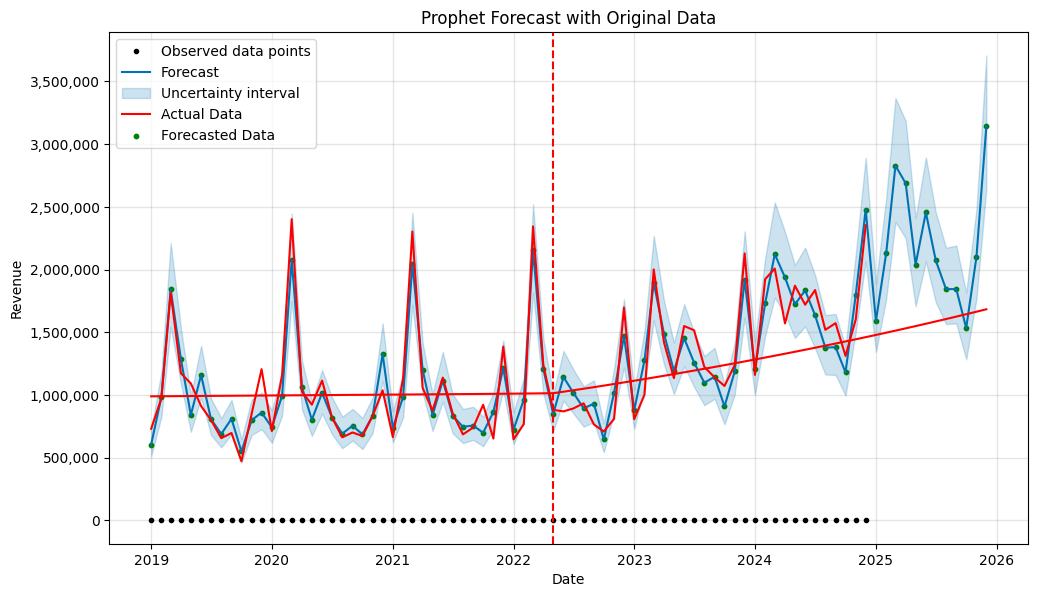

In [ ]:
from matplotlib.ticker import FuncFormatter
def int_formatter(x, pos):
    return f'{int(x):,}'

# Plot Prophet forecast
fig = prophet.plot(forecast)
ax = fig.gca()  # Get current axis

# Add changepoints
add_changepoints_to_plot(ax, prophet, forecast)

# Plot original data in RED with label
ax.plot(df['ds'], df['y'], 'r-', label='Actual Data')

# Plot predicted data points (Green Dots)
ax.scatter(forecast['ds'], forecast['yhat'], color='green', s=10, label='Forecasted Data')

# Formatting plot
ax.set_title("Prophet Forecast with Original Data")
ax.set_xlabel("Date")
ax.set_ylabel("Revenue")

# Convert y-axis values to integers
ax.yaxis.set_major_formatter(FuncFormatter(int_formatter))

ax.legend(loc='upper left')

# Show plot
plt.show()

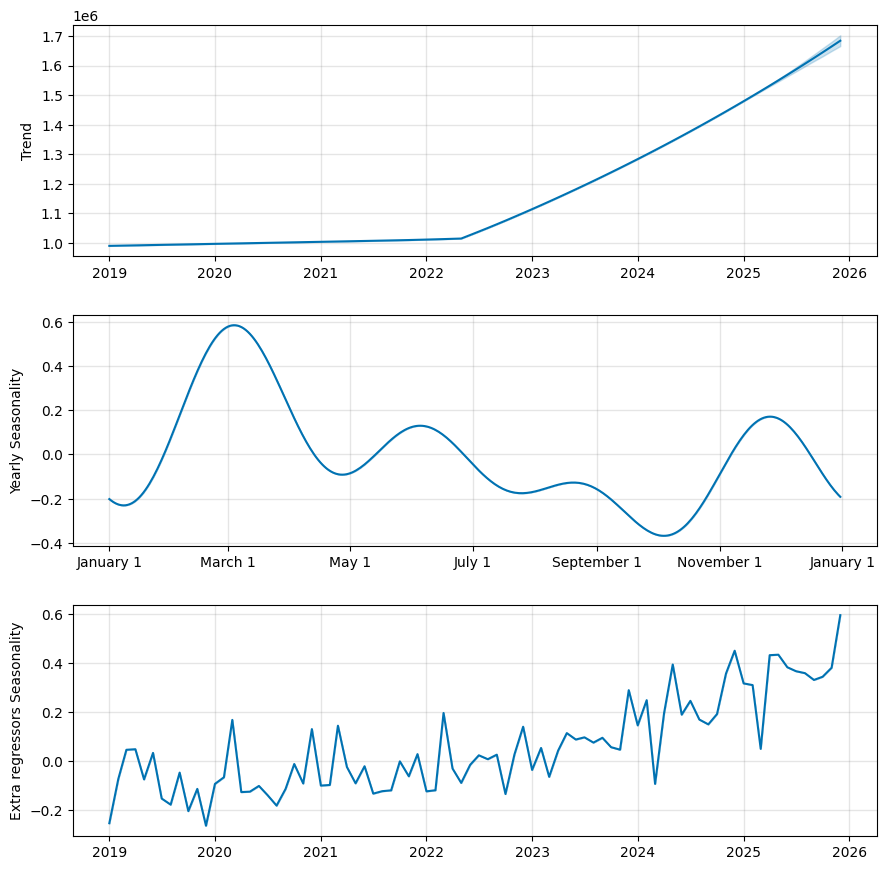

In [ ]:
fig1 = prophet.plot_components(forecast)
ax_list = fig1.get_axes()
ax_list[0].set_ylabel("Trend")  # Trend component
ax_list[1].set_ylabel("Yearly Seasonality")  # Weekly seasonality
ax_list[2].set_ylabel("Extra regressors Seasonality")  # Yearly seasonality (if available)

# Remove x-axis names for each plot
for ax in ax_list:
    ax.set_xlabel("")

plt.show()

In [ ]:
month=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
for col in month.columns[1:]:
  month[col]=month[col].astype(int)

month=month.set_index('ds')
monthly=month.tail(12)
monthly


<ipython-input-114-110ff1313534>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-114-110ff1313534>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-114-110ff1313534>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



yhat  yhat_lower  yhat_upper
ds                                         
2025-01-01  1590444     1344145     1885265
2025-02-01  2130716     1765226     2570517
2025-03-01  2829169     2381673     3368359
2025-04-01  2688267     2249495     3184978
2025-05-01  2040126     1706784     2410080
2025-06-01  2455770     2065178     2895363
2025-07-01  2072876     1740471     2456374
2025-08-01  1844095     1566392     2174401
2025-09-01  1845128     1570902     2192048
2025-10-01  1534028     1284419     1817003
2025-11-01  2100352     1768151     2479416
2025-12-01  3146031     2645039     3707777

In [ ]:
yearly=monthly.resample('Y').sum()
yearly



<ipython-input-115-5a6aabfb1849>:1: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



yhat  yhat_lower  yhat_upper
ds                                          
2025-12-31  26277002    22087875    31141581

In [ ]:
df_cv = cross_validation(prophet, initial='1740 days', period='30 days', horizon='360 days')

INFO:prophet:Making 3 forecasts with cutoffs between 2023-10-08 00:00:00 and 2023-12-07 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/hc096c3f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/kea7amsy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96028', 'data', 'file=/tmp/tmp9lov577b/hc096c3f.json', 'init=/tmp/tmp9lov577b/kea7amsy.json', 'output', 'file=/tmp/tmp9lov577b/prophet_modelj8j1jzml/prophet_model-20250305035512.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:55:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/psjqtki0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9lov577b/bg36jyxq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

In [ ]:
data_performance=performance_metrics(df_cv)
data_performance

horizon       mse      rmse       mae      mape     mdape     smape  \
0   25 days  0.026059  0.161427  0.119970  0.008315  0.005328  0.008378   
1   54 days  0.037012  0.192386  0.152017  0.010482  0.018392  0.010570   
2   55 days  0.024250  0.155725  0.103367  0.007136  0.001854  0.007193   
3   56 days  0.032089  0.179133  0.149361  0.010301  0.010657  0.010377   
4   85 days  0.013810  0.117515  0.104026  0.007204  0.008949  0.007210   
5   86 days  0.014444  0.120184  0.106044  0.007343  0.008949  0.007351   
6  115 days  0.016371  0.127948  0.120015  0.008293  0.008949  0.008296   
7  116 days  0.030394  0.174340  0.170045  0.011814  0.012063  0.011789   
8  145 days  0.029539  0.171868  0.166333  0.011558  0.012063  0.011535   
9  146 days  0.025366  0.159266  0.154212  0.010724  0.010150  0.010697   
10 176 days  0.031348  0.177054  0.175593  0.012242  0.013544  0.012223   
11 177 days  0.020968  0.144803  0.126714  0.008833  0.010877  0.008821   
12 206 days  0.019699  0.140354  0.123304  0.008569  0.011420  0.008585   
13 207 days  0.018585  0.136327  0.116550  0.008077  0.011420  0.008122   
14 237 days  0.015790  0.125658  0.093726  0.006500  0.011659  0.006538   
15 238 days  0.020306  0.142500  0.118543  0.008271  0.011719  0.008320   
16 267 days  0.026952  0.164169  0.150741  0.010503  0.011719  0.010568   
17 268 days  0.032404  0.180011  0.179737  0.012568  0.012744  0.012648   
18 269 days  0.035145  0.187469  0.187420  0.013097  0.013242  0.013184   
19 298 days  0.035159  0.187507  0.187458  0.013159  0.013306  0.013246   
20 299 days  0.034042  0.184504  0.183095  0.012889  0.013427  0.012973   
21 329 days  0.035284  0.187841  0.186161  0.013120  0.014443  0.013208   
22 330 days  0.025707  0.160333  0.147724  0.010401  0.011816  0.010459   
23 359 days  0.024481  0.156464  0.144906  0.010233  0.011816  0.010288   
24 360 days  0.043505  0.208578  0.179109  0.012408  0.012866  0.012360   

    coverage  
0   0.666667  
1   0.500000  
2   0.666667  
3   0.666667  
4   1.000000  
5   1.000000  
6   1.000000  
7   0.666667  
8   0.666667  
9   0.666667  
10  0.500000  
11  0.666667  
12  0.833333  
13  1.000000  
14  0.666667  
15  0.666667  
16  0.500000  
17  0.666667  
18  0.333333  
19  0.666667  
20  0.666667  
21  0.500000  
22  0.666667  
23  0.833333  
24  0.666667

In [ ]:
monthly=monthly[['yhat']]
merged_df = monthly.join(forecasted_reg, how="outer", lsuffix="_df", rsuffix="_forecast")
merged_df.reset_index(inplace=True)
merged_df=merged_df.rename(columns={'yhat':'Income','ds':'Date'})
merged_df['Expense'] =merged_df['directexp']+merged_df['genadmin']+merged_df['salaries']+merged_df['costalloc']+merged_df['marketing']+merged_df['dep']
merged_df['Profit']=merged_df['Income']-merged_df['Expense']


merged_df


Date   Income    dep  directexp  genadmin  marketing  salaries  \
0  2025-01-01  1590444  11649   304986.0  117420.0     102721  733267.0   
1  2025-02-01  2130716  12051   266132.0  121556.0     101171  761513.0   
2  2025-03-01  2829169  12401   361809.0  130069.0     113022  762857.0   
3  2025-04-01  2688267  12730   470948.0  135975.0     104323  757596.0   
4  2025-05-01  2040126  12960   512312.0  128770.0      99181  763303.0   
5  2025-06-01  2455770  13101   408665.0  120825.0      84046  778636.0   
6  2025-07-01  2072876  13169   384784.0  117169.0      92618  785322.0   
7  2025-08-01  1844095  13215   391295.0  113579.0     106858  772259.0   
8  2025-09-01  1845128  13290   355968.0  110178.0     113300  752017.0   
9  2025-10-01  1534028  13438   399331.0  107649.0     127029  751826.0   
10 2025-11-01  2100352  18761   440161.0  112827.0     131650  789241.0   
11 2025-12-01  3146031  19252   537094.0  128561.0     174323  855546.0   

    costalloc    Expense  march_effect  dec_effect     Profit  
0      334242  1604285.0             0         0.0   -13841.0  
1      337285  1599708.0             0         0.0   531008.0  
2      358831  1738989.0            -1         0.0  1090180.0  
3      377369  1858941.0             0         0.0   829326.0  
4      402649  1919175.0             0         0.0   120951.0  
5      442656  1847929.0             0         0.0   607841.0  
6      469334  1862396.0             0         0.0   210480.0  
7      482741  1879947.0             0         0.0   -35852.0  
8      450912  1795665.0             0         0.0    49463.0  
9      446137  1845410.0             0         0.0  -311382.0  
10     436491  1929131.0             0         0.0   171221.0  
11     419211  2133987.0             0         1.0  1012044.0

In [ ]:
yearly=merged_df.resample('Y', on='Date').sum()
yearly

<ipython-input-119-a20c298b7836>:1: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



Income     dep  directexp   genadmin  marketing   salaries  \
Date                                                                       
2025-12-31  26277002  166017  4833485.0  1444578.0    1350242  9263383.0   

            costalloc     Expense  march_effect  dec_effect     Profit  
Date                                                                    
2025-12-31    4957858  22015563.0            -1         1.0  4261439.0

In [ ]:
year_income = pd.concat([original, merged_df], ignore_index=False)
year_income.drop(columns={'otherinco','revenue','march_effect','dec_effect'},axis=1,inplace=True)

year_income.tail(12)


Date  costalloc    dep  directexp  genadmin  marketing  salaries  \
0  2025-01-01     334242  11649   304986.0  117420.0     102721  733267.0   
1  2025-02-01     337285  12051   266132.0  121556.0     101171  761513.0   
2  2025-03-01     358831  12401   361809.0  130069.0     113022  762857.0   
3  2025-04-01     377369  12730   470948.0  135975.0     104323  757596.0   
4  2025-05-01     402649  12960   512312.0  128770.0      99181  763303.0   
5  2025-06-01     442656  13101   408665.0  120825.0      84046  778636.0   
6  2025-07-01     469334  13169   384784.0  117169.0      92618  785322.0   
7  2025-08-01     482741  13215   391295.0  113579.0     106858  772259.0   
8  2025-09-01     450912  13290   355968.0  110178.0     113300  752017.0   
9  2025-10-01     446137  13438   399331.0  107649.0     127029  751826.0   
10 2025-11-01     436491  18761   440161.0  112827.0     131650  789241.0   
11 2025-12-01     419211  19252   537094.0  128561.0     174323  855546.0   

     Income    Expense     Profit  
0   1590444  1604285.0   -13841.0  
1   2130716  1599708.0   531008.0  
2   2829169  1738989.0  1090180.0  
3   2688267  1858941.0   829326.0  
4   2040126  1919175.0   120951.0  
5   2455770  1847929.0   607841.0  
6   2072876  1862396.0   210480.0  
7   1844095  1879947.0   -35852.0  
8   1845128  1795665.0    49463.0  
9   1534028  1845410.0  -311382.0  
10  2100352  1929131.0   171221.0  
11  3146031  2133987.0  1012044.0

In [ ]:
year_income.set_index('Date', inplace=True)
year_income = year_income.resample('Y').sum()  # Resample using the index
year_income['year'] = year_income.index.year  # Assign year to a new column
category_analysis = year_income.copy()
year_income

<ipython-input-121-0cb2e9848c9b>:2: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



costalloc     dep  directexp   genadmin  marketing   salaries  \
Date                                                                        
2019-12-31          0   25248  1499697.0   607524.0     345179  4987161.0   
2020-12-31    2393706   23792  1670410.0   669006.0     455434  4739820.0   
2021-12-31    2489457   29164  2095355.0   573858.0     545365  4813169.0   
2022-12-31    2986721   41292  1887194.0   759539.0     456542  5114248.0   
2023-12-31    3126204   43822  2507509.0   960262.0     604513  5617932.0   
2024-12-31    3938401  136411  3411100.0  1006125.0     965759  7471041.0   
2025-12-31    4957858  166017  4833485.0  1444578.0    1350242  9263383.0   

              Income     Expense     Profit  year  
Date                                               
2019-12-31  11385105   7464809.0  3920296.0  2019  
2020-12-31  12069601   9952168.0  2117433.0  2020  
2021-12-31  12417470  10546368.0  1871102.0  2021  
2022-12-31  12561695  11245536.0  1316159.0  2022  
2023-12-31  16238433  12860242.0  3378191.0  2023  
2024-12-31  20454098  16928837.0  3525261.0  2024  
2025-12-31  26277002  22015563.0  4261439.0  2025

In [ ]:
categories = ["costalloc", "dep", "directexp", "genadmin", "marketing", "salaries"]
yearly_totals = year_income.groupby('year')[categories].sum()

# Calculate percentage change for each category
yearly_percentage_change = yearly_totals.pct_change() * 100

# Calculate the number of rows and columns for the subplots
num_categories = len(yearly_percentage_change.columns)
num_rows = (num_categories + 1) // 2  # Round up to the nearest integer
num_cols = 2

# Create subplots figure
fig = make_subplots(
    rows=num_rows,
    cols=num_cols,
    subplot_titles=[f"Yearly Percentage Change for {column}" for column in yearly_percentage_change.columns]
)

# Counter for iterating through subplots
subplot_index = 1

# Iterate through categories and add traces to subplots
for column in yearly_percentage_change.columns:
    # Calculate row and column index for the current subplot
    row = (subplot_index - 1) // num_cols + 1
    col = (subplot_index - 1) % num_cols + 1

    # Add bar chart trace with text labels
    fig.add_trace(go.Bar(
        x=yearly_percentage_change.index.astype(str),  # Ensure x-axis labels are treated as categories
        y=yearly_percentage_change[column],
        name=f"% Change in {column}",
        marker=dict(color='#FF6F61'),
        text=yearly_percentage_change[column].round(2).astype(str) + '%',  # Add percentage labels
        textposition='outside',  # Place labels above bars
    ), row=row, col=col)

    # Add horizontal line at 0%
    fig.add_shape(
        type="line",
        x0=str(yearly_percentage_change.index.min()),
        x1=str(yearly_percentage_change.index.max()),
        y0=0, y1=0,
        line=dict(color="gray", dash="dash"),
        xref=f"x{subplot_index}", yref=f"y{subplot_index}"  # Ensure shape is added to correct subplot
    )

    # Update subplot layout
    fig.update_xaxes(title_text="Year", type='category', row=row, col=col)
    fig.update_yaxes(title_text="Percentage Change (%)", row=row, col=col)

    subplot_index += 1

# Update overall layout
fig.update_layout(
    template="plotly_white",
    height=400 * num_rows,  # Adjust height based on the number of rows
    width=600 * num_cols,   # Adjust width based on the number of columns
    showlegend=True,        # Show legend if needed
    title_text="</b>Yearly Percentage Change for Categories</b>"
)

# Show the plot
fig.show()

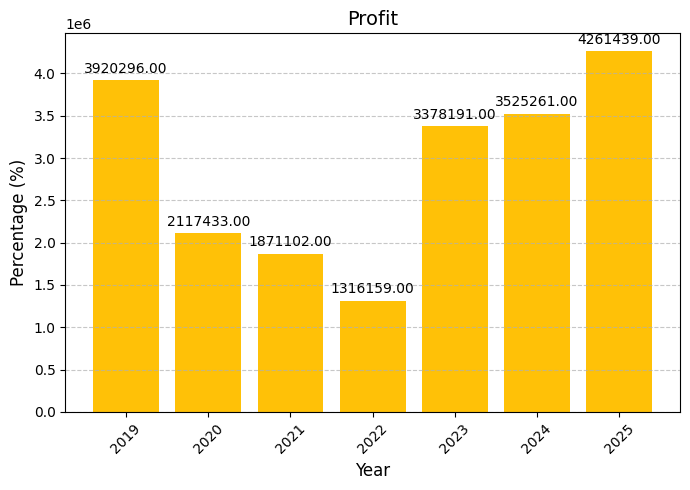

In [ ]:
fig2, ax2 = plt.subplots(figsize=(7, 5))

# Create the bar chart
bars = ax2.bar(year_income['year'], year_income['Profit'], label='Profit', color='#FFC107')

# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + (max(year_income['Profit']) * 0.02),
             f'{height:.2f}', ha='center', fontsize=10, color='black')

# Labels and formatting
ax2.set_xlabel('Year', fontsize=12)
ax2.set_title('Profit', fontsize=14)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.set_ylabel('Percentage (%)', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
for column in [ 'Income','Expense','Profit']:
    year_income[f'Percentage increase in {column}'] = year_income[column].pct_change() * 100
year_income

costalloc     dep  directexp   genadmin  marketing   salaries  \
Date                                                                        
2019-12-31          0   25248  1499697.0   607524.0     345179  4987161.0   
2020-12-31    2393706   23792  1670410.0   669006.0     455434  4739820.0   
2021-12-31    2489457   29164  2095355.0   573858.0     545365  4813169.0   
2022-12-31    2986721   41292  1887194.0   759539.0     456542  5114248.0   
2023-12-31    3126204   43822  2507509.0   960262.0     604513  5617932.0   
2024-12-31    3938401  136411  3411100.0  1006125.0     965759  7471041.0   
2025-12-31    4957858  166017  4833485.0  1444578.0    1350242  9263383.0   

              Income     Expense     Profit  year  \
Date                                                
2019-12-31  11385105   7464809.0  3920296.0  2019   
2020-12-31  12069601   9952168.0  2117433.0  2020   
2021-12-31  12417470  10546368.0  1871102.0  2021   
2022-12-31  12561695  11245536.0  1316159.0  2022   
2023-12-31  16238433  12860242.0  3378191.0  2023   
2024-12-31  20454098  16928837.0  3525261.0  2024   
2025-12-31  26277002  22015563.0  4261439.0  2025   

            Percentage increase in Income  Percentage increase in Expense  \
Date                                                                        
2019-12-31                            NaN                             NaN   
2020-12-31                       6.012206                       33.321134   
2021-12-31                       2.882191                        5.970558   
2022-12-31                       1.161468                        6.629467   
2023-12-31                      29.269442                       14.358640   
2024-12-31                      25.961033                       31.637002   
2025-12-31                      28.468153                       30.047699   

            Percentage increase in Profit  
Date                                       
2019-12-31                            NaN  
2020-12-31                     -45.987931  
2021-12-31                     -11.633473  
2022-12-31                     -29.658618  
2023-12-31                     156.670433  
2024-12-31                       4.353513  
2025-12-31                      20.882936

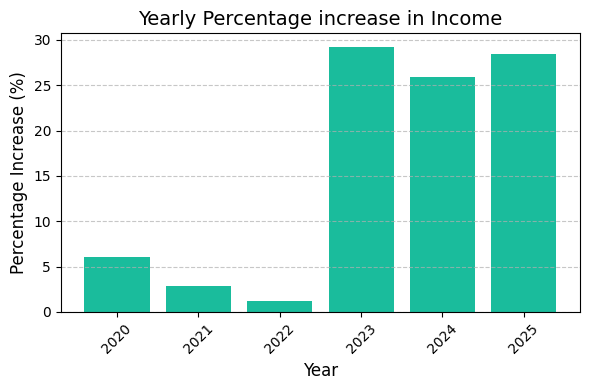

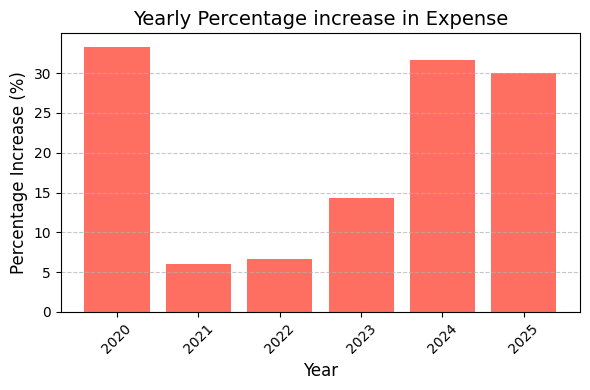

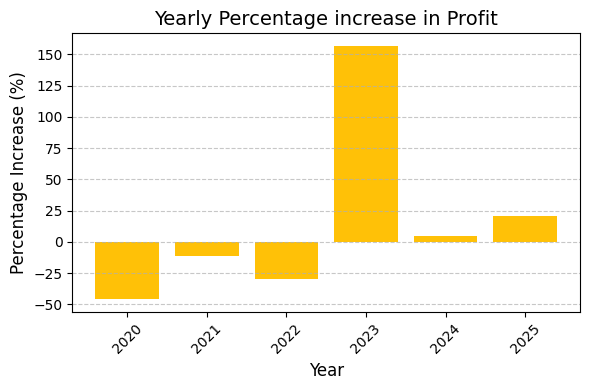

In [ ]:
columns = ['Percentage increase in Income', 'Percentage increase in Expense', 'Percentage increase in Profit']

for column in columns:
    if column == "Percentage increase in Income":
        colors = "#1ABC9C"  # Turquoise
    elif column == "Percentage increase in Expense":
        colors = "#FF6F61"  # Coral
    else:
        colors = "#FFC107"  # Amber

    plt.figure(figsize=(6, 4))

    # Create bar chart
    bars = plt.bar(year_income['year'], year_income[column], label=column, color=colors)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + (max(year_income[column]) * 0.02),
                 f'{height:.2f}', ha='center', fontsize=10, color='black', fontweight='bold')

    # Labels and formatting
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Percentage Increase (%)', fontsize=12)
    plt.title(f'Yearly {column}', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.show()

In [ ]:
year_income["Profit Margin on Expense"] = (year_income["Profit"] / year_income["Expense"]) * 100
year_income["Expense Margin on Income"] = (year_income["Expense"] / year_income["Income"]) * 100
year_income["Profit Margin on Income"] = (year_income["Profit"] / year_income["Income"]) * 100


In [ ]:
year_income['new_expense'] = year_income['Income'] * (year_income["Expense Margin on Income"].shift(1)) /100
year_income['New_profit'] = year_income['Income'] - year_income['new_expense']


year_income.fillna(0, inplace=True)
year_income['new_expense'] = year_income['new_expense'].astype(int)
year_income['Percentage_Increase_in_Expense'] = ((year_income['new_expense'] - year_income['Expense']) / year_income['Expense']) * 100


year_income['New_profit'] = year_income['New_profit'].astype(int)
year_income['Percentage_Increase_in_Profit'] = ((year_income['New_profit'] - year_income['Profit']) / year_income['Profit']) * 100




year_income



costalloc     dep  directexp   genadmin  marketing   salaries  \
Date                                                                        
2019-12-31          0   25248  1499697.0   607524.0     345179  4987161.0   
2020-12-31    2393706   23792  1670410.0   669006.0     455434  4739820.0   
2021-12-31    2489457   29164  2095355.0   573858.0     545365  4813169.0   
2022-12-31    2986721   41292  1887194.0   759539.0     456542  5114248.0   
2023-12-31    3126204   43822  2507509.0   960262.0     604513  5617932.0   
2024-12-31    3938401  136411  3411100.0  1006125.0     965759  7471041.0   
2025-12-31    4957858  166017  4833485.0  1444578.0    1350242  9263383.0   

              Income     Expense     Profit  year  \
Date                                                
2019-12-31  11385105   7464809.0  3920296.0  2019   
2020-12-31  12069601   9952168.0  2117433.0  2020   
2021-12-31  12417470  10546368.0  1871102.0  2021   
2022-12-31  12561695  11245536.0  1316159.0  2022   
2023-12-31  16238433  12860242.0  3378191.0  2023   
2024-12-31  20454098  16928837.0  3525261.0  2024   
2025-12-31  26277002  22015563.0  4261439.0  2025   

            Percentage increase in Income  Percentage increase in Expense  \
Date                                                                        
2019-12-31                       0.000000                        0.000000   
2020-12-31                       6.012206                       33.321134   
2021-12-31                       2.882191                        5.970558   
2022-12-31                       1.161468                        6.629467   
2023-12-31                      29.269442                       14.358640   
2024-12-31                      25.961033                       31.637002   
2025-12-31                      28.468153                       30.047699   

            Percentage increase in Profit  Profit Margin on Expense  \
Date                                                                  
2019-12-31                       0.000000                 52.517030   
2020-12-31                     -45.987931                 21.276098   
2021-12-31                     -11.633473                 17.741672   
2022-12-31                     -29.658618                 11.703835   
2023-12-31                     156.670433                 26.268487   
2024-12-31                       4.353513                 20.824000   
2025-12-31                      20.882936                 19.356484   

            Expense Margin on Income  Profit Margin on Income  new_expense  \
Date                                                                         
2019-12-31                 65.566448                34.433552            0   
2020-12-31                 82.456479                17.543521      7913608   
2021-12-31                 84.931697                15.068303     10239008   
2022-12-31                 89.522441                10.477559     10668860   
2023-12-31                 79.196324                20.803676     14537041   
2024-12-31                 82.765014                17.234986     16198893   
2025-12-31                 83.782629                16.217371     21748164   

            New_profit  Percentage_Increase_in_Expense  \
Date                                                     
2019-12-31           0                     -100.000000   
2020-12-31     4155992                      -20.483577   
2021-12-31     2178461                       -2.914368   
2022-12-31     1892834                       -5.128044   
2023-12-31     1701391                       13.038627   
2024-12-31     4255204                       -4.311838   
2025-12-31     4528837                       -1.214591   

            Percentage_Increase_in_Profit  
Date                                       
2019-12-31                    -100.000000  
2020-12-31                      96.275018  
2021-12-31                      16.426630  
2022-12-31                      43.814995  
2023-12-31      

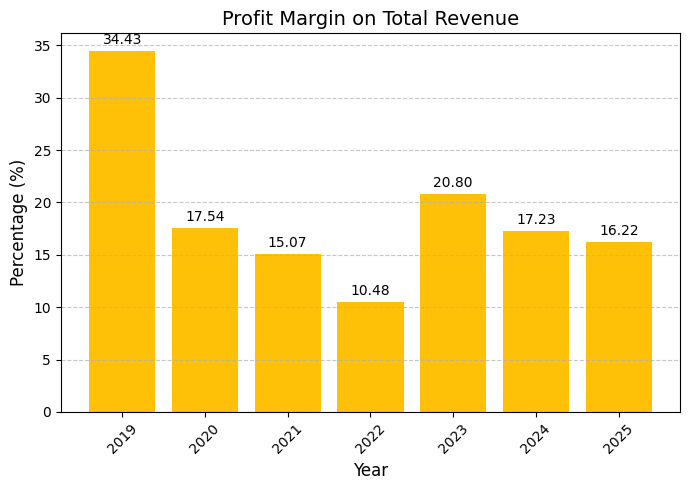

In [ ]:
fig2, ax2 = plt.subplots(figsize=(7, 5))
bars=ax2.bar(year_income['year'], year_income['Profit Margin on Income'], label='Profit Margin on Revenue', color='#FFC107')

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + (max(year_income['Profit Margin on Income']) * 0.02),
             f'{height:.2f}', ha='center', fontsize=10, color='black')

ax2.set_xlabel('Year', fontsize=12)
ax2.set_title('Profit Margin on Total Revenue', fontsize=14)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.set_ylabel('Percentage (%)', fontsize=12)
plt.tight_layout()
plt.show()

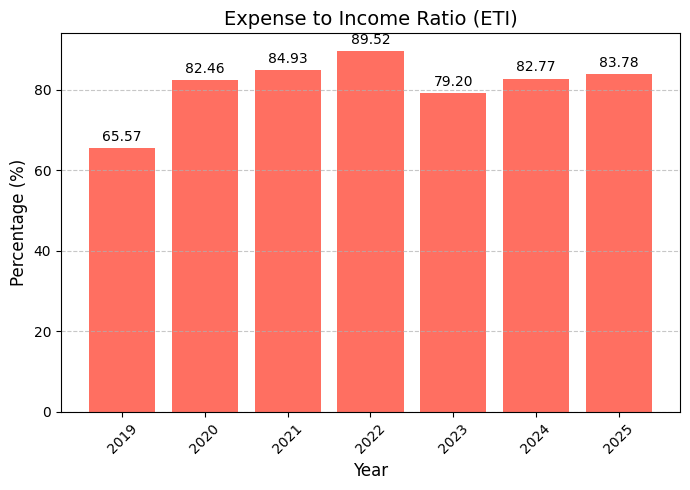

In [ ]:
fig2, ax2 = plt.subplots(figsize=(7, 5))
bars=ax2.bar(year_income['year'], year_income['Expense Margin on Income'], label='Expense Margin on Income', color='#FF6F61')

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + (max(year_income['Expense Margin on Income']) * 0.02),
             f'{height:.2f}', ha='center', fontsize=10, color='black')

ax2.set_xlabel('Year', fontsize=12)
ax2.set_title('Expense to Income Ratio (ETI)', fontsize=14)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.set_ylabel('Percentage (%)', fontsize=12)
plt.tight_layout()
plt.show()

<ipython-input-130-9512b7fa0466>:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



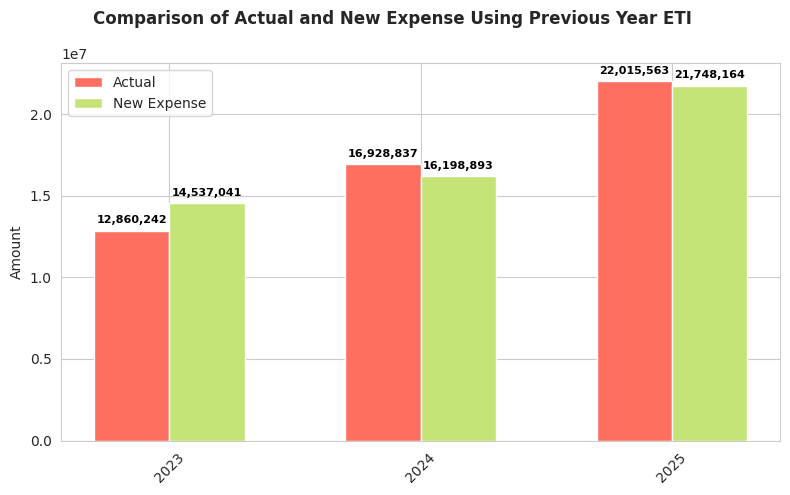

In [ ]:
sns.set_style("whitegrid")

# Define data subset
diff = year_income.iloc[4:, :]

# Define bar width and positions
x = np.arange(len(diff["year"]))  # Creating positions for the bars
width = 0.3  # Width of each bar

# Function to add text labels on bars
def add_labels(ax, x_positions, heights, width, color):
    for i in range(len(x_positions)):
        ax.text(x_positions[i], heights[i] + (max(heights) * 0.02), f'{heights[i]:,.0f}',
                ha='center', fontsize=8, color=color, fontweight='bold')

# --------- Profit and New Profit Plot ---------
fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle("Comparison of Actual and New Expense Using Previous Year ETI ", fontsize=12, fontweight='bold')

# Bar chart for Profit vs New Profit (Grouped bars)
bars3 = ax.bar(x - width/2, diff["Expense"], width=width, color="#FF6F61", label="Actual")
bars4 = ax.bar(x + width/2, diff["new_expense"], width=width, color="#C5E478", label="New Expense")
ax.set_xticks(x)
ax.set_xticklabels(diff["year"], rotation=45)
ax.set_ylabel("Amount")
ax.legend()

# Add labels
add_labels(ax, x - width/2, diff["Expense"], width, "black")
add_labels(ax, x + width/2, diff["new_expense"], width, "black")

plt.tight_layout()
plt.show()

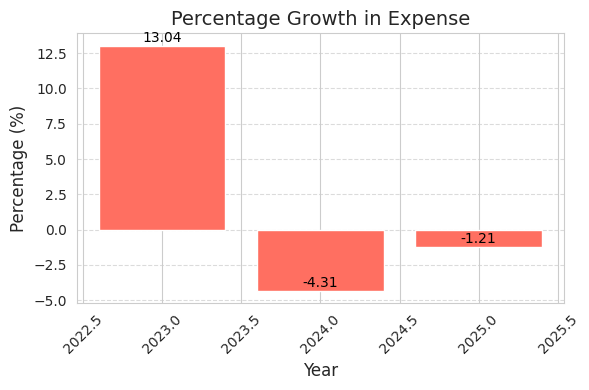

In [ ]:
filtered_data = year_income.tail(3)

fig2, ax2 = plt.subplots(figsize=(6,4))
bars = ax2.bar(filtered_data['year'], filtered_data['Percentage_Increase_in_Expense'],
               label='Percentage Difference in Expense', color='#FF6F61')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2,
             height + (max(filtered_data['Percentage_Increase_in_Expense']) * 0.02),
             f'{height:.2f}', ha='center', fontsize=10, color='black')


ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_title('Percentage Growth in Expense', fontsize=14)


ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-132-24416f3d88ff>:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



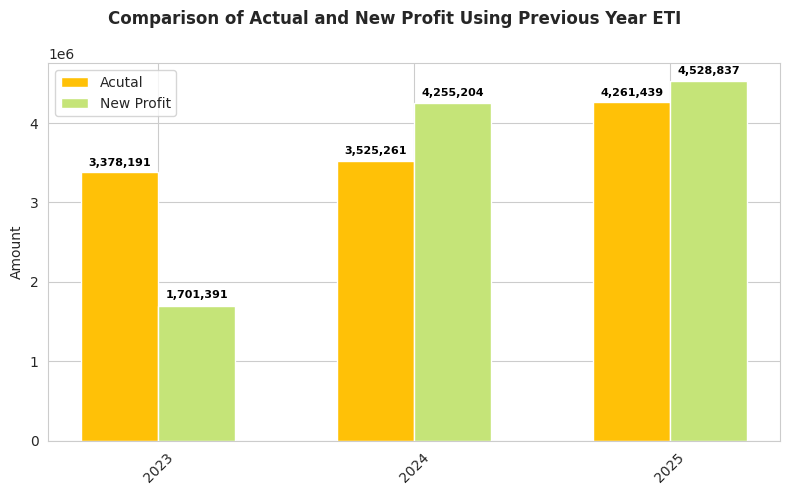

In [ ]:
sns.set_style("whitegrid")

# Define data subset
diff = year_income.iloc[4:, :]

# Define bar width and positions
x = np.arange(len(diff["year"]))  # Creating positions for the bars
width = 0.3  # Width of each bar

# Function to add text labels on bars
def add_labels(ax, x_positions, heights, width, color):
    for i in range(len(x_positions)):
        ax.text(x_positions[i], heights[i] + (max(heights) * 0.02), f'{heights[i]:,.0f}',
                ha='center', fontsize=8, color=color, fontweight='bold')

# --------- Profit and New Profit Plot ---------
fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle("Comparison of Actual and New Profit Using Previous Year ETI", fontsize=12, fontweight='bold')

# Bar chart for Profit vs New Profit (Grouped bars)
bars3 = ax.bar(x - width/2, diff["Profit"], width=width, color="#FFC107", label="Acutal")
bars4 = ax.bar(x + width/2, diff["New_profit"], width=width, color="#C5E478", label="New Profit")
ax.set_xticks(x)
ax.set_xticklabels(diff["year"], rotation=45)
ax.set_ylabel("Amount")
ax.legend()

# Add labels
add_labels(ax, x - width/2, diff["Profit"], width, "black")
add_labels(ax, x + width/2, diff["New_profit"], width, "black")

plt.tight_layout()
plt.show()

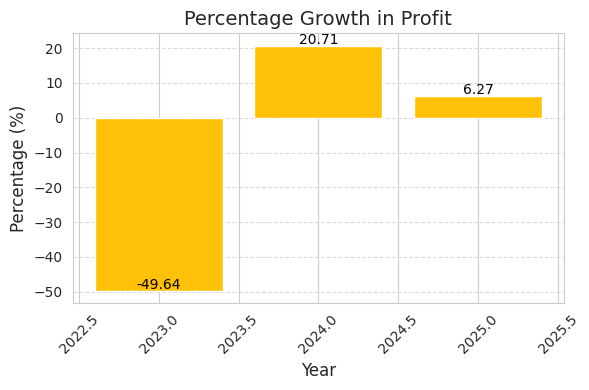

In [ ]:
filtered_data = year_income.tail(3)

fig2, ax2 = plt.subplots(figsize=(6, 4))
bars = ax2.bar(filtered_data['year'], filtered_data['Percentage_Increase_in_Profit'],
               label='Percentage Difference in Profit', color='#FFC107')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2,
             height + (max(filtered_data['Percentage_Increase_in_Profit']) * 0.02),
             f'{height:.2f}', ha='center', fontsize=10, color='black')


ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_title('Percentage Growth in Profit', fontsize=14)


ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
Avg =year_income['Expense Margin on Income'].iloc[4:].mean() #81.66601479487551
print(Avg)
year_income['new_expense'] = year_income['Income'] * (Avg)/100
year_income['New_profit'] = year_income['Income'] - year_income['new_expense']

year_income['new_expense'] = year_income['new_expense'].astype(int)
year_income['New_profit'] = year_income['New_profit'].astype(int)

year_income['Percentage_Increase_in_Expense'] = ((year_income['new_expense'] - year_income['Expense']) / year_income['Expense']) * 100
year_income['Percentage_Increase_in_Profit'] = ((year_income['New_profit'] - year_income['Profit']) / year_income['Profit']) * 100

year_income

81.91465539996385


costalloc     dep  directexp   genadmin  marketing   salaries  \
Date                                                                        
2019-12-31          0   25248  1499697.0   607524.0     345179  4987161.0   
2020-12-31    2393706   23792  1670410.0   669006.0     455434  4739820.0   
2021-12-31    2489457   29164  2095355.0   573858.0     545365  4813169.0   
2022-12-31    2986721   41292  1887194.0   759539.0     456542  5114248.0   
2023-12-31    3126204   43822  2507509.0   960262.0     604513  5617932.0   
2024-12-31    3938401  136411  3411100.0  1006125.0     965759  7471041.0   
2025-12-31    4957858  166017  4833485.0  1444578.0    1350242  9263383.0   

              Income     Expense     Profit  year  \
Date                                                
2019-12-31  11385105   7464809.0  3920296.0  2019   
2020-12-31  12069601   9952168.0  2117433.0  2020   
2021-12-31  12417470  10546368.0  1871102.0  2021   
2022-12-31  12561695  11245536.0  1316159.0  2022   
2023-12-31  16238433  12860242.0  3378191.0  2023   
2024-12-31  20454098  16928837.0  3525261.0  2024   
2025-12-31  26277002  22015563.0  4261439.0  2025   

            Percentage increase in Income  Percentage increase in Expense  \
Date                                                                        
2019-12-31                       0.000000                        0.000000   
2020-12-31                       6.012206                       33.321134   
2021-12-31                       2.882191                        5.970558   
2022-12-31                       1.161468                        6.629467   
2023-12-31                      29.269442                       14.358640   
2024-12-31                      25.961033                       31.637002   
2025-12-31                      28.468153                       30.047699   

            Percentage increase in Profit  Profit Margin on Expense  \
Date                                                                  
2019-12-31                       0.000000                 52.517030   
2020-12-31                     -45.987931                 21.276098   
2021-12-31                     -11.633473                 17.741672   
2022-12-31                     -29.658618                 11.703835   
2023-12-31                     156.670433                 26.268487   
2024-12-31                       4.353513                 20.824000   
2025-12-31                      20.882936                 19.356484   

            Expense Margin on Income  Profit Margin on Income  new_expense  \
Date                                                                         
2019-12-31                 65.566448                34.433552      9326069   
2020-12-31                 82.456479                17.543521      9886772   
2021-12-31                 84.931697                15.068303     10171727   
2022-12-31                 89.522441                10.477559     10289869   
2023-12-31                 79.196324                20.803676     13301656   
2024-12-31                 82.765014                17.234986     16754903   
2025-12-31                 83.782629                16.217371     21524715   

            New_profit  Percentage_Increase_in_Expense  \
Date                                                     
2019-12-31     2059035                       24.933793   
2020-12-31     2182828                       -0.657103   
2021-12-31     2245742                       -3.552322   
2022-12-31     2271825                       -8.498190   
2023-12-31     2936776                        3.432393   
2024-12-31     3699194                       -1.027442   
2025-12-31     4752286                       -2.229550   

            Percentage_Increase_in_Profit  
Date                                       
2019-12-31                     -47.477563  
2020-12-31                       3.088409  
2021-12-31                      20.022425  
2022-12-31                      72.610224  
2023-12-31      

In [ ]:
Expense_Margin_Difference = year_income["Expense Margin on Income"] - Avg
year_income['Expense difference']=Expense_Margin_Difference*(year_income["Expense"]/100)
year_income['Expense difference']=year_income['Expense difference'].astype(int)

year_income

costalloc     dep  directexp   genadmin  marketing   salaries  \
Date                                                                        
2019-12-31          0   25248  1499697.0   607524.0     345179  4987161.0   
2020-12-31    2393706   23792  1670410.0   669006.0     455434  4739820.0   
2021-12-31    2489457   29164  2095355.0   573858.0     545365  4813169.0   
2022-12-31    2986721   41292  1887194.0   759539.0     456542  5114248.0   
2023-12-31    3126204   43822  2507509.0   960262.0     604513  5617932.0   
2024-12-31    3938401  136411  3411100.0  1006125.0     965759  7471041.0   
2025-12-31    4957858  166017  4833485.0  1444578.0    1350242  9263383.0   

              Income     Expense     Profit  year  ...  \
Date                                               ...   
2019-12-31  11385105   7464809.0  3920296.0  2019  ...   
2020-12-31  12069601   9952168.0  2117433.0  2020  ...   
2021-12-31  12417470  10546368.0  1871102.0  2021  ...   
2022-12-31  12561695  11245536.0  1316159.0  2022  ...   
2023-12-31  16238433  12860242.0  3378191.0  2023  ...   
2024-12-31  20454098  16928837.0  3525261.0  2024  ...   
2025-12-31  26277002  22015563.0  4261439.0  2025  ...   

            Percentage increase in Expense  Percentage increase in Profit  \
Date                                                                        
2019-12-31                        0.000000                       0.000000   
2020-12-31                       33.321134                     -45.987931   
2021-12-31                        5.970558                     -11.633473   
2022-12-31                        6.629467                     -29.658618   
2023-12-31                       14.358640                     156.670433   
2024-12-31                       31.637002                       4.353513   
2025-12-31                       30.047699                      20.882936   

            Profit Margin on Expense  Expense Margin on Income  \
Date                                                             
2019-12-31                 52.517030                 65.566448   
2020-12-31                 21.276098                 82.456479   
2021-12-31                 17.741672                 84.931697   
2022-12-31                 11.703835                 89.522441   
2023-12-31                 26.268487                 79.196324   
2024-12-31                 20.824000                 82.765014   
2025-12-31                 19.356484                 83.782629   

            Profit Margin on Income  new_expense  New_profit  \
Date                                                           
2019-12-31                34.433552      9326069     2059035   
2020-12-31                17.543521      9886772     2182828   
2021-12-31                15.068303     10171727     2245742   
2022-12-31                10.477559     10289869     2271825   
2023-12-31                20.803676     13301656     2936776   
2024-12-31                17.234986     16754903     3699194   
2025-12-31                16.217371     21524715     4752286   

            Percentage_Increase_in_Expense  Percentage_Increase_in_Profit  \
Date                                                                        
2019-12-31                       24.933793                     -47.477563   
2020-12-31                       -0.657103                       3.088409   
2021-12-31                       -3.552322                      20.022425   
2022-12-31                       -8.498190                      72.610224   
2023-12-31                        3.432393                     -13.066609   
2024-12-31                       -1.027442                       4.933904   
2025-12-31                       -2.229550                      11.518339   

            Expense difference  
Date                            
2019-12-31            -1220362  
2020-12-31               53923  
2021-12-31              318188  
2022-12-31              855536  
2023-12-31             -349584  
2024

<ipython-input-136-2ea81e3e0285>:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



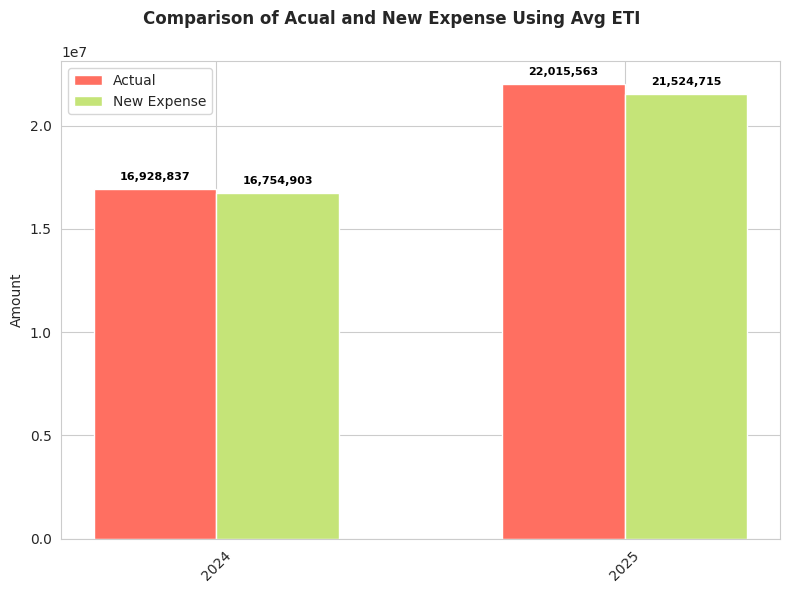

In [ ]:
sns.set_style("whitegrid")

# Define data subset
diff = year_income.iloc[5:, :]

# Define bar width and positions
x = np.arange(len(diff["year"]))  # Creating positions for the bars
width = 0.3  # Width of each bar

# Function to add text labels on bars
def add_labels(ax, x_positions, heights, width, color):
    for i in range(len(x_positions)):
        ax.text(x_positions[i], heights[i] + (max(heights) * 0.02), f'{heights[i]:,.0f}',
                ha='center', fontsize=8, color=color, fontweight='bold')

# --------- Profit and New Profit Plot ---------
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("Comparison of Acual and New Expense Using Avg ETI ", fontsize=12, fontweight='bold')

# Bar chart for Profit vs New Profit (Grouped bars)
bars3 = ax.bar(x - width/2, diff["Expense"], width=width, color="#FF6F61", label="Actual")
bars4 = ax.bar(x + width/2, diff["new_expense"], width=width, color="#C5E478", label="New Expense")
ax.set_xticks(x)
ax.set_xticklabels(diff["year"], rotation=45)
ax.set_ylabel("Amount")
ax.legend()

# Add labels
add_labels(ax, x - width/2, diff["Expense"], width, "black")
add_labels(ax, x + width/2, diff["new_expense"], width, "black")

plt.tight_layout()
plt.show()

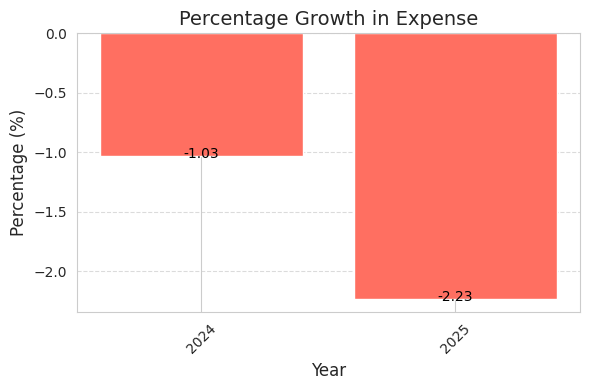

In [ ]:
import matplotlib.pyplot as plt

filtered_data = year_income.tail(2)

fig2, ax2 = plt.subplots(figsize=(6, 4))
bars = ax2.bar(filtered_data['year'], filtered_data['Percentage_Increase_in_Expense'],
               label='Percentage Difference in Expense', color='#FF6F61')

# Add text labels for bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2,
             height + (max(filtered_data['Percentage_Increase_in_Expense']) * 0.02),
             f'{height:.2f}', ha='center', fontsize=10, color='black')

# Set x-axis labels to show only years
ax2.set_xticks(filtered_data['year'])
ax2.set_xticklabels(filtered_data['year'].astype(int))  # Ensure labels are integers

ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_title('Percentage Growth in Expense', fontsize=14)

ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


<ipython-input-138-492e3116ada2>:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



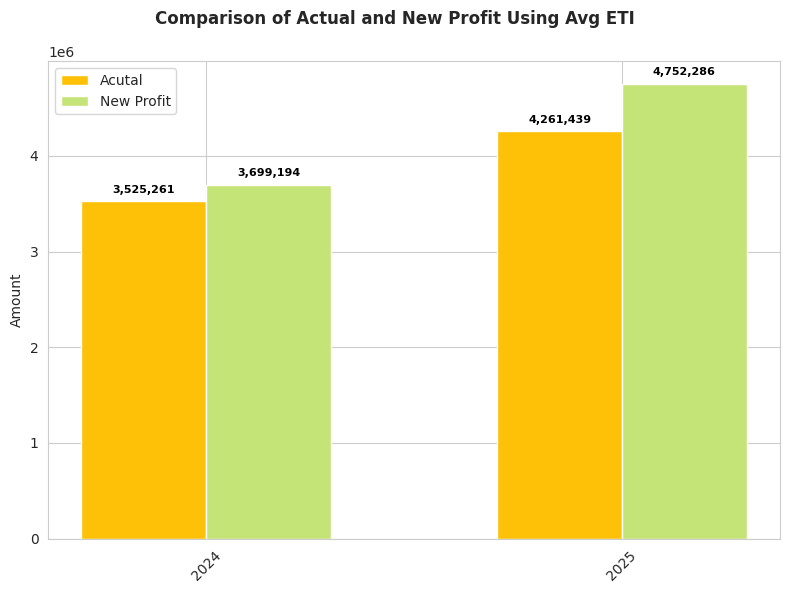

In [ ]:
sns.set_style("whitegrid")

# Define data subset
diff = year_income.iloc[5:, :]

# Define bar width and positions
x = np.arange(len(diff["year"]))  # Creating positions for the bars
width = 0.3  # Width of each bar

# Function to add text labels on bars
def add_labels(ax, x_positions, heights, width, color):
    for i in range(len(x_positions)):
        ax.text(x_positions[i], heights[i] + (max(heights) * 0.02), f'{heights[i]:,.0f}',
                ha='center', fontsize=8, color=color, fontweight='bold')

# --------- Profit and New Profit Plot ---------
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("Comparison of Actual and New Profit Using Avg ETI", fontsize=12, fontweight='bold')

# Bar chart for Profit vs New Profit (Grouped bars)
bars3 = ax.bar(x - width/2, diff["Profit"], width=width, color="#FFC107", label="Acutal")
bars4 = ax.bar(x + width/2, diff["New_profit"], width=width, color="#C5E478", label="New Profit")
ax.set_xticks(x)
ax.set_xticklabels(diff["year"], rotation=45)
ax.set_ylabel("Amount")
ax.legend()

# Add labels
add_labels(ax, x - width/2, diff["Profit"], width, "black")
add_labels(ax, x + width/2, diff["New_profit"], width, "black")

plt.tight_layout()
plt.show()

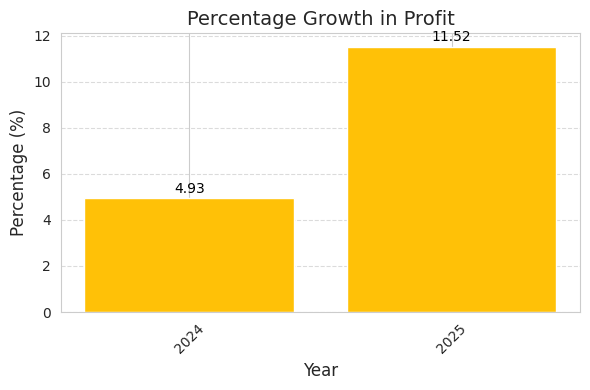

In [ ]:
filtered_data = year_income.tail(2)

fig2, ax2 = plt.subplots(figsize=(6, 4))
bars = ax2.bar(filtered_data['year'], filtered_data['Percentage_Increase_in_Profit'],
               label='Percentage Difference in Profit', color='#FFC107')

# Add text labels for bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2,
             height + (max(filtered_data['Percentage_Increase_in_Profit']) * 0.02),
             f'{height:.2f}', ha='center', fontsize=10, color='black')

# Set x-axis labels to show only years as integers
ax2.set_xticks(filtered_data['year'])
ax2.set_xticklabels(filtered_data['year'].astype(int))

ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_title('Percentage Growth in Profit', fontsize=14)

ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
year_income['New_profit'] = year_income['Expense'] * (year_income['Profit Margin on Expense'].shift(1)) / 100


year_income['new_expense'] = year_income['Income'] - year_income['New_profit']
year_income['new_Income'] = year_income['Expense'] + year_income['New_profit']
year_income['profit difference'] = year_income['New_profit'] - year_income['Profit']
year_income

costalloc     dep  directexp   genadmin  marketing   salaries  \
Date                                                                        
2019-12-31          0   25248  1499697.0   607524.0     345179  4987161.0   
2020-12-31    2393706   23792  1670410.0   669006.0     455434  4739820.0   
2021-12-31    2489457   29164  2095355.0   573858.0     545365  4813169.0   
2022-12-31    2986721   41292  1887194.0   759539.0     456542  5114248.0   
2023-12-31    3126204   43822  2507509.0   960262.0     604513  5617932.0   
2024-12-31    3938401  136411  3411100.0  1006125.0     965759  7471041.0   
2025-12-31    4957858  166017  4833485.0  1444578.0    1350242  9263383.0   

              Income     Expense     Profit  year  ...  \
Date                                               ...   
2019-12-31  11385105   7464809.0  3920296.0  2019  ...   
2020-12-31  12069601   9952168.0  2117433.0  2020  ...   
2021-12-31  12417470  10546368.0  1871102.0  2021  ...   
2022-12-31  12561695  11245536.0  1316159.0  2022  ...   
2023-12-31  16238433  12860242.0  3378191.0  2023  ...   
2024-12-31  20454098  16928837.0  3525261.0  2024  ...   
2025-12-31  26277002  22015563.0  4261439.0  2025  ...   

            Profit Margin on Expense  Expense Margin on Income  \
Date                                                             
2019-12-31                 52.517030                 65.566448   
2020-12-31                 21.276098                 82.456479   
2021-12-31                 17.741672                 84.931697   
2022-12-31                 11.703835                 89.522441   
2023-12-31                 26.268487                 79.196324   
2024-12-31                 20.824000                 82.765014   
2025-12-31                 19.356484                 83.782629   

            Profit Margin on Income   new_expense    New_profit  \
Date                                                              
2019-12-31                34.433552           NaN           NaN   
2020-12-31                17.543521  6.843018e+06  5.226583e+06   
2021-12-31                15.068303  1.017361e+07  2.243856e+06   
2022-12-31                10.477559  1.056655e+07  1.995146e+06   
2023-12-31                20.803676  1.473329e+07  1.505142e+06   
2024-12-31                17.234986  1.600715e+07  4.446949e+06   
2025-12-31                16.217371  2.169248e+07  4.584521e+06   

            Percentage_Increase_in_Expense  Percentage_Increase_in_Profit  \
Date                                                                        
2019-12-31                       24.933793                     -47.477563   
2020-12-31                       -0.657103                       3.088409   
2021-12-31                       -3.552322                      20.022425   
2022-12-31                       -8.498190                      72.610224   
2023-12-31                        3.432393                     -13.066609   
2024-12-31                       -1.027442                       4.933904   
2025-12-31                       -2.229550                      11.518339   

            Expense difference    new_Income  profit difference  
Date                                                             
2019-12-31            -1220362           NaN                NaN  
2020-12-31               53923  1.517875e+07       3.109150e+06  
2021-12-31              318188  1.279022e+07       3.727536e+05  
2022-12-31              855536  1.324068e+07       6.789871e+05  
2023-12-31             -349584  1.436538e+07      -1.873049e+06  
2024-12-31              143955  2.137579e+07       9.216883e+05  
2025-12-31              411244  2.660008e+07       3.230818e+05  

[7 rows x 23 columns]

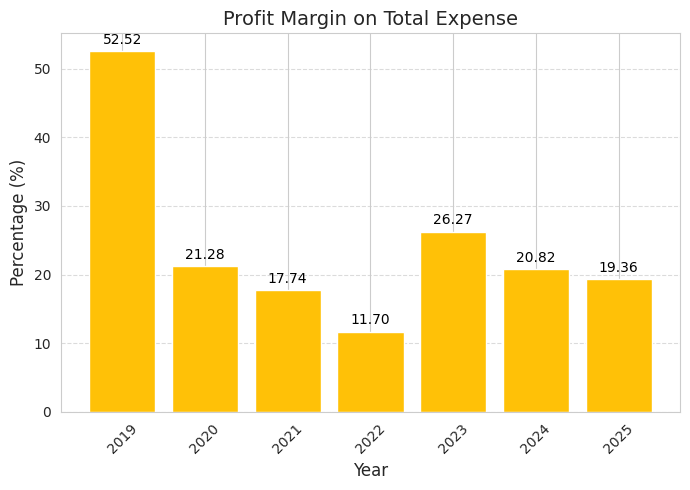

In [ ]:
fig2, ax2 = plt.subplots(figsize=(7, 5))
bars=ax2.bar(year_income['year'], year_income['Profit Margin on Expense'], label='Profit Margin on Expense', color='#FFC107')

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + (max(year_income['Profit Margin on Expense']) * 0.02),
             f'{height:.2f}', ha='center', fontsize=10, color='black')

ax2.set_xlabel('Year', fontsize=12)
ax2.set_title('Profit Margin on Total Expense', fontsize=14)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.set_ylabel('Percentage (%)', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set_style("whitegrid")

# # Define data subset
# diff = year_income.iloc[4:, :]

# # Define bar width and positions
# x = np.arange(len(diff["year"]))  # Creating positions for the bars
# width = 0.3  # Width of each bar

# # Function to add text labels on bars
# def add_labels(ax, x_positions, heights, width, color):
#     for i in range(len(x_positions)):
#         ax.text(x_positions[i], heights[i] + (max(heights) * 0.02), f'{heights[i]:,.0f}',
#                 ha='center', fontsize=8, color=color, fontweight='bold')

# # --------- Expense and Profit Plot ---------
# fig, axes = plt.subplots(2, 1, figsize=(8, 10))
# fig.suptitle("Based on Profit Margin on Expense from Previous Years to Find New Expense with Same Revenue", fontsize=12, fontweight='bold')

# # Bar chart for Expense vs New Expense (Grouped bars)
# bars5 = axes[0].bar(x - width/2, diff["Expense"], width=width, color="#FF6F61", label="Expense")
# bars6 = axes[0].bar(x + width/2, diff["new_expense"], width=width, color="#C5E478", label="New Expense")
# axes[0].set_xticks(x)
# axes[0].set_xticklabels(diff["year"], rotation=45)
# axes[0].set_ylabel("Amount")
# axes[0].legend()
# add_labels(axes[0], x - width/2, diff["Expense"], width, "black")
# add_labels(axes[0], x + width/2, diff["new_expense"], width, "black")

# # Bar chart for Profit vs New Profit (Grouped bars)
# bars3 = axes[1].bar(x - width/2, diff["Profit"], width=width, color="#FFC107", label="Profit")
# bars4 = axes[1].bar(x + width/2, diff["New_profit"], width=width, color="#C5E478", label="New Profit")
# axes[1].set_xticks(x)
# axes[1].set_xticklabels(diff["year"], rotation=45)
# axes[1].set_ylabel("Amount")
# axes[1].legend()
# add_labels(axes[1], x - width/2, diff["Profit"], width, "black")
# add_labels(axes[1], x + width/2, diff["New_profit"], width, "black")

# plt.tight_layout(rect=[0, 0.03, 1, 0.97])
# plt.show()

# # --------- Income and Profit Plot ---------
# fig, axes = plt.subplots(2, 1, figsize=(8, 10))
# fig.suptitle("Based on Profit Margin on Expense from Previous Years to Find New Income with Same Expense", fontsize=12, fontweight='bold')

# # Bar chart for Income vs New Income (Grouped bars)
# bars1 = axes[0].bar(x - width/2, diff["Income"], width=width, color="#1ABC9C", label="Revenue")
# bars2 = axes[0].bar(x + width/2, diff["new_Income"], width=width, color="#C5E478", label="New Revenue")
# axes[0].set_xticks(x)
# axes[0].set_xticklabels(diff["year"], rotation=45)
# axes[0].set_ylabel("Amount")
# axes[0].legend()
# add_labels(axes[0], x - width/2, diff["Income"], width, "black")
# add_labels(axes[0], x + width/2, diff["new_Income"], width, "black")

# # Bar chart for Profit vs New Profit (Grouped bars)
# bars3 = axes[1].bar(x - width/2, diff["Profit"], width=width, color="#FFC107", label="Profit")
# bars4 = axes[1].bar(x + width/2, diff["New_profit"], width=width, color="#C5E478", label="New Profit")
# axes[1].set_xticks(x)
# axes[1].set_xticklabels(diff["year"], rotation=45)
# axes[1].set_ylabel("Amount")
# axes[1].legend()
# add_labels(axes[1], x - width/2, diff["Profit"], width, "black")
# add_labels(axes[1], x + width/2, diff["New_profit"], width, "black")

# plt.tight_layout(rect=[0, 0.03, 1, 0.97])
# plt.show()


In [ ]:
Avg_expense_Margin_on_Income = year_income['Profit Margin on Expense'].iloc[4:].mean() #difference 21.06167938674587
print(Avg_expense_Margin_on_Income)
year_income['New_profit'] = year_income['Expense'] * (Avg_expense_Margin_on_Income) / 100
year_income['new_expense'] = year_income['Income'] - year_income['New_profit']
year_income['new_Income'] = year_income['Expense'] + year_income['New_profit']
year_income['profit difference'] = year_income['New_profit'] - year_income['Profit']


# Convert the new columns to float datatype
year_income.fillna(0, inplace=True)
year_income['New_profit'] = year_income['New_profit'].astype(int)
year_income['new_Income'] = year_income['new_Income'].astype(int)
year_income['new_expense'] = year_income['new_expense'].astype(int)

year_income

22.14965707868988


costalloc     dep  directexp   genadmin  marketing   salaries  \
Date                                                                        
2019-12-31          0   25248  1499697.0   607524.0     345179  4987161.0   
2020-12-31    2393706   23792  1670410.0   669006.0     455434  4739820.0   
2021-12-31    2489457   29164  2095355.0   573858.0     545365  4813169.0   
2022-12-31    2986721   41292  1887194.0   759539.0     456542  5114248.0   
2023-12-31    3126204   43822  2507509.0   960262.0     604513  5617932.0   
2024-12-31    3938401  136411  3411100.0  1006125.0     965759  7471041.0   
2025-12-31    4957858  166017  4833485.0  1444578.0    1350242  9263383.0   

              Income     Expense     Profit  year  ...  \
Date                                               ...   
2019-12-31  11385105   7464809.0  3920296.0  2019  ...   
2020-12-31  12069601   9952168.0  2117433.0  2020  ...   
2021-12-31  12417470  10546368.0  1871102.0  2021  ...   
2022-12-31  12561695  11245536.0  1316159.0  2022  ...   
2023-12-31  16238433  12860242.0  3378191.0  2023  ...   
2024-12-31  20454098  16928837.0  3525261.0  2024  ...   
2025-12-31  26277002  22015563.0  4261439.0  2025  ...   

            Profit Margin on Expense  Expense Margin on Income  \
Date                                                             
2019-12-31                 52.517030                 65.566448   
2020-12-31                 21.276098                 82.456479   
2021-12-31                 17.741672                 84.931697   
2022-12-31                 11.703835                 89.522441   
2023-12-31                 26.268487                 79.196324   
2024-12-31                 20.824000                 82.765014   
2025-12-31                 19.356484                 83.782629   

            Profit Margin on Income  new_expense  New_profit  \
Date                                                           
2019-12-31                34.433552      9731675     1653429   
2020-12-31                17.543521      9865229     2204371   
2021-12-31                15.068303     10081485     2335984   
2022-12-31                10.477559     10070847     2490847   
2023-12-31                20.803676     13389933     2848499   
2024-12-31                17.234986     16704418     3749679   
2025-12-31                16.217371     21400630     4876371   

            Percentage_Increase_in_Expense  Percentage_Increase_in_Profit  \
Date                                                                        
2019-12-31                       24.933793                     -47.477563   
2020-12-31                       -0.657103                       3.088409   
2021-12-31                       -3.552322                      20.022425   
2022-12-31                       -8.498190                      72.610224   
2023-12-31                        3.432393                     -13.066609   
2024-12-31                       -1.027442                       4.933904   
2025-12-31                       -2.229550                      11.518339   

            Expense difference  new_Income  profit difference  
Date                                                           
2019-12-31            -1220362     9118238      -2.266866e+06  
2020-12-31               53923    12156539       8.693808e+04  
2021-12-31              318188    12882352       4.648823e+05  
2022-12-31              855536    13736383       1.174689e+06  
2023-12-31             -349584    15708741      -5.296915e+05  
2024-12-31              143955    20678516       2.244183e+05  
2025-12-31              411244    26891934       6.149327e+05  

[7 rows x 23 columns]

<ipython-input-144-c9021fb06b3f>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



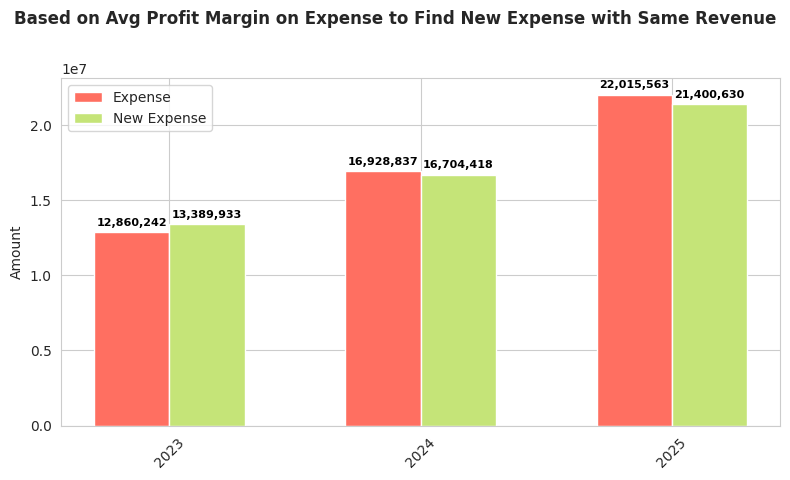

<ipython-input-144-c9021fb06b3f>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



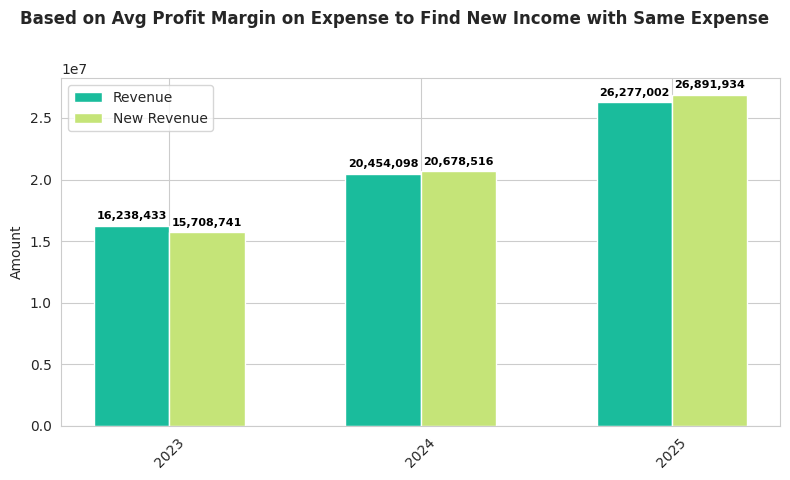

In [ ]:
# Define data subset
diff = year_income.iloc[4:, :]

# Define bar width and positions
x = np.arange(len(diff["year"]))  # Creating positions for the bars
width = 0.3  # Width of each bar

# Function to add text labels on bars
def add_labels(ax, x_positions, heights, width, color):
    for i in range(len(x_positions)):
        ax.text(x_positions[i], heights[i] + (max(heights) * 0.02), f'{heights[i]:,.0f}',
                ha='center', fontsize=8, color=color, fontweight='bold')

# --------- Expense and New Expense Plot ---------
fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle("Based on Avg Profit Margin on Expense to Find New Expense with Same Revenue", fontsize=12, fontweight='bold')

# Bar chart for Expense vs New Expense (Grouped bars)
bars5 = ax.bar(x - width/2, diff["Expense"], width=width, color="#FF6F61", label="Expense")
bars6 = ax.bar(x + width/2, diff["new_expense"], width=width, color="#C5E478", label="New Expense")
ax.set_xticks(x)
ax.set_xticklabels(diff["year"], rotation=45)
ax.set_ylabel("Amount")
ax.legend()
add_labels(ax, x - width/2, diff["Expense"], width, "black")
add_labels(ax, x + width/2, diff["new_expense"], width, "black")

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# --------- Income and New Income Plot ---------
fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle("Based on Avg Profit Margin on Expense to Find New Income with Same Expense", fontsize=12, fontweight='bold')

# Bar chart for Income vs New Income (Grouped bars)
bars1 = ax.bar(x - width/2, diff["Income"], width=width, color="#1ABC9C", label="Revenue")
bars2 = ax.bar(x + width/2, diff["new_Income"], width=width, color="#C5E478", label="New Revenue")
ax.set_xticks(x)
ax.set_xticklabels(diff["year"], rotation=45)
ax.set_ylabel("Amount")
ax.legend()
add_labels(ax, x - width/2, diff["Income"], width, "black")
add_labels(ax, x + width/2, diff["new_Income"], width, "black")

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

<ipython-input-145-0d6fe2e31970>:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



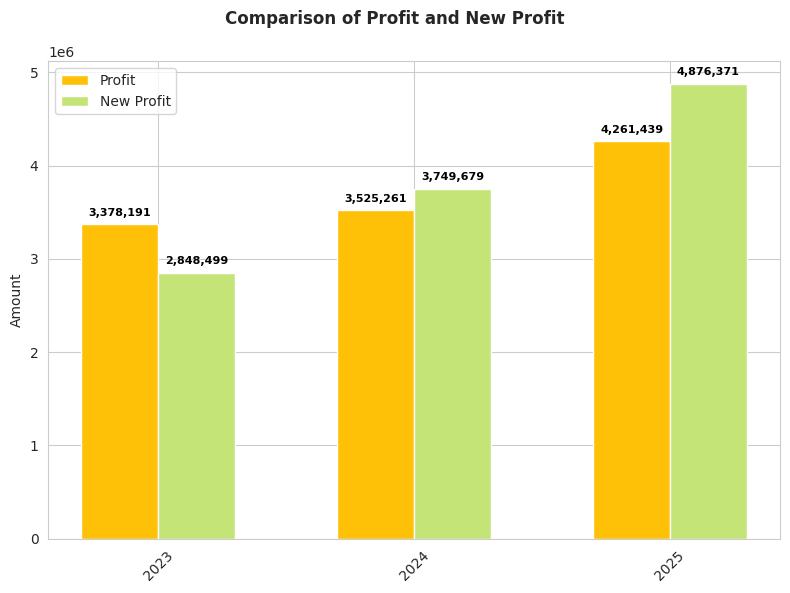

In [ ]:
sns.set_style("whitegrid")

# Define data subset
diff = year_income.iloc[4:, :]

# Define bar width and positions
x = np.arange(len(diff["year"]))  # Creating positions for the bars
width = 0.3  # Width of each bar

# Function to add text labels on bars
def add_labels(ax, x_positions, heights, width, color):
    for i in range(len(x_positions)):
        ax.text(x_positions[i], heights[i] + (max(heights) * 0.02), f'{heights[i]:,.0f}',
                ha='center', fontsize=8, color=color, fontweight='bold')

# --------- Profit and New Profit Plot ---------
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("Comparison of Profit and New Profit", fontsize=12, fontweight='bold')

# Bar chart for Profit vs New Profit (Grouped bars)
bars3 = ax.bar(x - width/2, diff["Profit"], width=width, color="#FFC107", label="Profit")
bars4 = ax.bar(x + width/2, diff["New_profit"], width=width, color="#C5E478", label="New Profit")
ax.set_xticks(x)
ax.set_xticklabels(diff["year"], rotation=45)
ax.set_ylabel("Amount")
ax.legend()

# Add labels
add_labels(ax, x - width/2, diff["Profit"], width, "black")
add_labels(ax, x + width/2, diff["New_profit"], width, "black")

plt.tight_layout()
plt.show()

In [ ]:
category_analysis['dep_per']=category_analysis['dep']/category_analysis['Expense']*100
category_analysis['costalloc_per']=category_analysis['costalloc']/category_analysis['Expense']*100
category_analysis['genadmin_per']=category_analysis['genadmin']/category_analysis['Expense']*100
category_analysis['directexp_per']=category_analysis['directexp']/category_analysis['Expense']*100
category_analysis['salaries_per']=category_analysis['salaries']/category_analysis['Expense']*100
category_analysis['marketing_per']=category_analysis['marketing']/category_analysis['Expense']*100

category_analysis

costalloc     dep  directexp   genadmin  marketing   salaries  \
Date                                                                        
2019-12-31          0   25248  1499697.0   607524.0     345179  4987161.0   
2020-12-31    2393706   23792  1670410.0   669006.0     455434  4739820.0   
2021-12-31    2489457   29164  2095355.0   573858.0     545365  4813169.0   
2022-12-31    2986721   41292  1887194.0   759539.0     456542  5114248.0   
2023-12-31    3126204   43822  2507509.0   960262.0     604513  5617932.0   
2024-12-31    3938401  136411  3411100.0  1006125.0     965759  7471041.0   
2025-12-31    4957858  166017  4833485.0  1444578.0    1350242  9263383.0   

              Income     Expense     Profit  year   dep_per  costalloc_per  \
Date                                                                         
2019-12-31  11385105   7464809.0  3920296.0  2019  0.338227       0.000000   
2020-12-31  12069601   9952168.0  2117433.0  2020  0.239063      24.052106   
2021-12-31  12417470  10546368.0  1871102.0  2021  0.276531      23.604875   
2022-12-31  12561695  11245536.0  1316159.0  2022  0.367186      26.559170   
2023-12-31  16238433  12860242.0  3378191.0  2023  0.340756      24.309060   
2024-12-31  20454098  16928837.0  3525261.0  2024  0.805791      23.264451   
2025-12-31  26277002  22015563.0  4261439.0  2025  0.754089      22.519787   

            genadmin_per  directexp_per  salaries_per  marketing_per  
Date                                                                  
2019-12-31      8.138507      20.090226     66.808957       4.624083  
2020-12-31      6.722214      16.784383     47.626005       4.576229  
2021-12-31      5.441286      19.868025     45.638167       5.171117  
2022-12-31      6.754138      16.781717     45.478028       4.059762  
2023-12-31      7.466905      19.498148     43.684497       4.700635  
2024-12-31      5.943261      20.149642     44.132039       5.704816  
2025-12-31      6.561622      21.954855     42.076521       6.133125

In [ ]:
import plotly.express as px
import pandas as pd

# Sample DataFrame (Ensure your data is formatted correctly)
# category_analysis = pd.read_csv("your_data.csv")

# Rename columns for legend formatting
legend_names = {
    'dep_per': 'Dep',
    'costalloc_per': 'Cost Alloc',
    'genadmin_per': 'Gen Admin',
    'directexp_per': 'Direct Exp',
    'salaries_per': 'Salaries',
    'marketing_per': 'Marketing'
}

# Melt the DataFrame for Plotly
melted_data = category_analysis.melt(id_vars=['year'],
                                     value_vars=list(legend_names.keys()),
                                     var_name='Category',
                                     value_name='Percentage')

# Apply legend name changes
melted_data['Category'] = melted_data['Category'].map(legend_names)

# Define the custom color scheme
color_map = {
    'Dep': "#FF6F61",         # Red
    'Cost Alloc': "#1ABC9C",  # Teal
    'Gen Admin': "#FFC107",   # Amber
    'Direct Exp': "#E91E63",  # Magenta
    'Salaries': "#C5E478",    # Lemon Green
    'Marketing': "#000873"    # Lemon Green
}

# Highlight large percentages with Deep Blue (#000873)
melted_data['color'] = melted_data['Category'].map(color_map)
melted_data.loc[melted_data['Percentage'] > 50, 'color'] = "#000873"  # Dark blue for large values

# Create a bar chart with the new color scheme
fig = px.bar(melted_data,
             x='year',
             y='Percentage',
             color='Category',
             title="<b>Yearly Expense Category Analysis</b>",
             labels={'Percentage': 'Contribution (%)', 'year': 'Year'},
             barmode='stack',
             color_discrete_map=color_map)

# Add percentage labels inside the bars
fig.update_traces(texttemplate='%{y:.2f}%', textposition='inside')

# Improve layout
fig.update_layout(
    template="plotly_dark",
    title_font_size=22,
    title_x=0.5,
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True, gridcolor="gray"),
    hovermode="x unified",
    height=600,
    width=900,
    legend=dict(
        title="Expense Category",
        orientation="h",
        yanchor="bottom",
        y=-0.25,
        xanchor="center",
        x=0.5
    )
)

# Show the interactive plot
fig.show()


In [ ]:
avg_marketing = category_analysis['marketing_per'].iloc[5:6].mean()
avg_dep = category_analysis['dep_per'].iloc[5:6].mean()
avg_costalloc = category_analysis['costalloc_per'].iloc[5:6].mean()
avg_genadmin = category_analysis['genadmin_per'].iloc[5:6].mean()
avg_directexp = category_analysis['directexp_per'].iloc[5:6].mean()
avg_Salaries = category_analysis['salaries_per'].iloc[5:6].mean()

# avg_marketing = category_analysis['marketing_per'].iloc[:5].median()
# avg_dep = category_analysis['dep_per'].iloc[:5].median()
# avg_costalloc = category_analysis['costalloc_per'].iloc[:5].median()
# avg_genadmin = category_analysis['genadmin_per'].iloc[:5].median()
# avg_directexp = category_analysis['directexp_per'].iloc[:5].median()
# avg_Salaries = category_analysis['salaries_per'].iloc[:5].median()

# avg_marketing = category_analysis['marketing_per'].iloc[5:6].mean()
# avg_dep = category_analysis['dep_per'].iloc[5:6].mean()
# avg_costalloc = category_analysis['costalloc_per'].iloc[5:6].mean()
# avg_genadmin = category_analysis['genadmin_per'].iloc[5:6].mean()
# avg_directexp = category_analysis['directexp_per'].iloc[5:6].mean()
# avg_Salaries = category_analysis['salaries_per'].iloc[5:6].mean()

print("Average Marketing:", avg_marketing)
print("Average Dep:", avg_dep)
print("Average Cost Allocation:", avg_costalloc)
print("Average General Administration:", avg_genadmin)
print("Average Direct Expenses:", avg_directexp)
print("Average Salaries:", avg_Salaries)


Average Marketing: 5.704815989426799
Average Dep: 0.8057907344727815
Average Cost Allocation: 23.26445106654403
Average General Administration: 5.943261193902452
Average Direct Expenses: 20.149641703089234
Average Salaries: 44.13203931256471


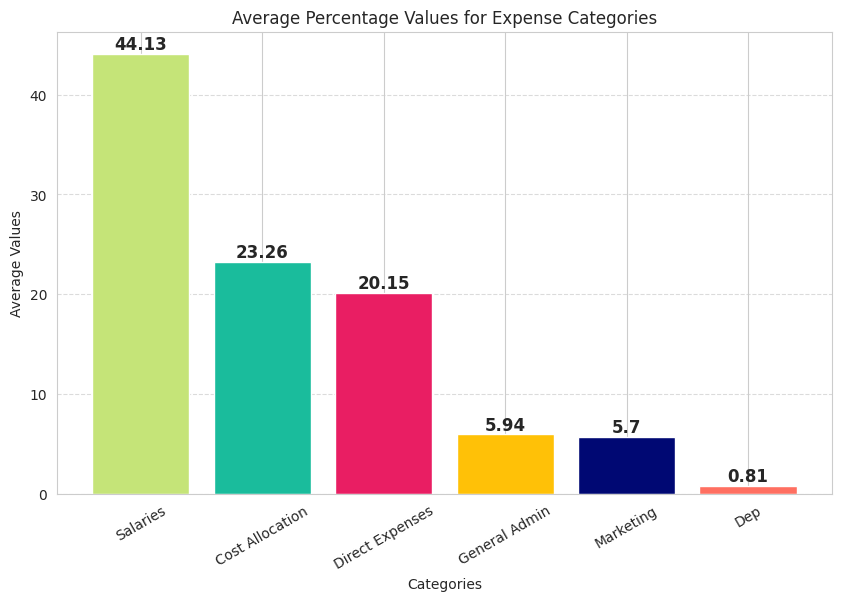

In [ ]:
categories = ['Marketing', 'Dep', 'Cost Allocation', 'General Admin', 'Direct Expenses', 'Salaries']
average_values = [avg_marketing, avg_dep, avg_costalloc, avg_genadmin, avg_directexp, avg_Salaries]

# Colors for each category
category_colors = {
    'Marketing': "#000873",      # Dark Blue
    'Dep': "#FF6F61",     # Red
    'Cost Allocation': "#1ABC9C", # Teal
    'General Admin': "#FFC107",  # Amber
    'Direct Expenses': "#E91E63", # Magenta
    'Salaries': "#C5E478"       # Lemon Green
}

# Sort the categories based on the average values in descending order
sorted_categories, sorted_average_values = zip(*sorted(zip(categories, average_values), key=lambda x: x[1], reverse=True))

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_categories, sorted_average_values, color=[category_colors[cat] for cat in sorted_categories])

# Display average values on top of bars
for bar, avg in zip(bars, sorted_average_values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(avg, 2),
             ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.xlabel('Categories')
plt.ylabel('Average Values')
plt.title('Average Percentage Values for Expense Categories')
plt.xticks(rotation=30)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines
plt.show()

In [ ]:
category_analysis['New_market'] = (avg_marketing / 100) * category_analysis['Expense']
category_analysis['New_dep'] = (avg_dep / 100) * category_analysis['Expense']
category_analysis['New_costalloc'] = (avg_costalloc / 100) * category_analysis['Expense']
category_analysis['New_genadmin'] = (avg_genadmin / 100) * category_analysis['Expense']
category_analysis['New_directexp'] = (avg_directexp / 100) * category_analysis['Expense']
category_analysis['New_Salaries'] = (avg_Salaries / 100) * category_analysis['Expense']

# Convert new columns to integers
columns_to_convert = ['New_market', 'New_dep', 'New_costalloc',
                      'New_genadmin', 'New_directexp', 'New_Salaries']
category_analysis[columns_to_convert] = category_analysis[columns_to_convert].astype(int)



category_analysis


costalloc     dep  directexp   genadmin  marketing   salaries  \
Date                                                                        
2019-12-31          0   25248  1499697.0   607524.0     345179  4987161.0   
2020-12-31    2393706   23792  1670410.0   669006.0     455434  4739820.0   
2021-12-31    2489457   29164  2095355.0   573858.0     545365  4813169.0   
2022-12-31    2986721   41292  1887194.0   759539.0     456542  5114248.0   
2023-12-31    3126204   43822  2507509.0   960262.0     604513  5617932.0   
2024-12-31    3938401  136411  3411100.0  1006125.0     965759  7471041.0   
2025-12-31    4957858  166017  4833485.0  1444578.0    1350242  9263383.0   

              Income     Expense     Profit  year  ...  genadmin_per  \
Date                                               ...                 
2019-12-31  11385105   7464809.0  3920296.0  2019  ...      8.138507   
2020-12-31  12069601   9952168.0  2117433.0  2020  ...      6.722214   
2021-12-31  12417470  10546368.0  1871102.0  2021  ...      5.441286   
2022-12-31  12561695  11245536.0  1316159.0  2022  ...      6.754138   
2023-12-31  16238433  12860242.0  3378191.0  2023  ...      7.466905   
2024-12-31  20454098  16928837.0  3525261.0  2024  ...      5.943261   
2025-12-31  26277002  22015563.0  4261439.0  2025  ...      6.561622   

            directexp_per  salaries_per  marketing_per  New_market  New_dep  \
Date                                                                          
2019-12-31      20.090226     66.808957       4.624083      425853    60150   
2020-12-31      16.784383     47.626005       4.576229      567752    80193   
2021-12-31      19.868025     45.638167       5.171117      601650    84981   
2022-12-31      16.781717     45.478028       4.059762      641537    90615   
2023-12-31      19.498148     43.684497       4.700635      733653   103626   
2024-12-31      20.149642     44.132039       5.704816      965759   136411   
2025-12-31      21.954855     42.076521       6.133125     1255947   177399   

            New_costalloc  New_genadmin  New_directexp  New_Salaries  
Date                                                                  
2019-12-31        1736646        443653        1504132       3294372  
2020-12-31        2315317        591483        2005326       4392094  
2021-12-31        2453554        626798        2125055       4654327  
2022-12-31        2616212        668351        2265935       4962884  
2023-12-31        2991864        764317        2591292       5675487  
2024-12-31        3938401       1006125        3411100       7471041  
2025-12-31        5121799       1308442        4436057       9715916  

[7 rows x 22 columns]

In [ ]:
category_percentage = pd.DataFrame()

columns = ['dep', 'costalloc', 'genadmin', 'directexp', 'salaries', 'marketing']
new_columns = ['New_dep', 'New_costalloc', 'New_genadmin', 'New_directexp', 'New_Salaries', 'New_market']

# Ensure both lists are aligned
for old_col, new_col in zip(columns, new_columns):
    category_percentage[old_col] = (category_analysis[old_col] - category_analysis[new_col])/category_analysis[old_col] * 100

category_percentage

dep  costalloc   genadmin  directexp   salaries  marketing
Date                                                                         
2019-12-31 -138.236692       -inf  26.973585  -0.295726  33.942939 -23.371642
2020-12-31 -237.058675   3.274796  11.587788 -20.049928   7.336270 -24.661751
2021-12-31 -191.390070   1.442202  -9.225279  -1.417421   3.300154 -10.320611
2022-12-31 -119.449288  12.405210  12.005703 -20.069002   2.959653 -40.520916
2023-12-31 -136.470266   4.297224  20.405369  -3.341284  -1.024487 -21.362651
2024-12-31    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000
2025-12-31   -6.855924  -3.306690   9.423929   8.222390  -4.885181   6.983563

In [ ]:
# categories = ['Cost Allocation', 'Depreciation', 'Direct Expenses', 'General Admin', 'Marketing', 'Salaries']

# # Extract actual and new expenses from DataFrame
# actual_expenses = category_analysis[['costalloc', 'dep', 'directexp', 'genadmin', 'marketing', 'salaries']].mean()
# new_expenses = category_analysis[['New_costalloc', 'New_dep', 'New_directexp', 'New_genadmin', 'New_market', 'New_Salaries']].mean()

# # Define positions for bars
# x = np.arange(len(categories))  # Positions of categories
# gap = 0.05  # Increase gap between Actual and New Expense bars
# bar_width = 0.4  # Width of each individual bar

# # Create figure and axis
# fig, ax = plt.subplots(figsize=(12, 6))

# # Plot bars with increased gap
# bars1 = ax.bar(x - (bar_width / 2 + gap / 2), actual_expenses, bar_width, label='Actual Expense', color='steelblue')
# bars2 = ax.bar(x + (bar_width / 2 + gap / 2), new_expenses, bar_width, label='New Expense', color='orange')

# # Add labels on top of bars
# for bar in bars1:
#     ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',
#             ha='center', va='bottom', fontsize=8,fontweight='bold')

# for bar in bars2:
#     ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',
#             ha='center', va='bottom', fontsize=8,fontweight='bold')

# # Customize plot
# ax.set_xlabel('Expense Categories')
# ax.set_ylabel('Expense Amount')
# ax.set_title('Comparison of Actual vs. New Expenses by Category')
# ax.set_xticks(x)
# ax.set_xticklabels(categories, rotation=20)
# ax.legend()

# # Show plot
# plt.tight_layout()
# plt.show()

In [ ]:
category_analysis['market_diff'] =   category_analysis['marketing'] - category_analysis['New_market'].astype(int)
category_analysis['dep_diff'] =category_analysis['dep'] - category_analysis['New_dep'].astype(int)
category_analysis['costalloc_diff'] = category_analysis['costalloc'] - category_analysis['New_costalloc'].astype(int)
category_analysis['genadmin_diff'] = category_analysis['genadmin'] - category_analysis['New_genadmin'].astype(int)
category_analysis['directexp_diff'] = category_analysis['directexp'] - category_analysis['New_directexp'].astype(int)
category_analysis['Salaries_diff'] =  category_analysis['salaries']  - category_analysis['New_Salaries'].astype(int)
category_analysis.iloc[4:7,:25]

costalloc     dep  directexp   genadmin  marketing   salaries  \
Date                                                                        
2023-12-31    3126204   43822  2507509.0   960262.0     604513  5617932.0   
2024-12-31    3938401  136411  3411100.0  1006125.0     965759  7471041.0   
2025-12-31    4957858  166017  4833485.0  1444578.0    1350242  9263383.0   

              Income     Expense     Profit  year  ...  marketing_per  \
Date                                               ...                  
2023-12-31  16238433  12860242.0  3378191.0  2023  ...       4.700635   
2024-12-31  20454098  16928837.0  3525261.0  2024  ...       5.704816   
2025-12-31  26277002  22015563.0  4261439.0  2025  ...       6.133125   

            New_market  New_dep  New_costalloc  New_genadmin  New_directexp  \
Date                                                                          
2023-12-31      733653   103626        2991864        764317        2591292   
2024-12-31      965759   136411        3938401       1006125        3411100   
2025-12-31     1255947   177399        5121799       1308442        4436057   

            New_Salaries  market_diff  dep_diff  costalloc_diff  
Date                                                             
2023-12-31       5675487      -129140    -59804          134340  
2024-12-31       7471041            0         0               0  
2025-12-31       9715916        94295    -11382         -163941  

[3 rows x 25 columns]

In [ ]:
category_analysis_2024 = category_analysis[category_analysis['year'] == 2024]

# Define categories and colors
categories = ['dep_diff', 'costalloc_diff', 'genadmin_diff', 'directexp_diff', 'Salaries_diff', 'market_diff']
category_labels = ['Dep', 'Cost Alloc', 'Gen Admin', 'Direct Exp', 'Salaries', 'Marketing']
colors = ["#FF6F61", "#1ABC9C", "#FFC107", "#E91E63", "#C5E478", "#000873"]

# Compute total differences for each category
values = category_analysis_2024[categories].sum()

# Create DataFrame for visualization
plot_data = {
    'Category': category_labels,
    'Total Difference': values,
    'Color': colors
}

# Create a bar plot using Plotly
fig = px.bar(
    plot_data,
    x='Category',
    y='Total Difference',
    text='Total Difference',
    color='Category',
    color_discrete_map=dict(zip(category_labels, colors))
)

# Customize layout
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    title="Expense Differences in 2024",
    xaxis_title="Expense Categories",
    yaxis_title="Total Difference",
    xaxis_tickangle=-45,
    showlegend=False
)

# Show figure
fig.show()

In [ ]:
category_analysis_2024 = category_analysis[category_analysis['year'] == 2024]

# Define categories and colors
categories = ['dep_diff', 'costalloc_diff', 'genadmin_diff', 'directexp_diff', 'Salaries_diff', 'market_diff']
category_labels = ['Dep', 'Cost Alloc', 'Gen Admin', 'Direct Exp', 'Salaries', 'Marketing']
colors = ["#FF6F61", "#1ABC9C", "#FFC107", "#E91E63", "#C5E478", "#000873"]

# Compute total differences for each category
values = category_analysis_2024[categories].sum()

# Create DataFrame for visualization
plot_data = {
    'Category': category_labels,
    'Total Difference': values,
    'Color': colors
}

# Create a bar plot using Plotly
fig = px.bar(
    plot_data,
    x='Category',
    y='Total Difference',
    text='Total Difference',
    color='Category',
    color_discrete_map=dict(zip(category_labels, colors))
)

# Customize layout
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    title="Expense Differences in 2024",
    xaxis_title="Expense Categories",
    yaxis_title="Total Difference",
    xaxis_tickangle=-45,
    showlegend=False
)

# Show figure
fig.show()

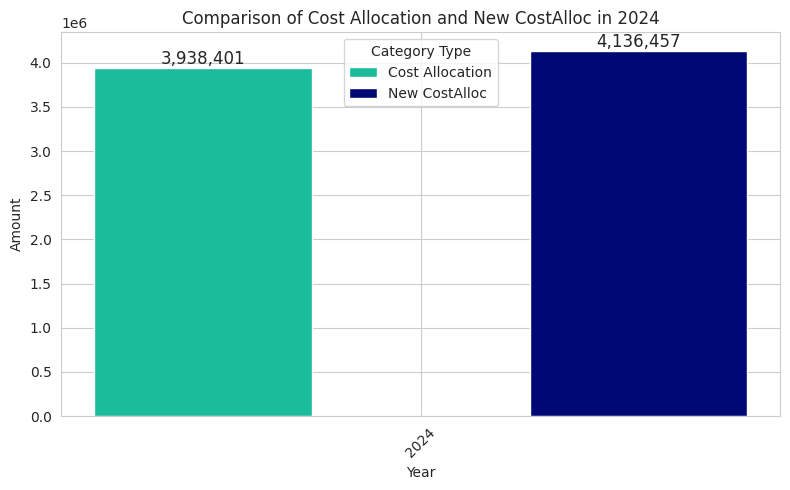

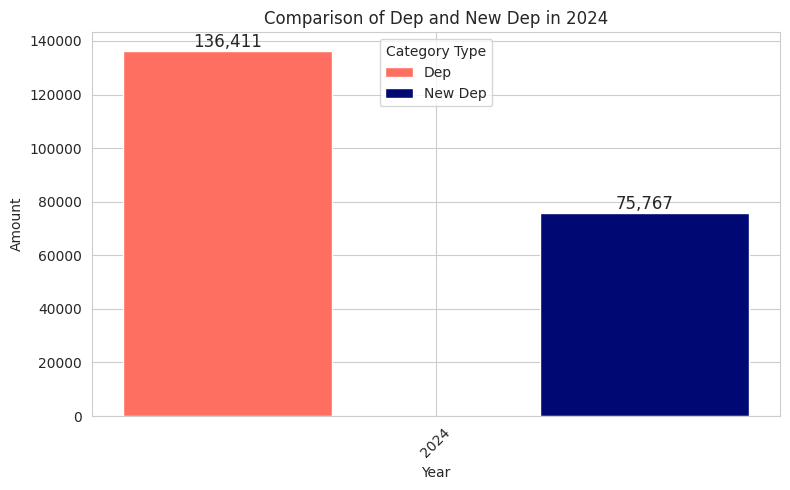

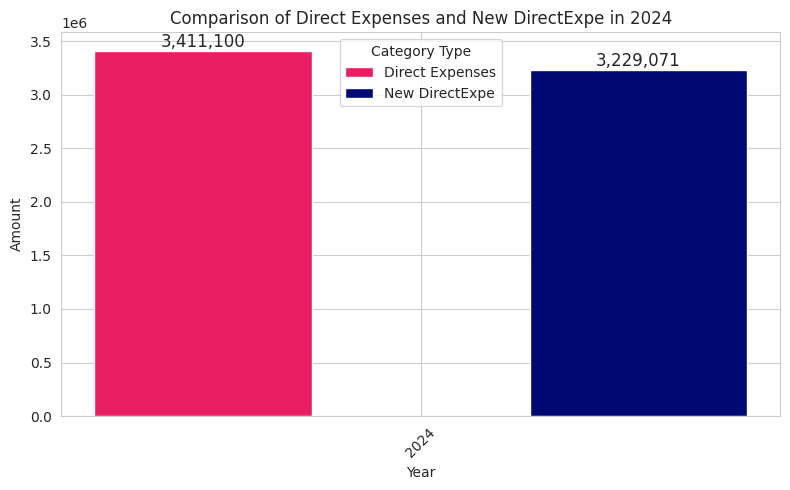

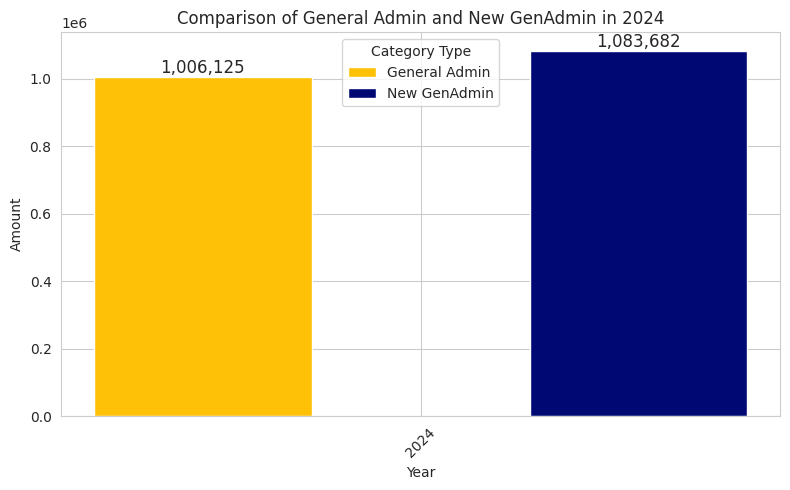

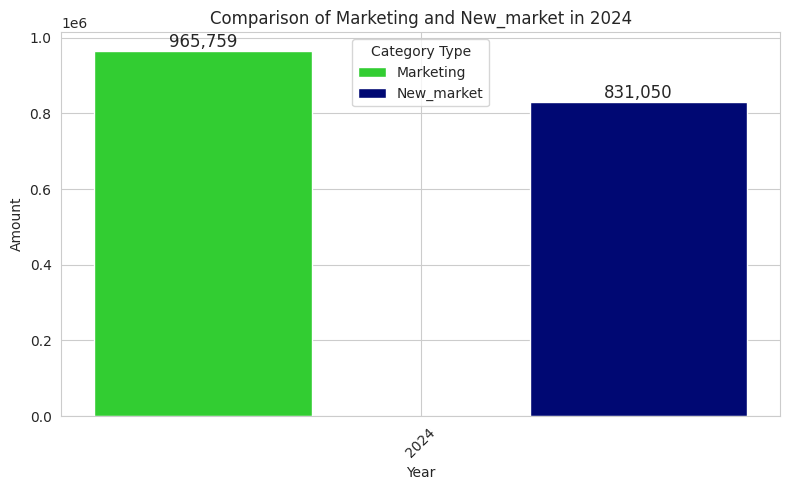

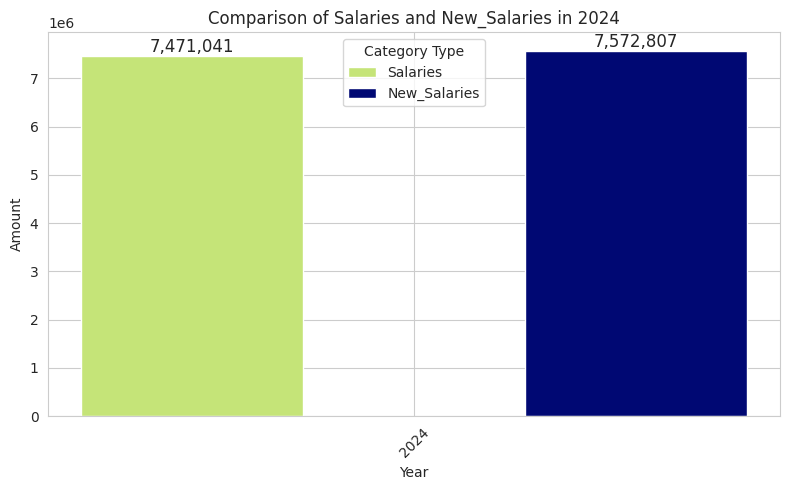

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

diff = category_analysis[category_analysis['year'] == 2024]

# Define bar width and positions (further reduced bar width)
x = np.arange(len(diff["year"]))  # Creating positions for the bars
width = 0.03  # Further reduced width of each bar

# List of original and new columns to compare
expense_columns = ['costalloc', 'dep', 'directexp', 'genadmin', 'marketing', 'salaries']
new_expense_columns = ['New_costalloc', 'New_dep', 'New_directexp', 'New_genadmin', 'New_market', 'New_Salaries']

# Dictionary of colors for each category
category_colors = {
    'Marketing':  "#32cd32",      # Dark Blue
    'Dep': "#FF6F61",     # Red
    'Cost Allocation': "#1ABC9C", # Teal
    'General Admin': "#FFC107",  # Amber
    'Direct Expenses': "#E91E63", # Magenta
    'Salaries': "#C5E478"       # Lemon Green
}

# Ensure that both the original and new columns exist in the DataFrame
for exp, new_exp in zip(expense_columns, new_expense_columns):
    if exp not in diff.columns:
        raise KeyError(f"Column '{exp}' not found in the DataFrame.")
    if new_exp not in diff.columns:
        raise KeyError(f"Column '{new_exp}' not found in the DataFrame.")

# Loop through each pair of expense columns and create a separate plot
for i, (exp, new_exp) in enumerate(zip(expense_columns, new_expense_columns)):
    fig, ax = plt.subplots(figsize=(8, 5))  # Create a new figure with more width for better spacing

    # Map the expense category names to the colors
    exp_name = exp.replace("marketing", "Marketing").replace("dep", "Dep").replace("costalloc", "Cost Allocation").replace("genadmin", "General Admin").replace("directexp", "Direct Expenses").replace("salaries", "Salaries")
    new_exp_name = new_exp.replace("New_marketing", "New Marketing").replace("New_dep", "New Dep").replace("New_costalloc", "New CostAlloc").replace("New_genadmin", "New GenAdmin").replace("New_directexp", "New DirectExpe").replace("New_salaries", "New Salaries")

    # Add the original expense category bar
    ax.bar(x - width, diff[exp], width, label=exp_name, color=category_colors.get(exp_name, "#000000"))

    # Add the new expense category bar
    ax.bar(x + width, diff[new_exp], width, label=new_exp_name, color=category_colors.get(new_exp_name, "#000873"))

    # Add text labels on top of the bars
    for j, value in enumerate(diff[exp]):
        ax.text(x[j] - width, value + 0.1, f'{value:,.0f}', ha='center', va='bottom', fontsize=12)

    for j, value in enumerate(diff[new_exp]):
        ax.text(x[j] + width, value + 0.1, f'{value:,.0f}', ha='center', va='bottom', fontsize=12)

    # Update layout for each individual plot
    ax.set_title(f"Comparison of {exp_name} and {new_exp_name} in 2024")
    ax.set_xticks(x)
    ax.set_xticklabels(diff["year"], rotation=45)
    ax.set_xlabel("Year")
    ax.set_ylabel("Amount")
    ax.legend(title="Category Type", loc="upper center")

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()


In [ ]:
legend_names = {
    'dep_per': 'Dep',
    'costalloc_per': 'Cost Alloc',
    'genadmin_per': 'Gen Admin',
    'directexp_per': 'Direct Exp',
    'salaries_per': 'Salaries',
    'marketing_per': 'Marketing'
}

# Melt the DataFrame for Plotly
melted_data = category_analysis.melt(id_vars=['year'],
                                     value_vars=list(legend_names.keys()),
                                     var_name='Category',
                                     value_name='Percentage')

# Apply legend name changes
melted_data['Category'] = melted_data['Category'].map(legend_names)

# Define the custom color scheme
color_map = {
    'Dep': "#FF6F61",         # Red
    'Cost Alloc': "#1ABC9C",  # Teal
    'Gen Admin': "#FFC107",   # Amber
    'Direct Exp': "#E91E63",  # Magenta
    'Salaries': "#C5E478",    # Lemon Green
    'Marketing': "#000873"    # Dark Blue
}

# Create a line chart with the new color scheme
fig = px.line(melted_data,
              x='year',
              y='Percentage',
              color='Category',
              title="<b>Yearly Expense Contribution Analysis</b>",
              labels={'Percentage': 'Contribution (%)', 'year': 'Year'},
              color_discrete_map=color_map)

# Add markers for better visibility
fig.update_traces(mode='lines+markers', marker=dict(size=6))

# Improve layout
fig.update_layout(
    template="plotly_dark",
    title_font_size=22,
    title_x=0.5,
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True, gridcolor="gray"),
    hovermode="x unified",
    height=600,
    width=900,
    legend=dict(
        title="Expense Category",
        orientation="h",
        yanchor="bottom",
        y=-0.25,
        xanchor="center",
        x=0.5
    )
)

# Show the interactive plot
fig.show()


In [ ]:
avg_marketing = category_analysis['marketing_per'].iloc[:4].mean()
avg_dep = category_analysis['dep_per'].iloc[2:4].mean()
avg_costalloc = category_analysis['costalloc_per'].iloc[1:4].mean()
avg_genadmin = category_analysis['genadmin_per'].iloc[1:4].mean()
avg_directexp = category_analysis['directexp_per'].iloc[1:4].mean()
avg_Salaries = category_analysis['salaries_per'].iloc[1:4].mean()

print("Average Marketing:", avg_marketing)
print("Average Dep:", avg_dep)
print("Average Cost Allocation:", avg_costalloc)
print("Average General Administration:", avg_genadmin)
print("Average Direct Expenses:", avg_directexp)
print("Average Salaries:", avg_Salaries)


Average Marketing: 4.607797813928113
Average Dep: 0.3218584591871805
Average Cost Allocation: 24.738716993428124
Average General Administration: 6.305879026947302
Average Direct Expenses: 17.811374843899966
Average Salaries: 46.2473997425073
